# ==========
# = Iteration #8 =
# ==========

## Stage 1: Planning
The tasks for this stage are:
1. Compose the project team
2. Set the research question
3. Schedule all review meeting to ensure iterations are time-boxed.

### 8.1.1. Compose the project team
The project team and Clinical Review Board are CMI and CB.

### 8.1.2. Set the research question
The research question is:

_How does changing the inclusion criteria affect the output of the sequence-mining investigation?_

I only include patient diagnosed before 2000, and I only view their sequences after 2010.

Since the previous iteration:
1. the diabetes medications have also been recategorised.
2. a longer sequence of test events and prescription events are studied.
3. the R syntax for generating the cohort, formatting the data, and for creating the STS objects is bundled into a separate R script that is called within this notebook.

### 8.1.3. Schedule all review meeting to ensure iterations are time-boxed
CMI and CB will meet in their regular Thursday-morning meeting, which will now be fortnightly.

## Stage 2: Extraction
This tasks for this stage are:
1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
2. Obtain data for processing

### 8.2.1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
Regarding the processes under study, I, the modeller, discuss the project during weekly meetings with an experienced GP who is a professor of primary medical care.
Regarding data-generating mechanisms, I, the modeller, have gathered knowledge from over half a decade experience collaborating with clinicians and patients on research projects about electronic healthcare 
records. 

### 8.2.2. Obtain data for processing
Data have been obtain by agreement via Connected Bradford. Data are queryable via this Jupyter notebook on the GoogleCloudPlatform using AI Vertex Workbench.

Select which portions of the notebook to run.

In [1]:
# Select which portions of the notebook to run.
# ## Some of these are dependent on others so you might get
# ## warning messages if requisite data aren't available
# ## because a portion of the notebook was skipped.
run_all <- TRUE # {TRUE, FALSE, NA}
run_install <- ifelse( is.na( run_all ), TRUE, run_all )
run_define_cohort <- ifelse( is.na( run_all ), TRUE, run_all )
run_add_stratification_variables <- ifelse( is.na( run_all ), TRUE, run_all )
run_create_sts_objects <- ifelse( is.na( run_all ), TRUE, run_all )
run_process_mining_summary <- ifelse( is.na( run_all ), FALSE, run_all )
run_complexity_statistics <- ifelse( is.na( run_all ), FALSE, run_all )
run_Sankey_plots <- ifelse( is.na( run_all ), TRUE, run_all )
run_laneSwitching_plots <- ifelse( is.na( run_all ), FALSE, run_all )
run_evaluation_rig <- ifelse( is.na( run_all ), FALSE, run_all )

# Get requisite packages.

In [2]:
# Get requisite packages.
if( !"pacman" %in% installed.packages() )
{
  install.packages( "pacman" )
  libray( pacman )
}
pacman::p_load(
    bigrquery
    ,data.table
    ,GGally
    ,gtable
    ,grid
    ,gridExtra
    ,paletteer
    ,readr
    ,tidytext
    ,tidyverse
    ,TraMineR
    ,TraMineRextras
)
devtools::install_github("davidsjoberg/ggsankey")

Skipping install of 'ggsankey' from a github remote, the SHA1 (b675d0d5) has not changed since last install.
  Use `force = TRUE` to force installation



# Generate the cohort.

In [3]:
source('RESHAPE_cohort_generator.r')

Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


# Format the data.

In [4]:
source('RESHAPE_format_the_data.r')

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


# Create STS objects.

In [63]:
source('RESHAPE_create_STS_objects.r')

# Summary of parameter values.

In [64]:
data.frame(
    row.names = c(
        "The date before which a patient must have had their diagnosis."
        ,"The follow-up delay, in years."
        ,"The follow-up duration, in years."
        ,"The date after which test and intervention records will be studied."
        ,"The date before which test and intervention records will be studied."
        ,"Lower threshold for acceptable values of the test."
        ,"Upper threshold for acceptable values of the test."
        ,"Number of tests, treatments, or iterations after diagnosis that should be tracked."
        ,"The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months."
        ,"The window outwith which at least two mutimorbidity diagnoses must be of each other, in months."
        )
    ,Value = c(
        date_diagnosis_threshold %>% as.character()
        ,followup_delay_in_years %>% as.character()
        ,followup_duration_in_years %>% as.character()
        ,date_followup_start %>% as.character()
        ,date_followup_end %>% as.character()
        ,test_value_cutoff_lower %>% as.character()
        ,test_value_cutoff_upper %>% as.character()
        ,n_iterations %>% as.character()
        ,multimorb_inclusion_window_months %>% as.character()
        ,multimorb_gap_window_months %>% as.character()
    )
)

Value     
The date before which a patient must have had their diagnosis.                                  2000-01-01
The follow-up delay, in years.                                                                  0         
The follow-up duration, in years.                                                               10        
The date after which test and intervention records will be studied.                             2000-01-01
The date before which test and intervention records will be studied.                            2010-01-01
Lower threshold for acceptable values of the test.                                              20        
Upper threshold for acceptable values of the test.                                              200       
Number of tests, treatments, or iterations after diagnosis that should be tracked.              20        
The window within which mutimorbidity diagnoses and the index diagnosis must fit in, in months. 60        
The window outwith which at least two mutimorbidity diagnoses must be of each other, in months. 1

## Stage 4: Mining and analysis
This tasks for this stage are:
1. Discover / Mine process models
2. Build simulation models
3. Design and test model evaluation rig
4. Set up and/or update the evidence template

### 8.4.1 Discover / Mine process models       
This iterations analysis will focus on various data-processing steps for 'trajectory' mining without using process-mining or sequence-pattern mining R packages. Instead, I will only use `TraMineR`.

Plot the top-10 most-frequent patient journeys.

In [65]:
if ( run_process_mining_summary )
    {
        TraMineR::seqtab( sts_seqmine ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

sequence                         Freq Percent    cum_sum_percent
1  END                              1153 15.3692349 15.36923       
2  Test Status = Red for 1 → END     124  1.6528926 17.02213       
3  Test Status = Yellow for 1 → END  121  1.6129032 18.63503       
4  Test Status = Green for 1 → END   114  1.5195948 20.15463       
5  Test Status = Amber for 1 → END   109  1.4529459 21.60757       
6  Test Status = Green for 2 → END    57  0.7597974 22.36737       
7  Test Status = Red for 2 → END      46  0.6131698 22.98054       
8  Test Status = Green for 4 → END    39  0.5198614 23.50040       
9  Test Status = Yellow for 2 → END   38  0.5065316 24.00693       
10 Test Status = Amber for 2 → END    31  0.4132231 24.42015

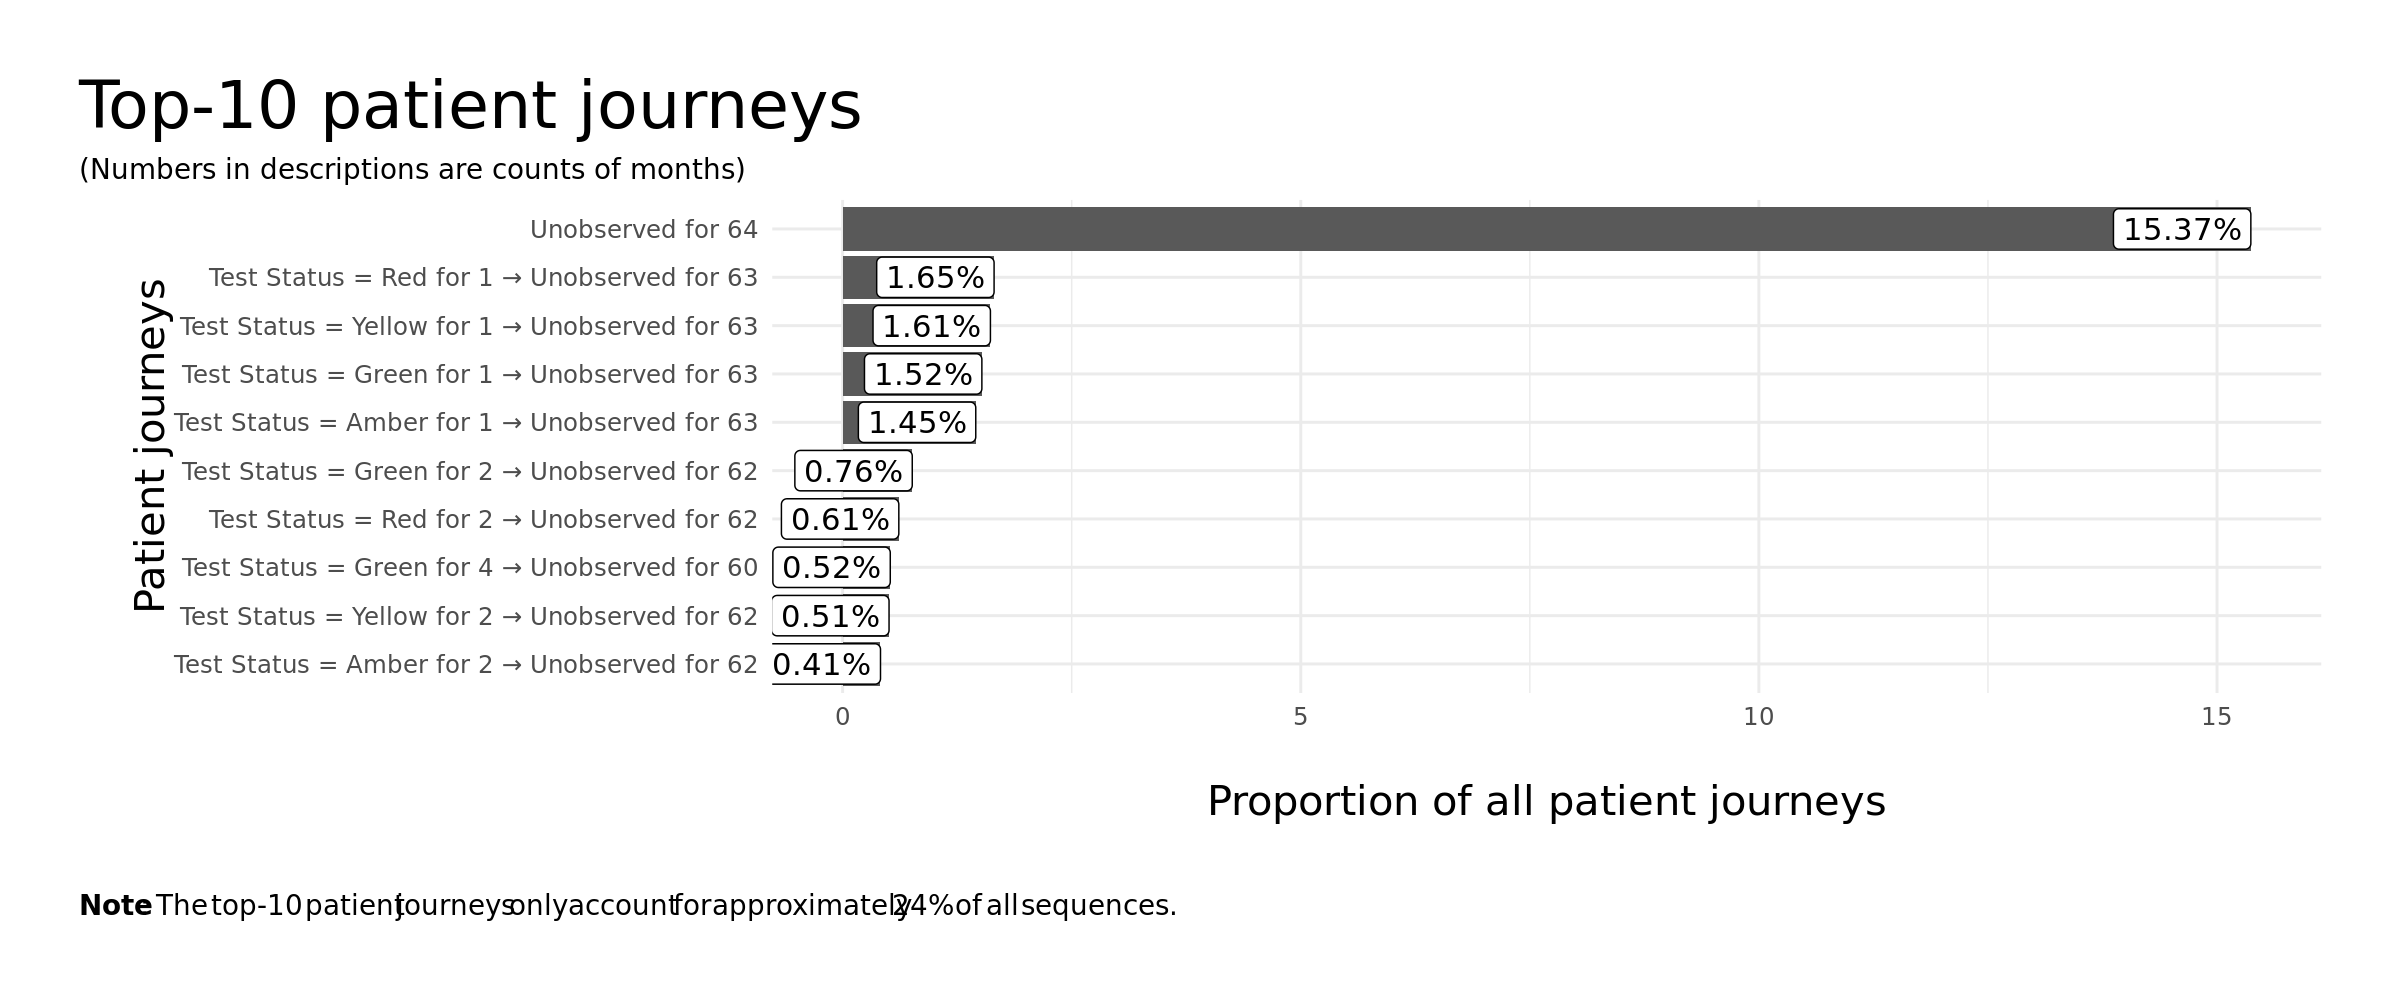

In [66]:
if ( run_process_mining_summary )
    {
        options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

        # Make plot data.
        plot_data <-
            TraMineR::seqtab( sts_seqmine ) %>%
            attributes() %>%
            purrr::pluck( "freq" ) %>%
            tibble::rownames_to_column( "sequence" ) %>%
            dplyr::arrange( desc( Freq ) ) %>%
            dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
            # Remove the leading "None/[0-9]"
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
                ) %>%
            # Replace the "-" that joins the events with an arrow.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
                ) %>%
            # Use words instead of symbols for the number of timesteps.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
                ) %>%
            suppressWarnings()


        # Plot plot data.
        plot_data %>%
            ggplot(
                aes(
                    x = reorder( sequence, Freq )
                    ,y = Percent )
                , stat = "identity"
            ) +
            geom_col() +
            geom_label(
                    aes(
                        label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
                    )
                    ,hjust = 1 ) +
            coord_flip() +
            labs(
                x = "Patient journeys"
                ,y = "Proportion of all patient journeys"
                ,title = "Top-10 patient journeys"
                ,subtitle = "(Numbers in descriptions are counts of months)"
                ,caption = paste0(
                    "**Note**: The top-10 patient journeys only account for approximately "
                    ,round( max( plot_data$cum_sum_percent ))
                           ,"% of all sequences."
                          )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = "none"
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
                ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
                )
    }

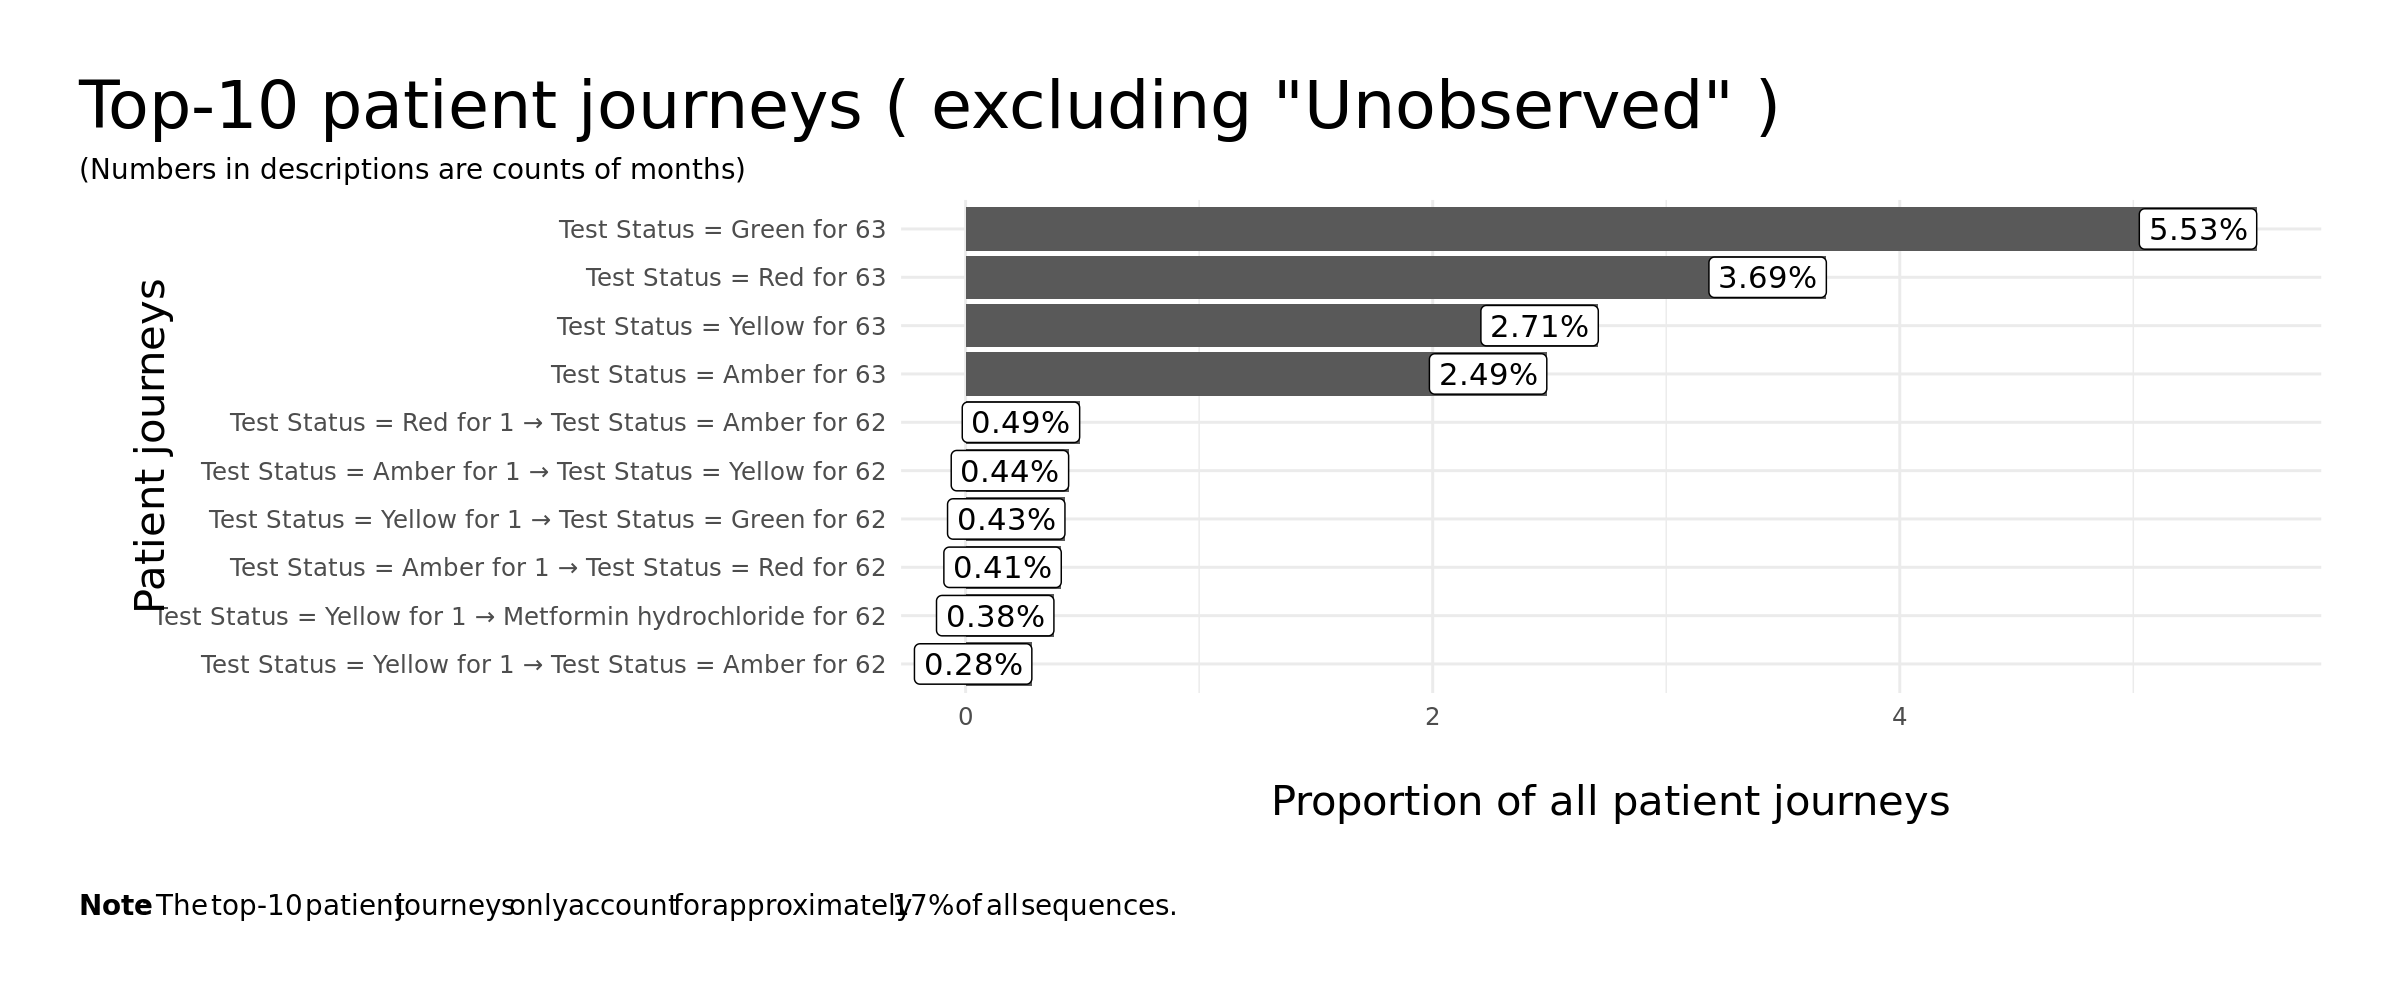

In [68]:
if ( run_process_mining_summary )
    {
        options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

        # Make plot data.
        plot_data <-
            TraMineR::seqtab( sts_seqmine_excludingUnobserved ) %>%
            attributes() %>%
            purrr::pluck( "freq" ) %>%
            tibble::rownames_to_column( "sequence" ) %>%
            dplyr::arrange( desc( Freq ) ) %>%
            dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
            # Remove the leading "None/[0-9]"
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
                ) %>%
            # Replace the "-" that joins the events with an arrow.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
                ) %>%
            # Use words instead of symbols for the number of timesteps.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
                ) %>%
            suppressWarnings()


        # Plot plot data.
        plot_data %>%
            ggplot(
                aes(
                    x = reorder( sequence, Freq )
                    ,y = Percent )
                , stat = "identity"
            ) +
            geom_col() +
            geom_label(
                    aes(
                        label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
                    )
                    ,hjust = 1 ) +
            coord_flip() +
            labs(
                x = "Patient journeys"
                ,y = "Proportion of all patient journeys"
                ,title = "Top-10 patient journeys ( excluding \"Unobserved\" )"
                ,subtitle = "(Numbers in descriptions are counts of months)"
                ,caption = paste0(
                    "**Note**: The top-10 patient journeys only account for approximately "
                    ,round( max( plot_data$cum_sum_percent ))
                           ,"% of all sequences."
                          )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = "none"
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
                ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
                )
    }

Below are the month-by-month relative propotions of each event.

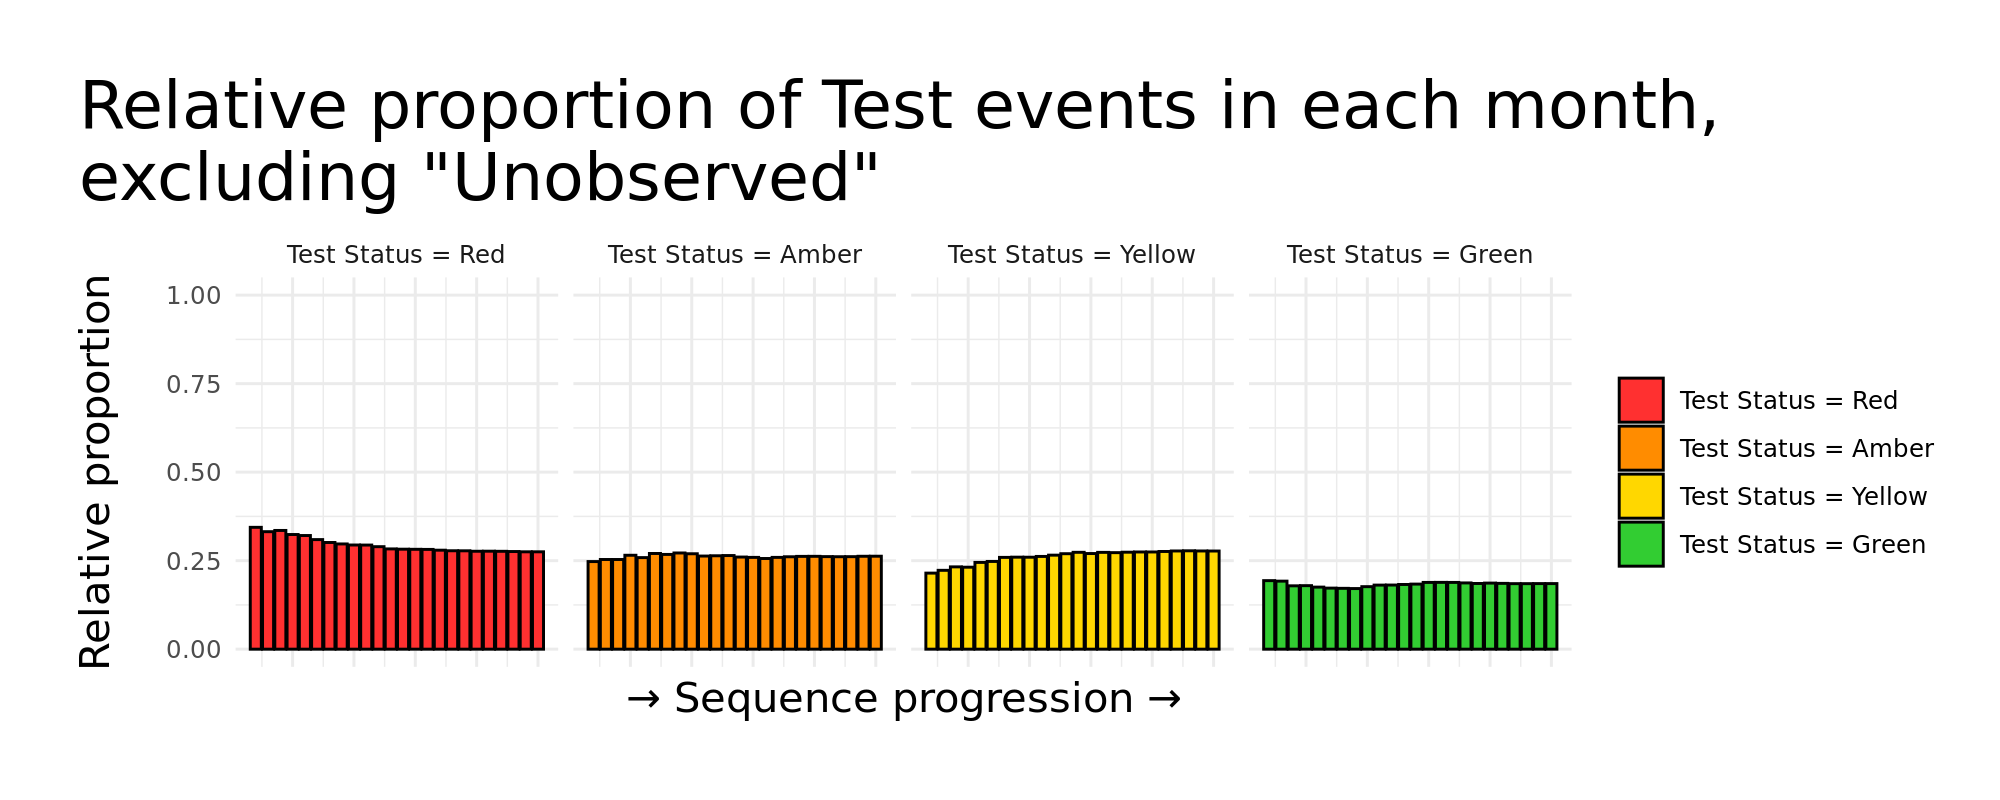

In [69]:
if ( run_process_mining_summary )
    {
    # Prepare plot data.
        plot_data <-
            TraMineR::seqstatd( sts_seqmine_test_only_excludingUnobserved ) %>%
            purrr::pluck( "Frequencies" ) %>%
            as.data.frame() %>%
            tibble::rownames_to_column( "event" ) %>%
            dplyr::filter( !(event %in% c( "None", "Unobserved" ) ) ) %>%
            tidyr::pivot_longer(
                cols = !event
                ,names_to = "month"
                ,values_to = "proportion"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( event )
                ,.funs = funs( factor (., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            dplyr::mutate_at(
                .vars = vars( month )
                ,.funs = funs( stringr::str_replace_all( ., "a", "" ) %>% as.integer() )
            ) %>%
            suppressWarnings()

        # Plotting.
        options( repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200 )
        plot_relProp_TestStatuses <-
            plot_data %>%
            ggplot() +
            geom_bar(
                aes(
                    x = month
                    ,y = proportion
                    ,fill = event
                )
                ,stat = "identity"
                ,colour = "black"
            ) +
            facet_wrap( ~ event, nrow = 1) +
            scale_fill_manual( values = df_event_factor %>% dplyr::select( event_colours_order ) %>% dplyr::pull() ) +
            labs(
                x = "\u2192 Sequence progression \u2192"
                ,y = "Relative proportion"
                ,title = "Relative proportion of Test events in each month,\nexcluding \"Unobserved\""
            ) +
            ylim(0, 1) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.x = element_blank()
                ,legend.title = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                )

        plot_relProp_TestStatuses
    }

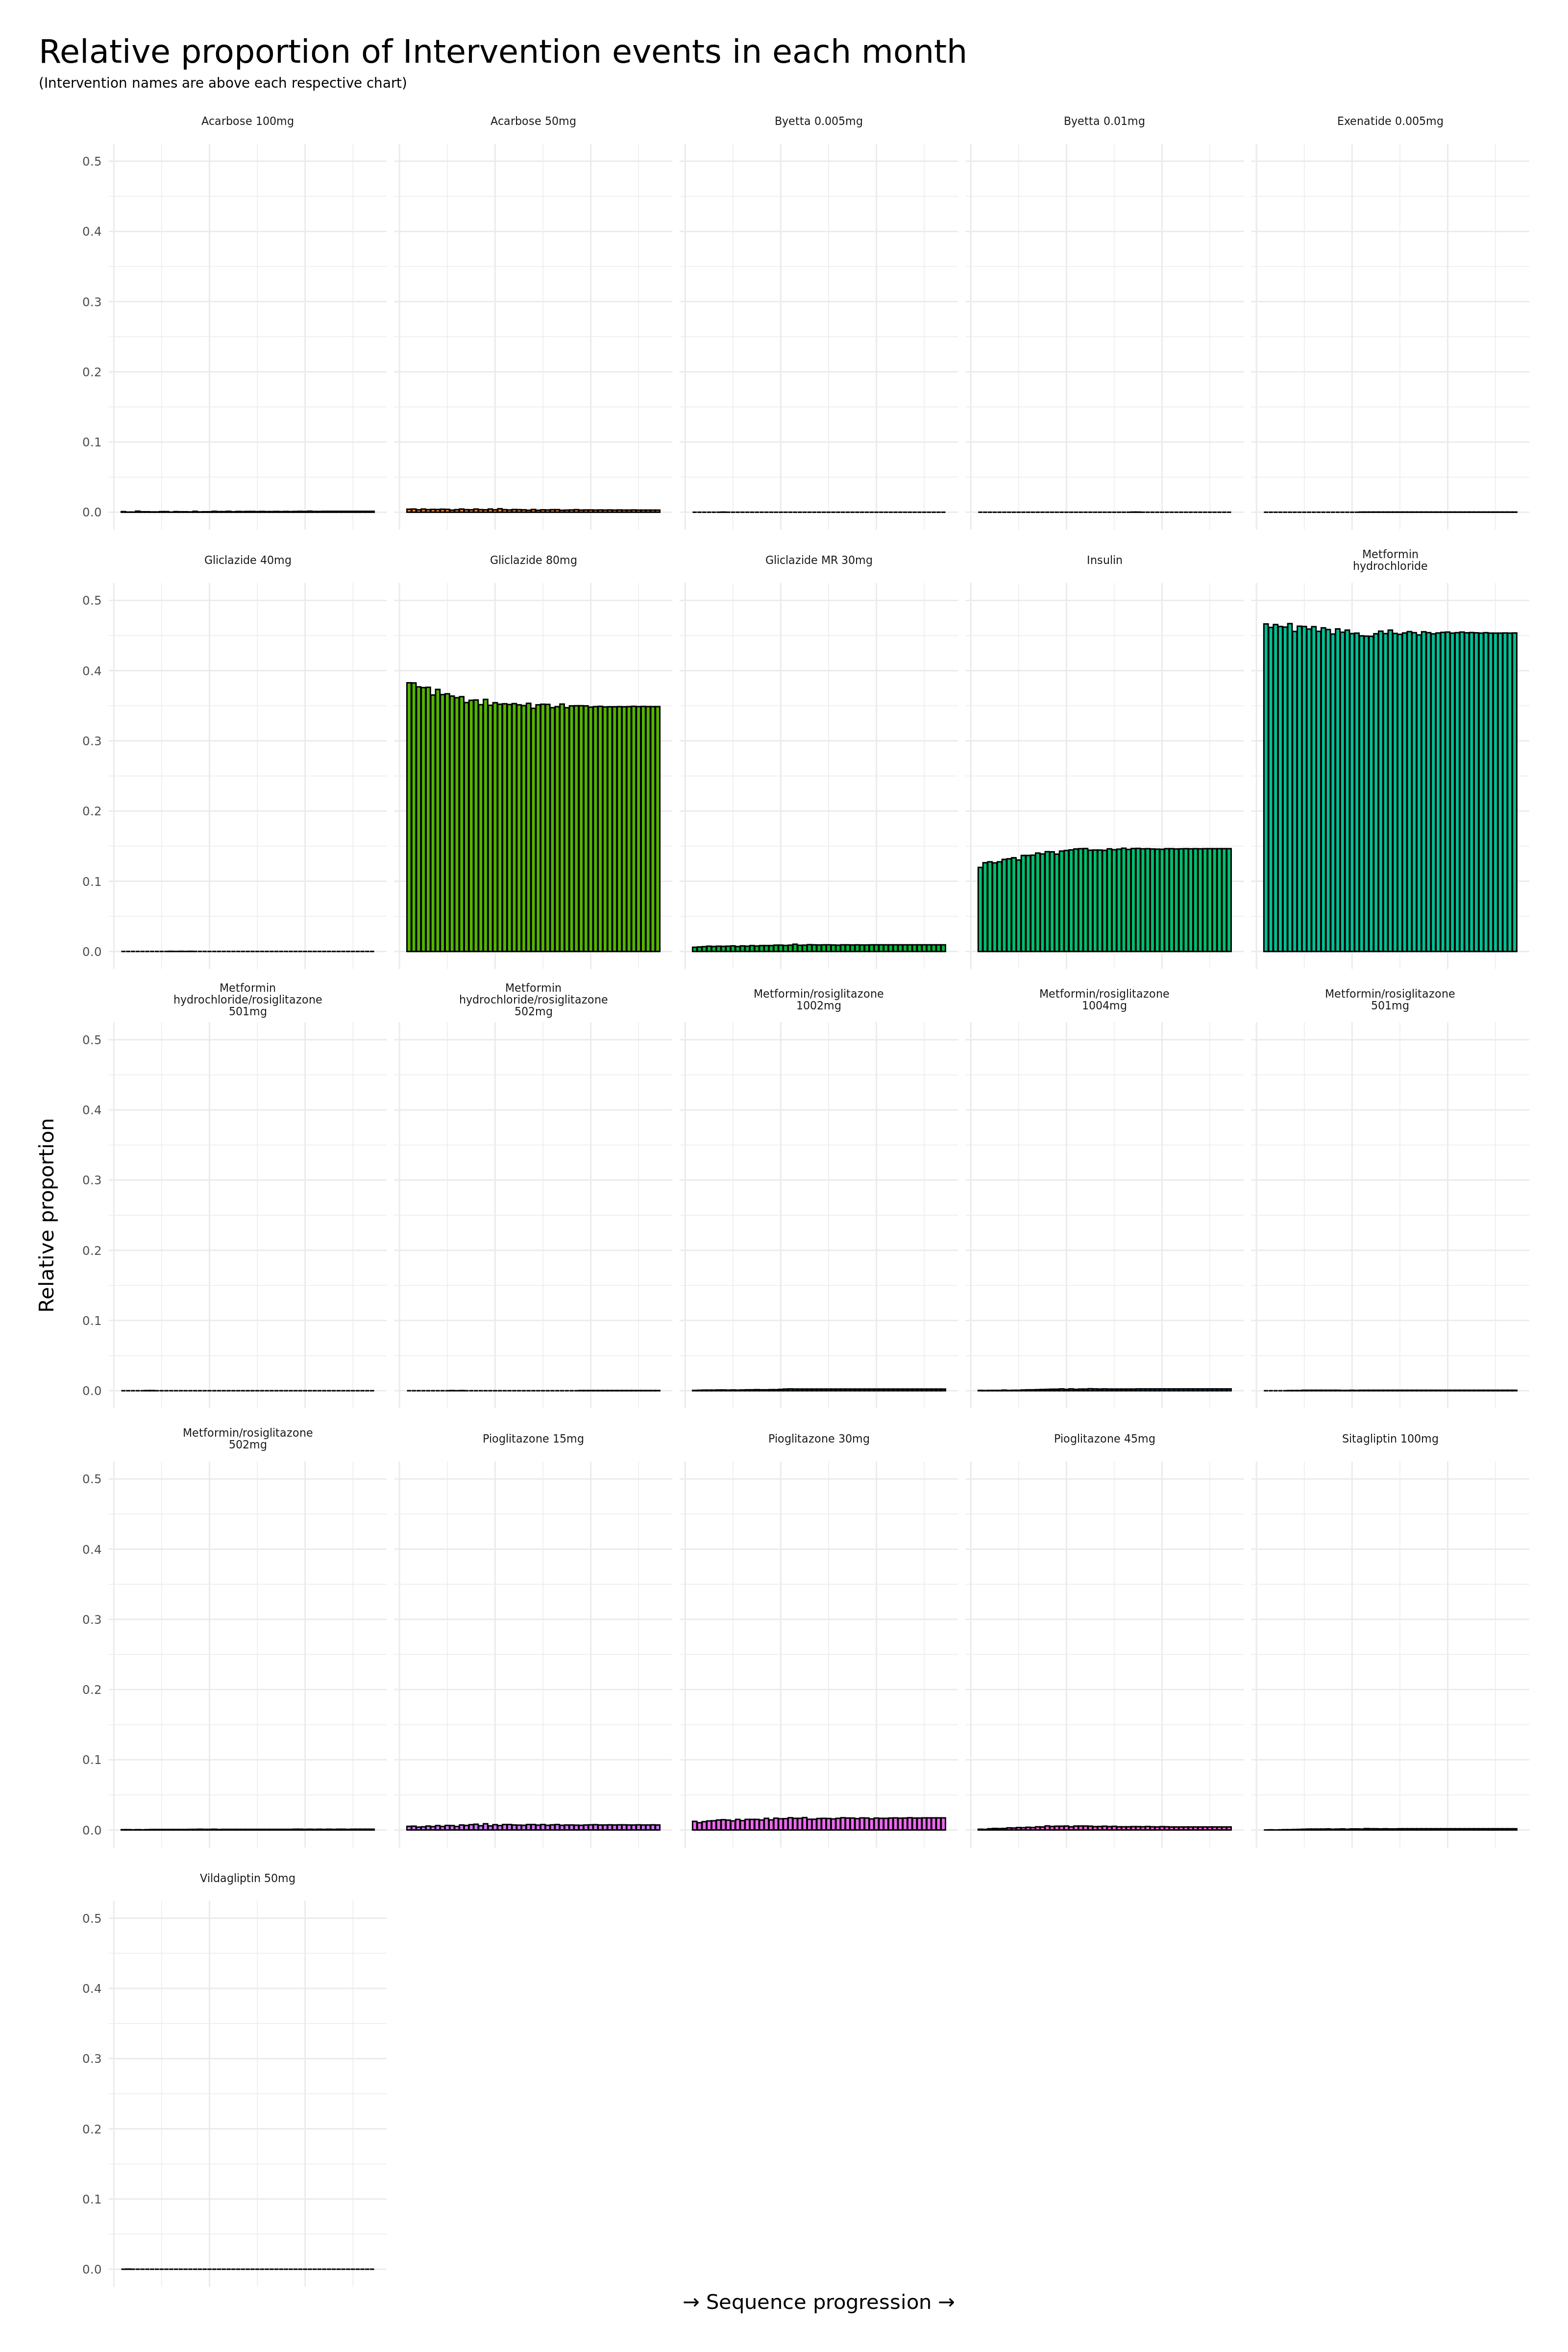

In [70]:
if ( run_process_mining_summary )
    {
        # Prepare plot data.
        plot_data <-
            TraMineR::seqstatd( sts_seqmine_intervention_only_excludingUnobserved ) %>%
            purrr::pluck( "Frequencies" ) %>%
            as.data.frame() %>%
            tibble::rownames_to_column( "event" ) %>%
            dplyr::filter( !(event %in% c( "None", "Unobserved" ) ) ) %>%
            tidyr::pivot_longer(
                cols = !event
                ,names_to = "month"
                ,values_to = "proportion"
            ) %>%
            # Reorder the `event` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( event )
                ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            # Remove the "a" in the `month` variable values that were added by the TraMineR functions.
            dplyr::mutate_at(
                .vars = vars( month )
                ,.funs = funs( stringr::str_replace_all( ., "a", "" ) %>% as.integer() )
            ) %>%
            suppressWarnings()

        # Plotting.
        options( repr.plot.width = 16, repr.plot.height = 24, repr.plot.res = 200 )

        plot_relProp_Treatments <-
            plot_data %>%
            ggplot() +
            geom_bar(
                aes(
                    x = month
                    ,y = proportion
                    ,fill = event
                )
                ,stat = "identity"
                ,colour = "black"
            ) +
            facet_wrap( ~ event, labeller = label_wrap_gen( 20 ) ) +
            labs(
                x = "\u2192 Sequence progression \u2192"
                ,y = "Relative proportion"
                ,title = "Relative proportion of Intervention events in each month"
                ,subtitle = "(Intervention names are above each respective chart)"
            ) +
            ylim(0, 0.5) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.x = element_blank()
                ,legend.position = 'None'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,strip.text = element_text( size = 8 )
                )

        plot_relProp_Treatments
    }

Average duration that a patient spends in a "state" without changing.

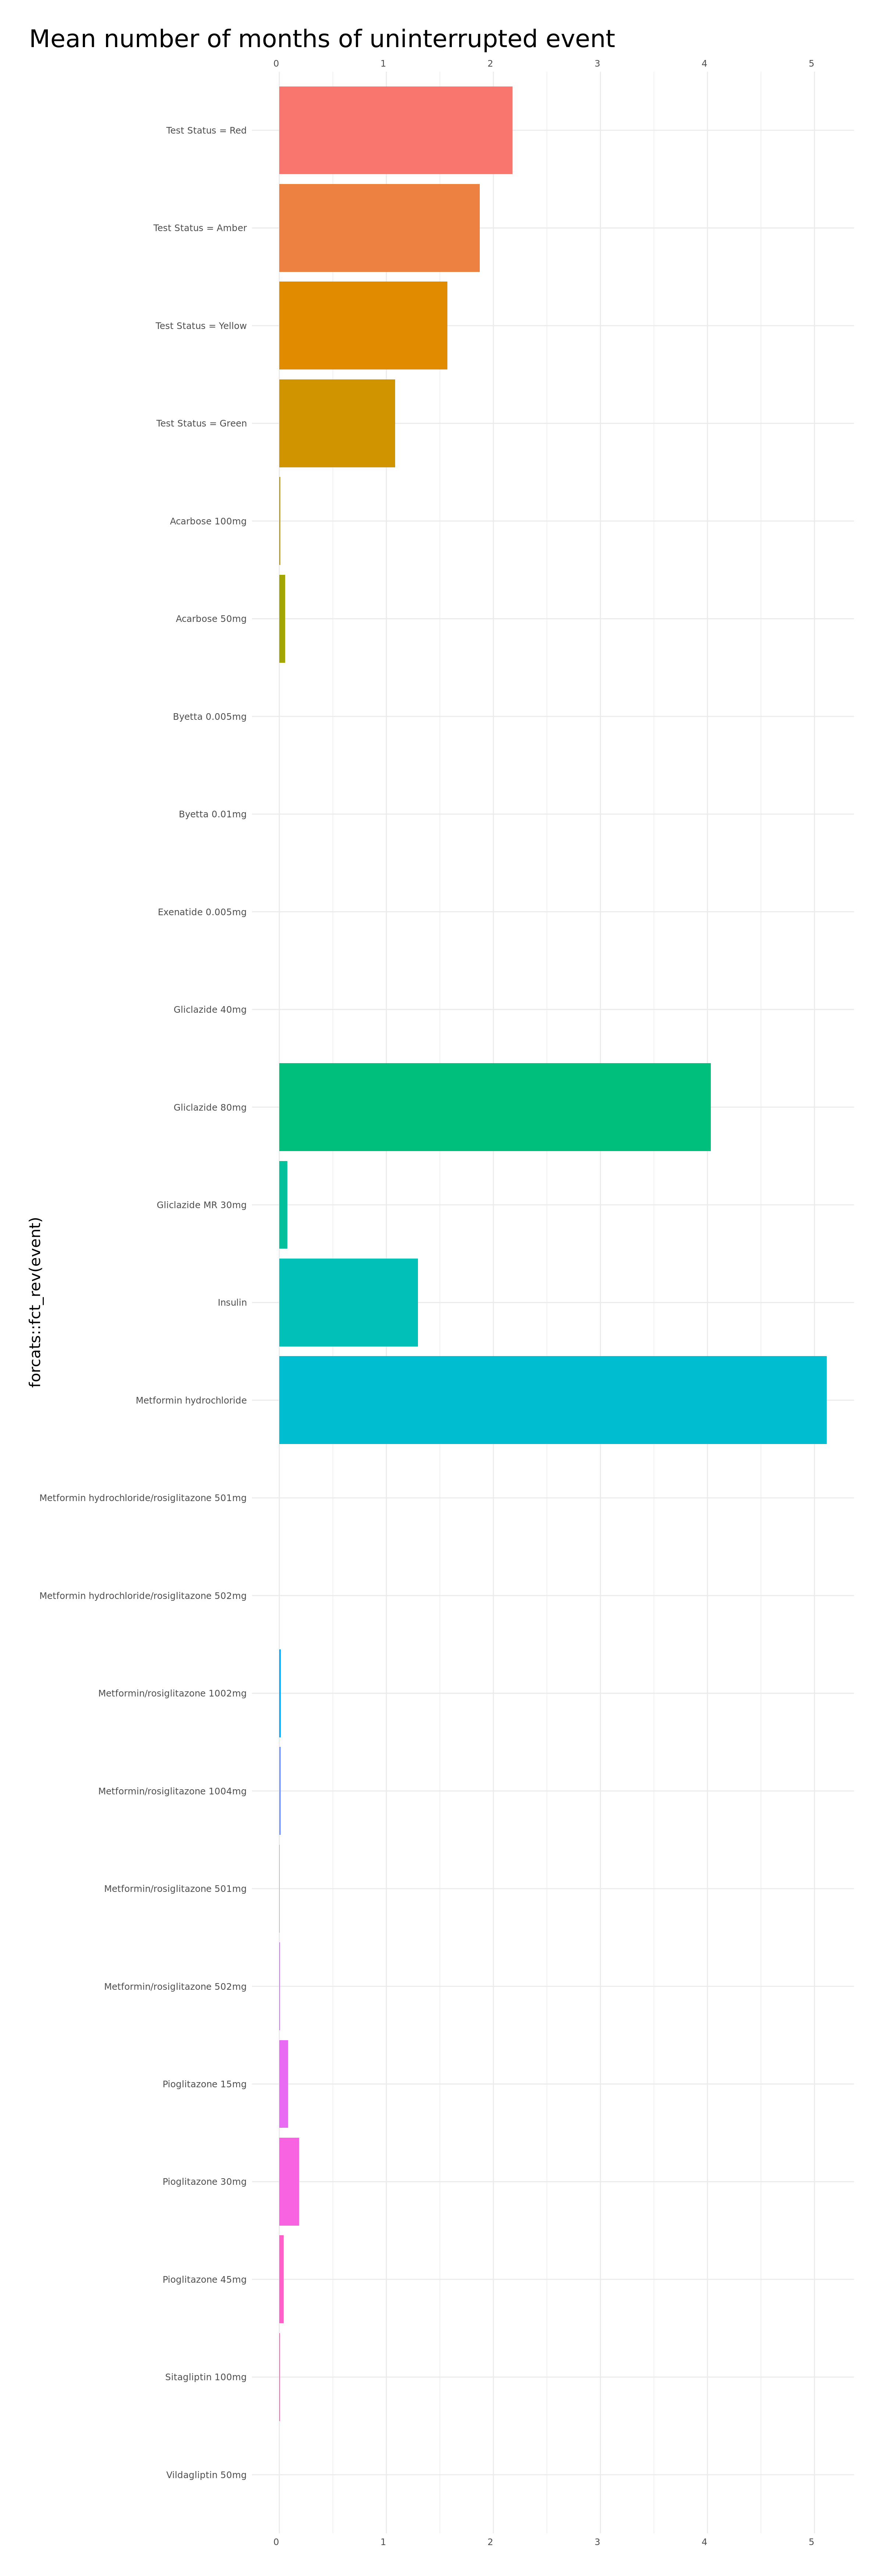

In [71]:
if ( run_process_mining_summary )
    {
        # Make plot data.
        plotData <-
            TraMineR::seqmeant( sts_seqmine ) %>%
            as.data.frame() %>%
            tibble::rownames_to_column("event") %>%
            dplyr::left_join(
                df_event_factor
                ,by = join_by( event == event_fct_order)
            ) %>%
            dplyr::mutate_at(
                .vars = vars( event )
                ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            dplyr::filter( !(event %in% c( "NA", "Unobserved" ) ) ) %>%
            dplyr::arrange( event ) %>%
            suppressWarnings()


        # Plotting.
        options( repr.plot.width = 12, repr.plot.height = 35, repr.plot.res = 200 )

        plot_durationOfEvents <-
            plotData %>%
            ggplot() +
            geom_bar(
                aes(
                    x = forcats::fct_rev( event )
                    ,y = Mean
                    ,fill = event
                )
                ,stat = "identity" ) +
            labs(
                title = "Mean number of months of uninterrupted event"
                ,y = "Number of\nmonths"
            ) +
            scale_x_discrete( labels = scales::label_wrap( 70 ) ) +
            scale_y_continuous( sec.axis = dup_axis() ) +
            coord_flip() +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.x = element_text( hjust = 1 )
                ,axis.title.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,legend.position = 'None'
                )

        plot_durationOfEvents
    }

Some initial observations of the process-mining investigation:
- __The most-common sequence patterns (when the "Unobserved" values are ignored) are dominated by long stretches of the same test-status values.__
    - Evidenced by the percentage contribution of patient journeys in the top 10.
- __Unlike when we studied sequences from diagnosis, the counts of test-status values stay steady over time__
    - Evidenced by the level counts of test status values.

#### Burden of Treatment / Turbulence / Complexity of care

Calculate statistics that summarise and represent the complicatedness / complexity of patients' sequences, then plot as histograms.

_Component_

- The __Transitions Count__ statistic is the count of times a patient changes state during their sequence. It has an unbounded range and does not take the length of the sequence into account (i.e. low counts can indicate short sequences with little time to change state, or can indicate a long and stable sequence).
- The __$\mathbf{log_{2}}(Subsequence Count)$__ statistic is the  $log_{2}$ of the count of 'distinct successive states' during a patient's sequence. It has an unbounded range with a sequence-specific maximum reached when the sequence cycles between all its states. Low values can indicate either few changes or a small number of unique states observed in the sequence.
- The __Longitudinal Entropy__ statistic quantifies the entropy of the distribution of durations spent in each state observed in the sequence. It is a measure of diversity of states within a sequence. It's range is between 0 and 1 because each sequence's value is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet).

_Composite_

- The __Turbulence__ statistic is the $log_{2}$ of the product of the count of subsequences and a sequence-specific scaling parameter ([Elzinga et al. 2007](https://sci-hub.wf/10.1007/s10680-007-9133-7)). The sequence-specific scaling parameter is based on the variance of observed state durations (which we know to be inversely proportional to the notion of turbulent sequences). Larger values are associated with sequences that have many states, changes, and similar durations in each state. This statistic differs from the $\mathbf{log_{2}}(Subsequence Count)$ only by the sequence-specific scaling parameter within the $log_{2}$ operator.
- The __Complexity Index__ statistic is the geometric mean of a scaled count of transitions in a sequence and the sequence's scaled longitudinal entropy ([Gabadinho et al. 2010](https://www.researchgate.net/profile/Gilbert-Ritschard/publication/220786242_Indice_de_complexite_pour_le_tri_et_la_comparaison_de_sequences_categorielles/links/53edabdb0cf26b9b7dc5f259/Indice-de-complexite-pour-le-tri-et-la-comparaison-de-sequences-categorielles.pdf)). The count of transitions is scaled to the length of the sequence, and the longitundinal entropy is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet). It's range is between 0 and 1.


Below I plot the distributions of each statistics, for various sets of states (e.g. tests only or interventions only). Upon request from the Clinical Review Board, I also provide plots stratifed where hte disrtibutinos are stratified by patient records' multimorbidity status (Green = Not multimorbidd; Red = Multimorbid).

In [72]:
if ( run_complexity_statistics )
    {
    # Create function that will append the multimorbidity covariate.
    add.covariate <-
        function(
                df
                ,covardf = df_log_PandT_longFormat_simplified_StrataLabels
                ,covaradd = "MultiMorb"
        )
        {
        df %>%
        as.data.frame() %>%
        tibble::rownames_to_column( "person_id" ) %>%
        dplyr::mutate( person_id = as.integer( person_id ) ) %>%
        dplyr::left_join(
            covardf %>% dplyr::distinct( person_id, get( covaradd ) ) %>% `colnames<-`( c( "person_id", covaradd ) )
            ,by = join_by( person_id )
        ) %>% suppressWarnings()
    }

    # Create function that will plot the sequence-complexity statistics.
    fnc.plot.cplx.stats.dists <-
        function(
            stsObj
            ,nbins = 20
            ,title
            ,geom = "density"
            ,strata = NULL
        )
            {

            # Make plot data.
            # ## Calculate statistics over all patient records.
            if( is.null( strata ) )
                {
                    seq_transitionCount <- TraMineR::seqtransn( stsObj )
                    seq_subsequenceCount <- TraMineR::seqsubsn( stsObj ) %>% log( base = 2 )
                    seq_longEntropy <- TraMineR::seqient( stsObj )
                    seq_turbulence <- TraMineR::seqST( stsObj )
                    seq_complexity <- TraMineR::seqici( stsObj )
                } else {
                    seq_transitionCount <- TraMineR::seqtransn( stsObj ) %>% add.covariate( covaradd = strata )
                    seq_subsequenceCount <- TraMineR::seqsubsn( stsObj ) %>% log( base = 2 ) %>% add.covariate( covaradd = strata )
                    seq_longEntropy <- TraMineR::seqient( stsObj ) %>% add.covariate( covaradd = strata )
                    seq_turbulence <- TraMineR::seqST( stsObj ) %>% add.covariate( covaradd = strata )
                    seq_complexity <- TraMineR::seqici( stsObj ) %>% add.covariate( covaradd = strata )
                }

            # Make plots.
            if(geom == "hist")
                {
                    # ## Plot histograms and summary statistics.
                    n_bins <- nbins
                    trans <-
                        seq_transitionCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Trans., fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence transition count", x = "Transition count", y = "Frequency" ) +
                        theme_classic() +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    subseq <-
                        seq_subsequenceCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Subseq., fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = base::bquote("Sequence "*log[2]("Subsequence Count")) , x = base::bquote(log[2]("Subsequence Count")), y = "Frequency" ) +
                        theme_classic() +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    entr <-
                        seq_longEntropy %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Entropy, fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence longitudinal entropy", x = "Longitudinal entropy", y = "Frequency" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    turb <-
                        seq_turbulence %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Turbulence, fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence turbulence", x = "Turbulence score", y = "Frequency" ) +
                        theme_classic()  +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    cidx <-
                        seq_complexity %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( C, fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence complexity", x = "Complexity index", y = "Frequency" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        guides( colour = guide_legend( title = strata ) ) %>%
                        suppressWarnings()
                }
            if(geom == "density")
                {
                    # ## Plot smoothed density and summary statistics.
                    trans <-
                        seq_transitionCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Trans., colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence transition count", x = "Transition count", y = "Density" ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    subseq <-
                        seq_subsequenceCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Subseq., colour = if( !is.null( strata ) ) { get( strata ) } )) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = base::bquote("Sequence "*log[2]("Subsequence Count")) , x = base::bquote(log[2]("Subsequence Count")), y = "Density" ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    entr <-
                        seq_longEntropy %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Entropy, colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence longitudinal entropy", x = "Longitudinal entropy", y = "Density" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    turb <-
                        seq_turbulence %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Turbulence, colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence turbulence", x = "Turbulence score", y = "Density" ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    cidx <-
                        seq_complexity %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( C, colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence complexity", x = "Complexity index", y = "Frequency" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        guides( colour = guide_legend( title = strata ) )
                }
            if( !geom %in% c( "hist", "density" ) ) { stop("`geom` can only take values c( \"hist\", \"density\" ).") }

            # ## Create table of summary statistics.
            plot_table <-
                seq_transitionCount %>%
                dplyr::bind_cols( seq_subsequenceCount, seq_longEntropy, seq_turbulence, seq_complexity, .name_repair = "minimal" ) %>%
                dplyr::select(- ( contains("person_id") | contains("Multi") ) ) %>%
                dplyr::summarise(
                    across(
                        everything()
                        ,list(
                            min = min
                            ,`1st qtr` = ~quantile( ., 0.25 )
                            ,mean = mean
                            ,median = median
                            ,`3rd qtr` = ~quantile( ., 0.75 )
                            ,max = max
                        )
                    )
                ) %>%
                base::round(2) %>%
                pivot_longer(
                    everything()
                    ,names_sep = '_'
                    ,names_to = c( 'variable', '.value' )
                ) %>%
                t() %>%
                gridExtra::tableGrob( theme = gridExtra::ttheme_default( base_size = 8) )

            # ## Plot.
            options( repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 200 )
        
            myAlphabet <- stsObj %>% attributes() %>% `[[`('alphabet') 
            text_subplot <-
                paste(
                    "The state-sequence alphabet is made of"
                    ,myAlphabet %>% length()
                    ,"states."
                )
            
            plot_titles <-
                cowplot::plot_grid(
                    cowplot::ggdraw() +
                        cowplot::draw_label(
                            title
                            ,x = 0.05, y = 0.2, hjust = 0, size = 20
                        )
                    ,cowplot::ggdraw() +
                        cowplot::draw_label(
                            text_subplot
                            ,x = 0.05, y = 0.2, hjust = 0, size = 13
                        )
                    ,nrow = 3
                    ) %>%
                suppressWarnings()

            plot_plotsCombined <-
                cowplot::plot_grid(
                    trans, subseq, entr, turb, cidx, plot_table
                    ,ncol = 3
                    ) %>%
                suppressWarnings()

            plot_sequenceComplexity <-
                cowplot::plot_grid(
                    plot_titles, plot_plotsCombined
                    ,nrow = 2
                    ,rel_heights = c( 0.3, 1 )
                    )

            plot_sequenceComplexity
        }
    }

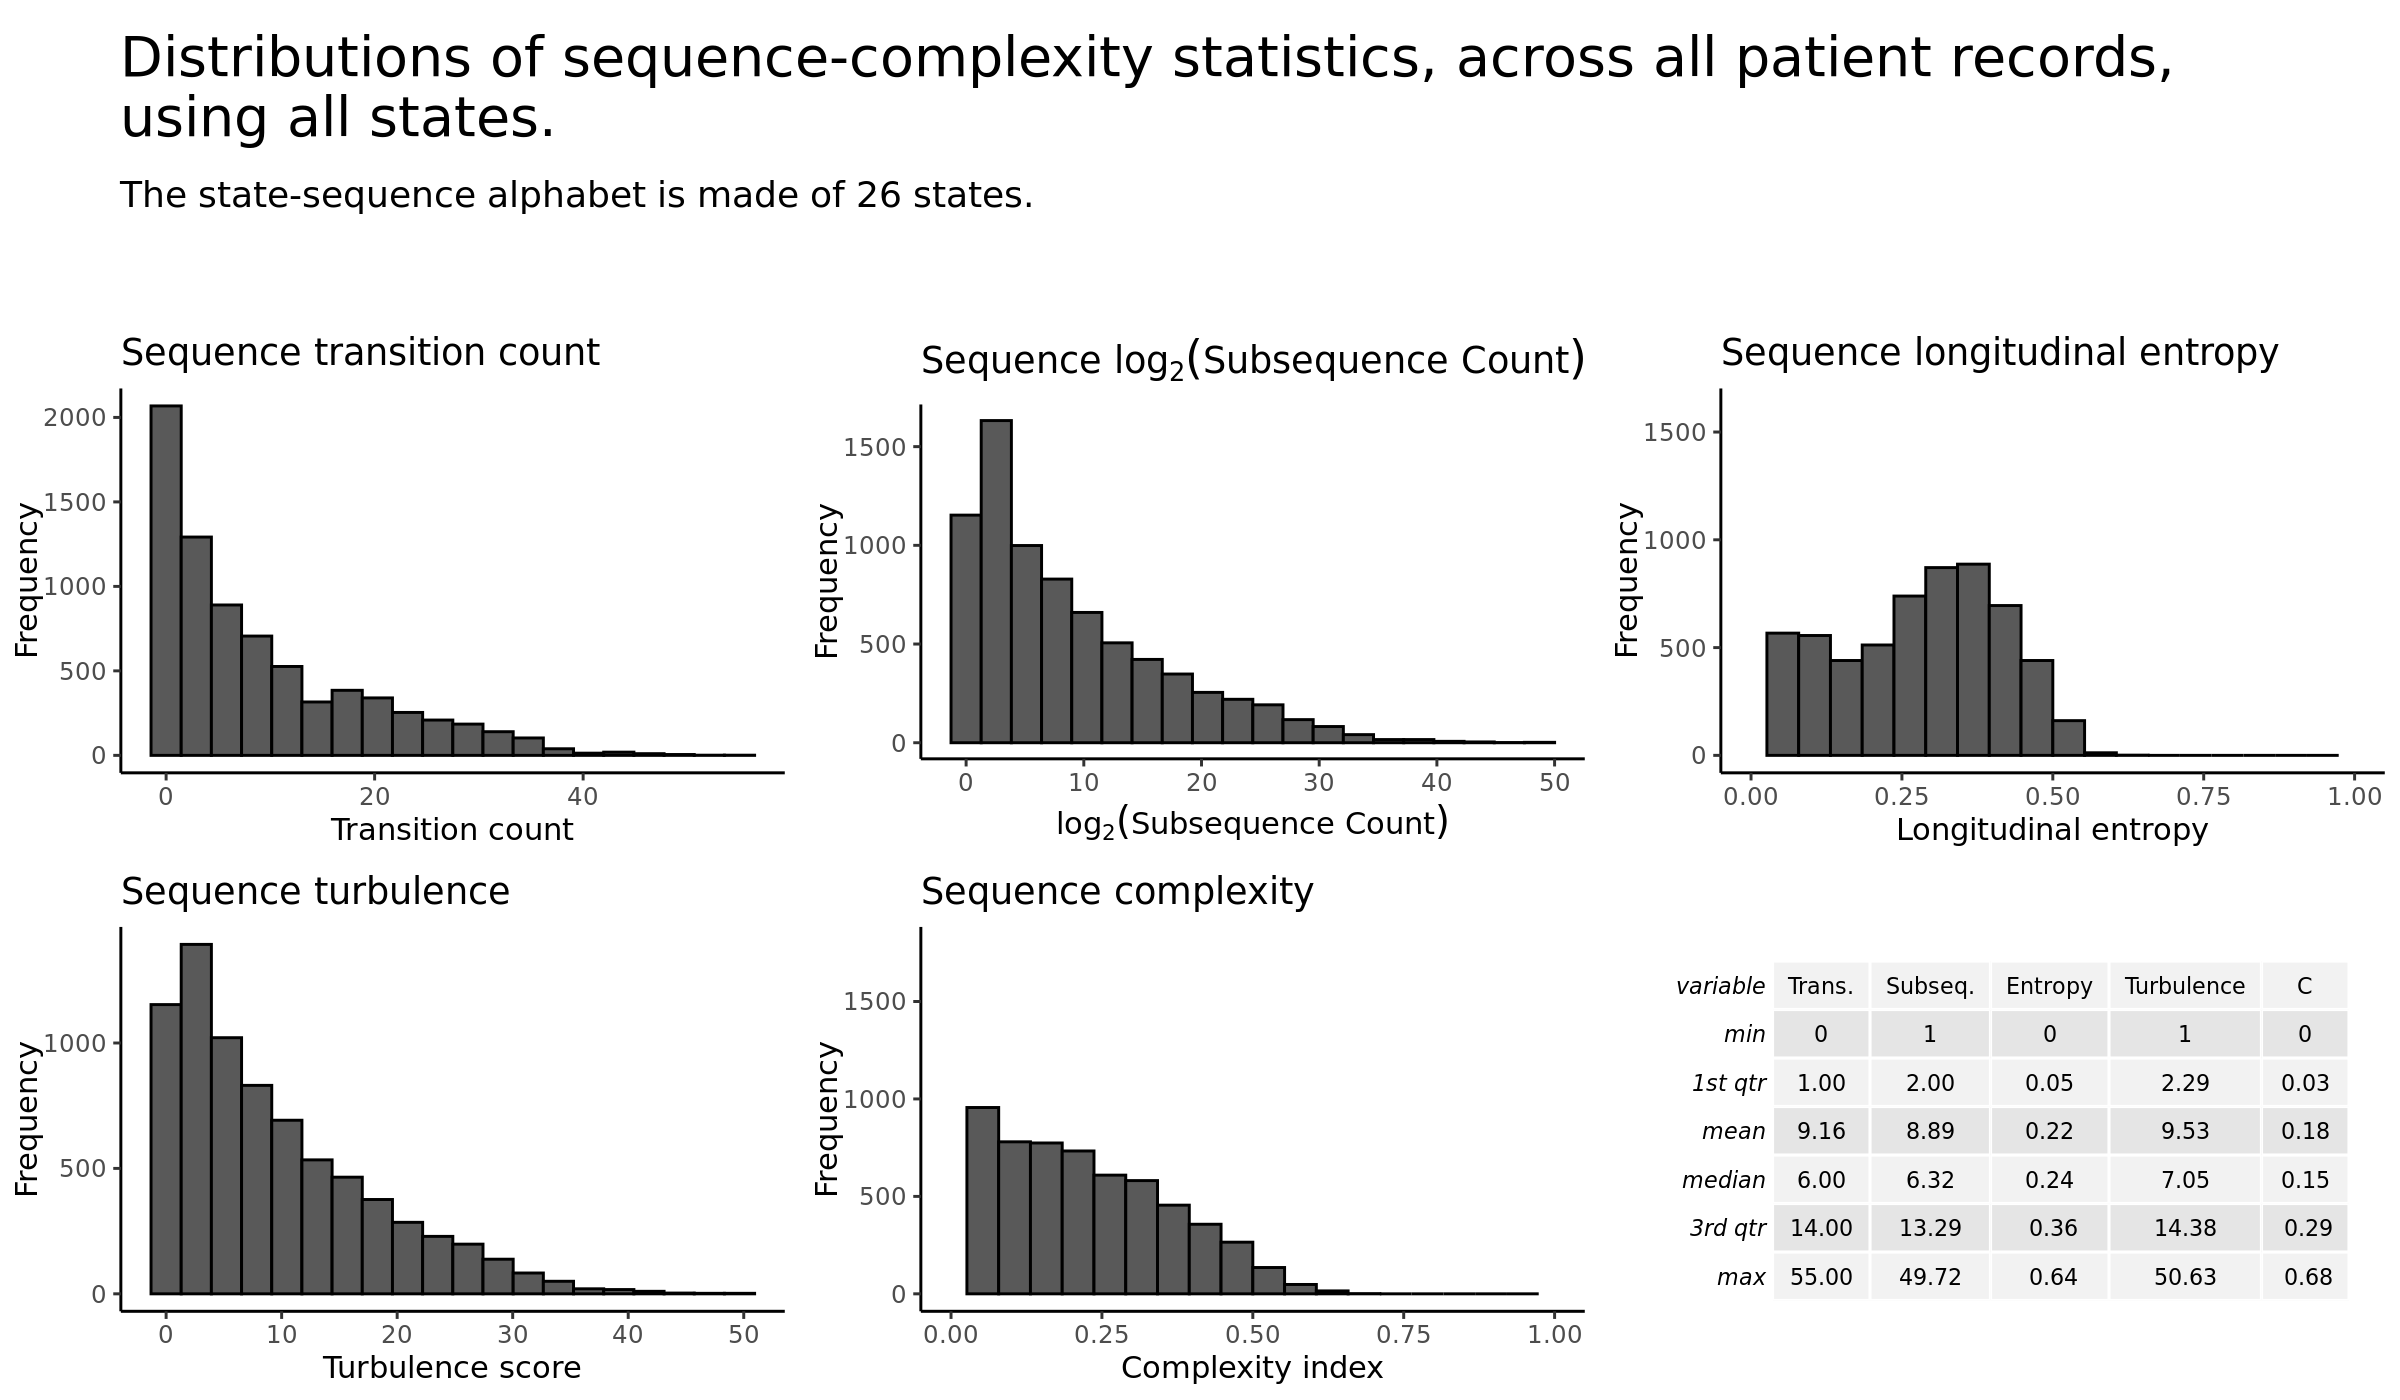

In [73]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_allStates <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine
                ,geom = "hist"
                ,title = "Distributions of sequence-complexity statistics, across all patient records,\nusing all states."
            )
        plot_sequenceComplexity_allStates
    }

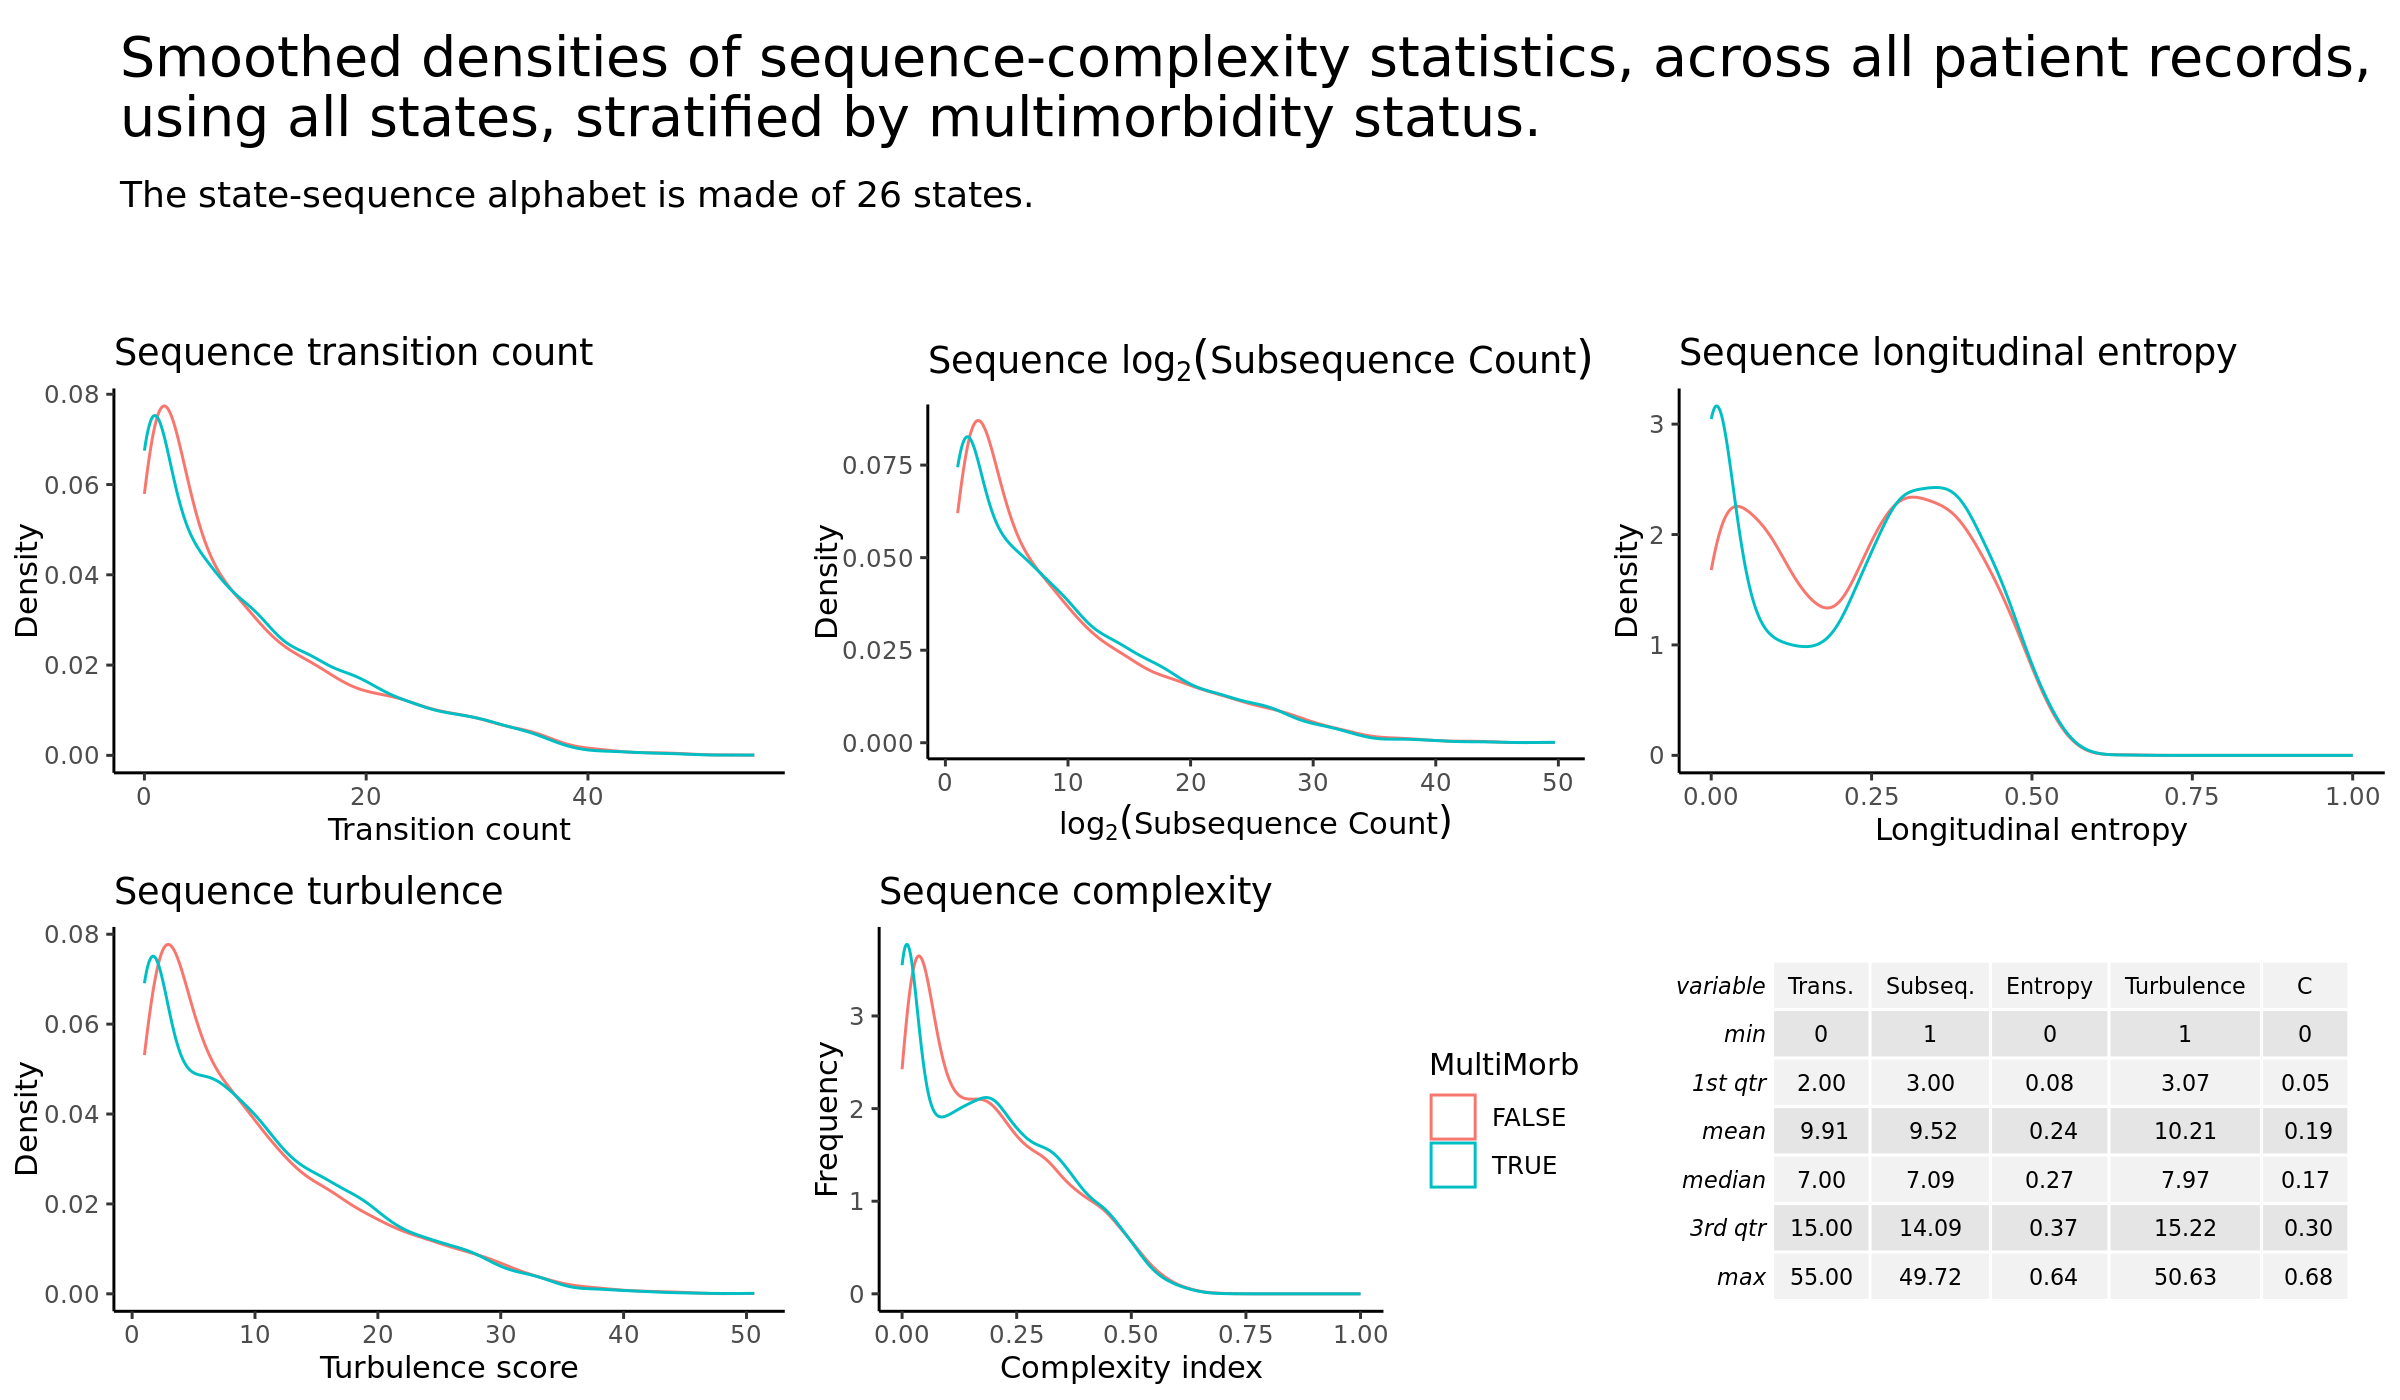

In [74]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_allStates_stratifiedByMultiMorb <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine
                ,geom = "density"
                ,strata = "MultiMorb"
                ,title = "Smoothed densities of sequence-complexity statistics, across all patient records,\nusing all states, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_allStates_stratifiedByMultiMorb
    }

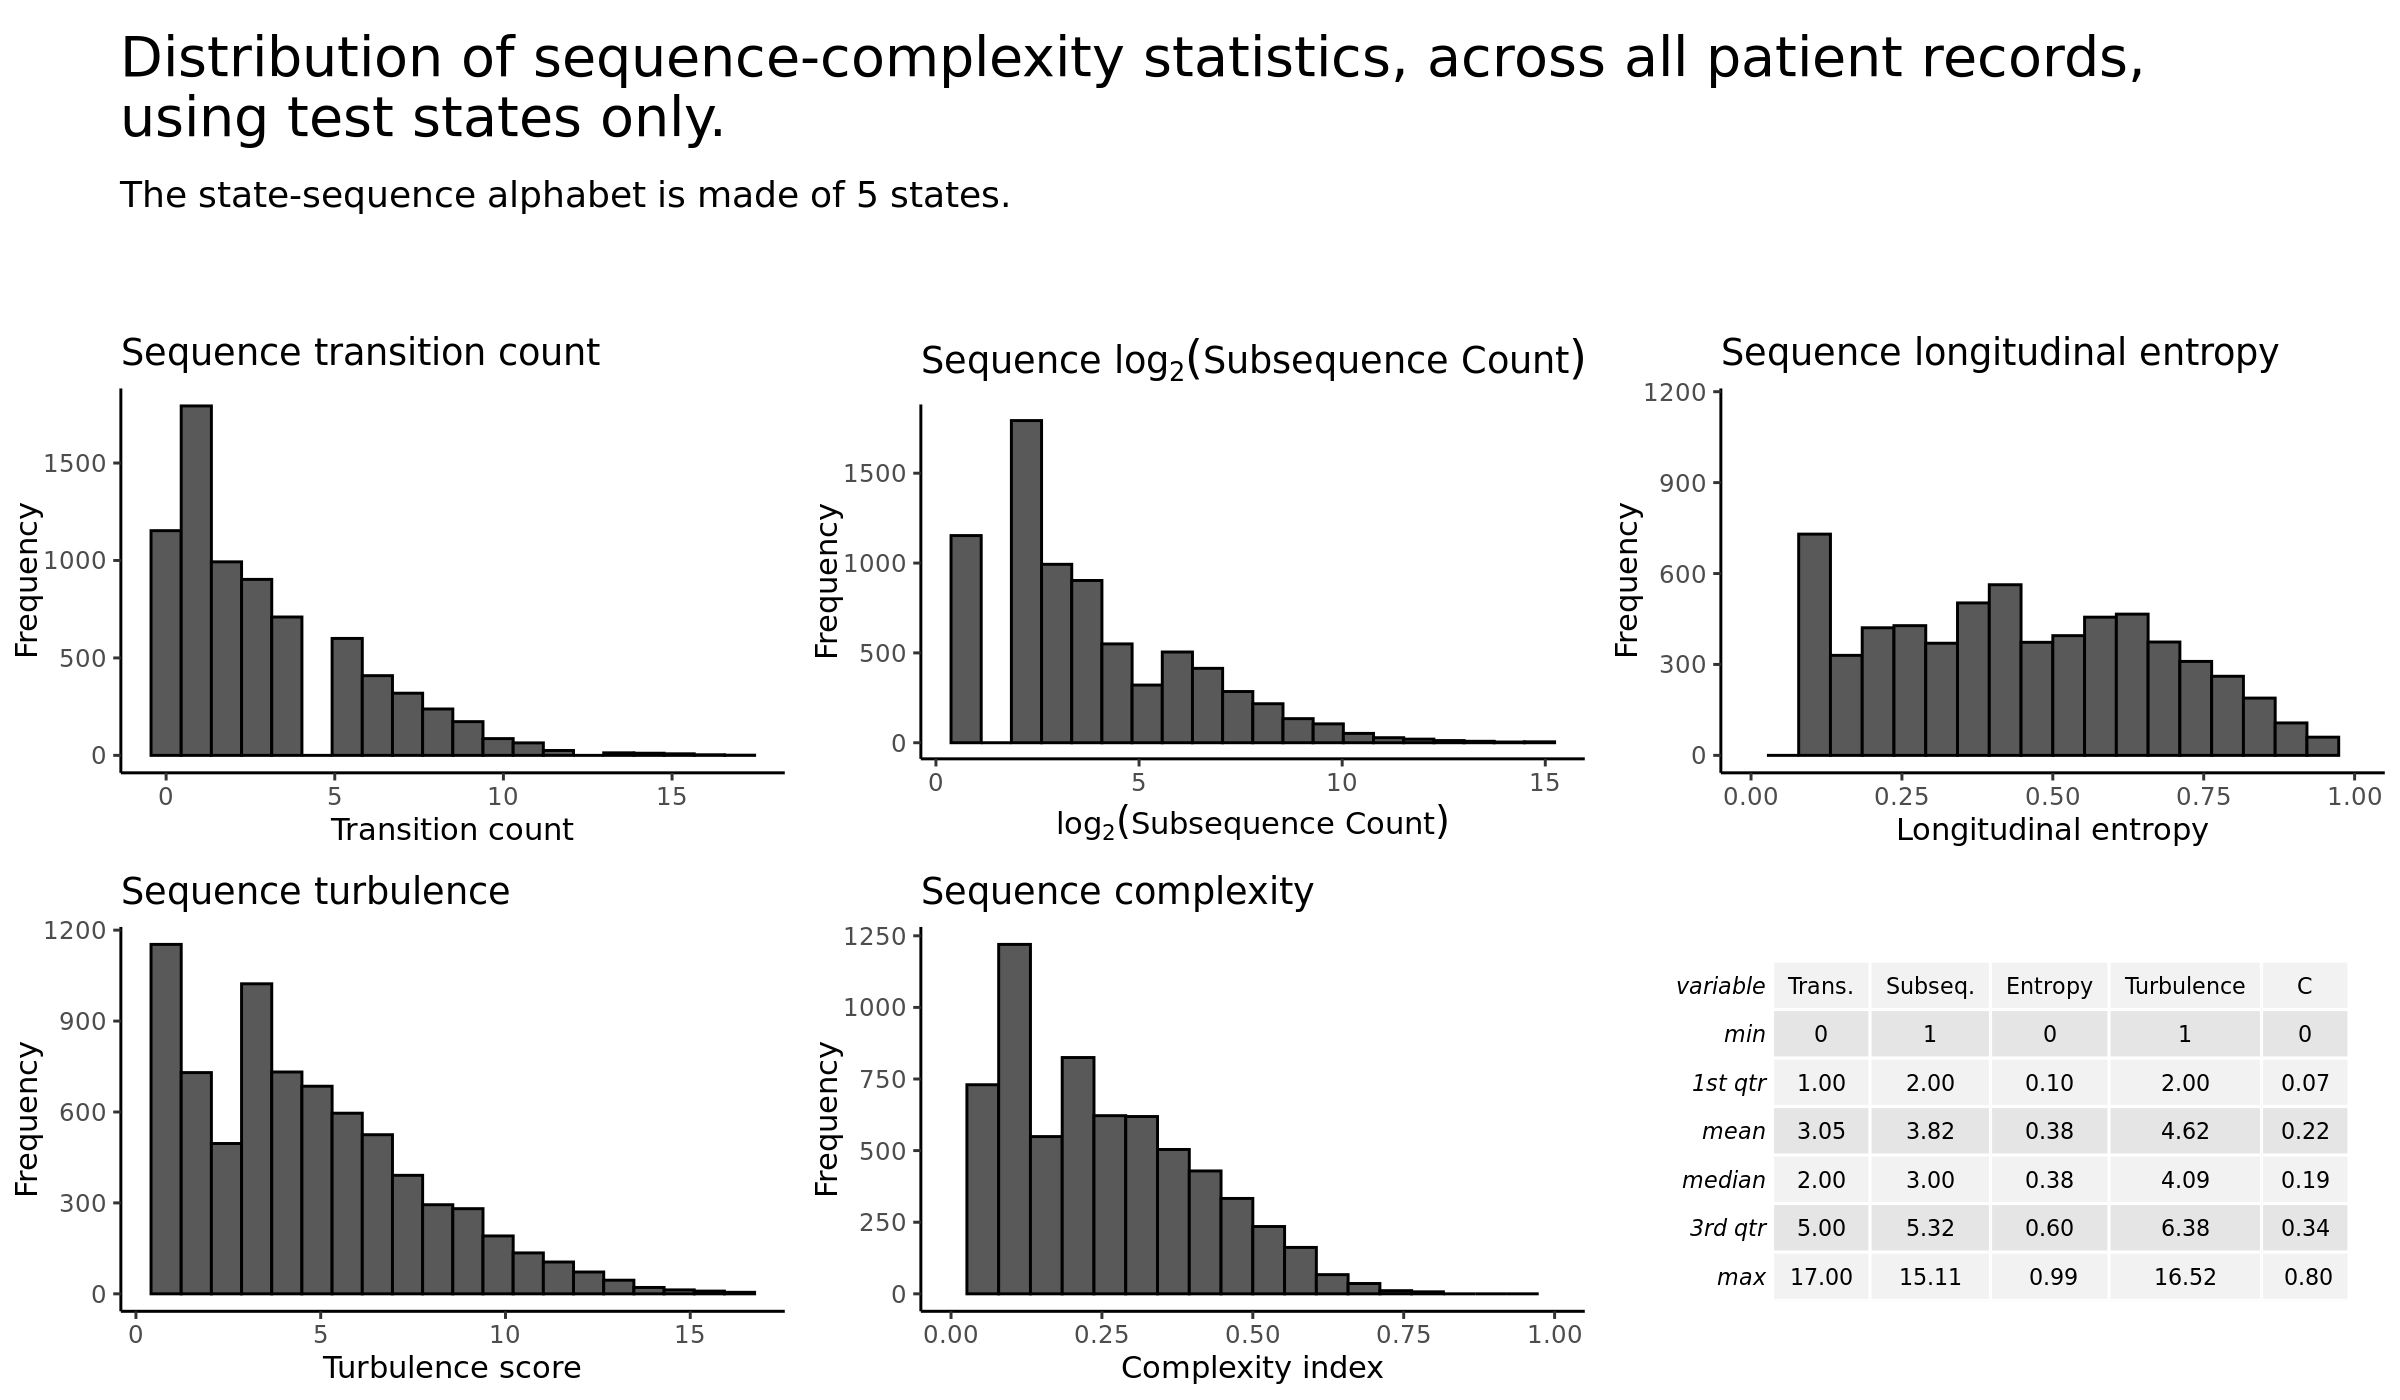

In [75]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_testStates <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_test_only
                ,geom = "hist"
                ,title = "Distribution of sequence-complexity statistics, across all patient records,\nusing test states only."
            )
        plot_sequenceComplexity_testStates
    }

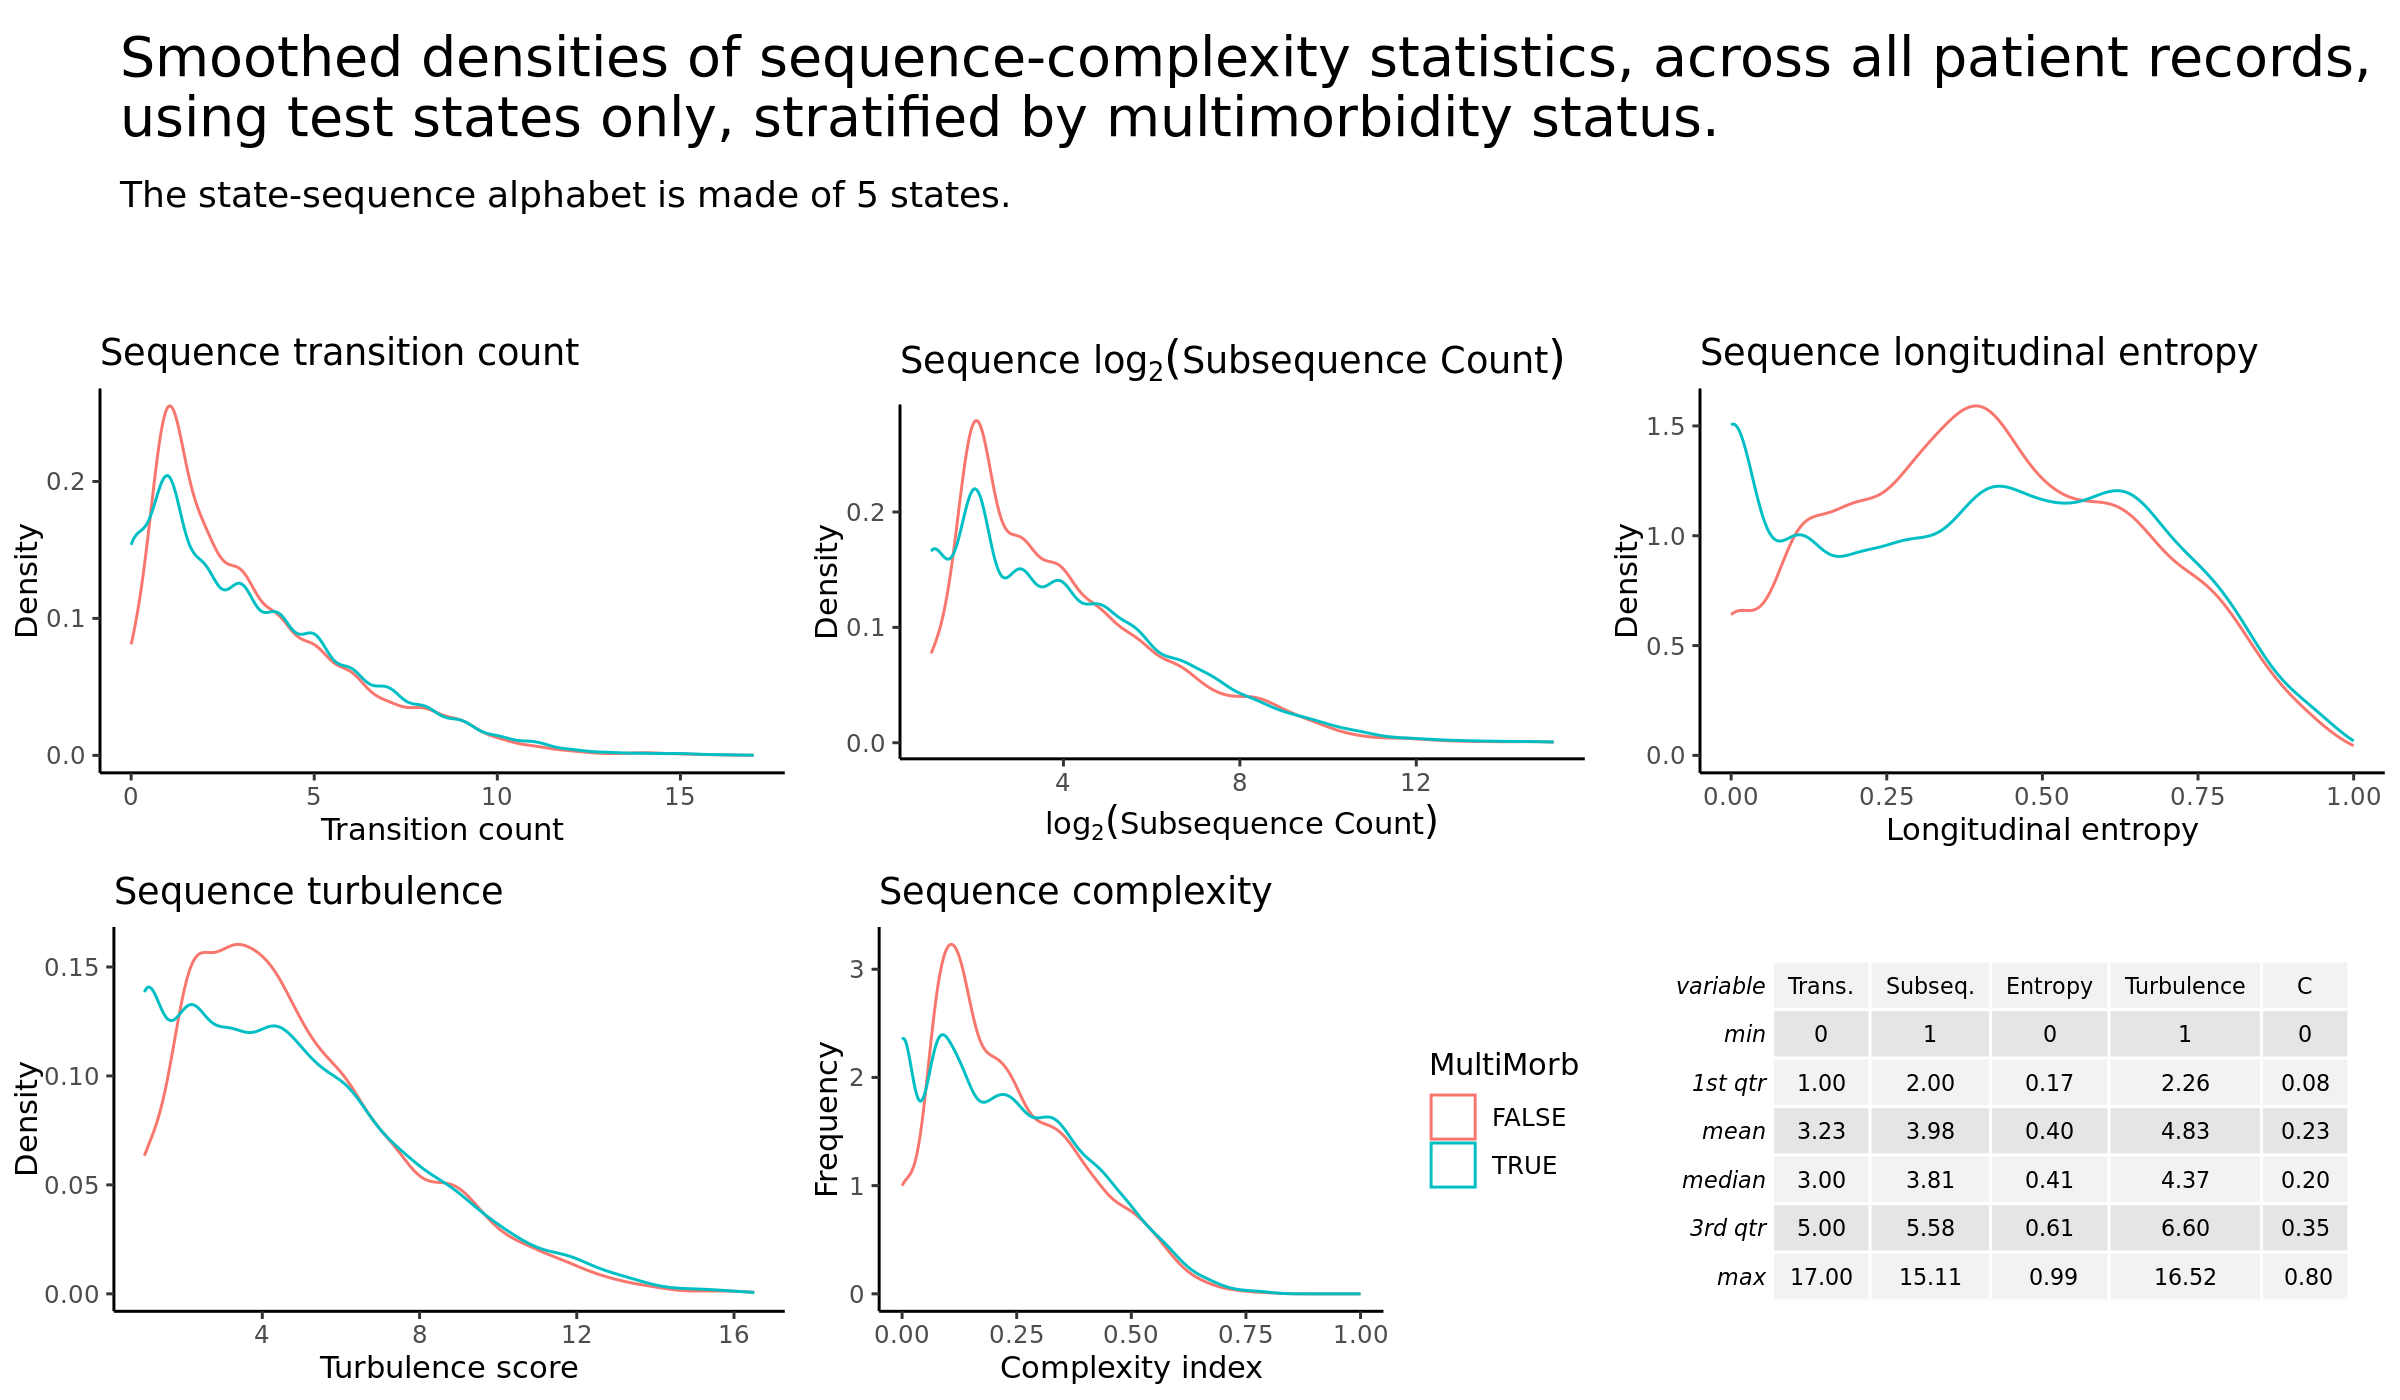

In [76]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_testStates_stratifiedByMultiMorb <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_test_only
                ,geom = "density"
                ,strata = "MultiMorb"
                ,title = "Smoothed densities of sequence-complexity statistics, across all patient records,\nusing test states only, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_testStates_stratifiedByMultiMorb
    }

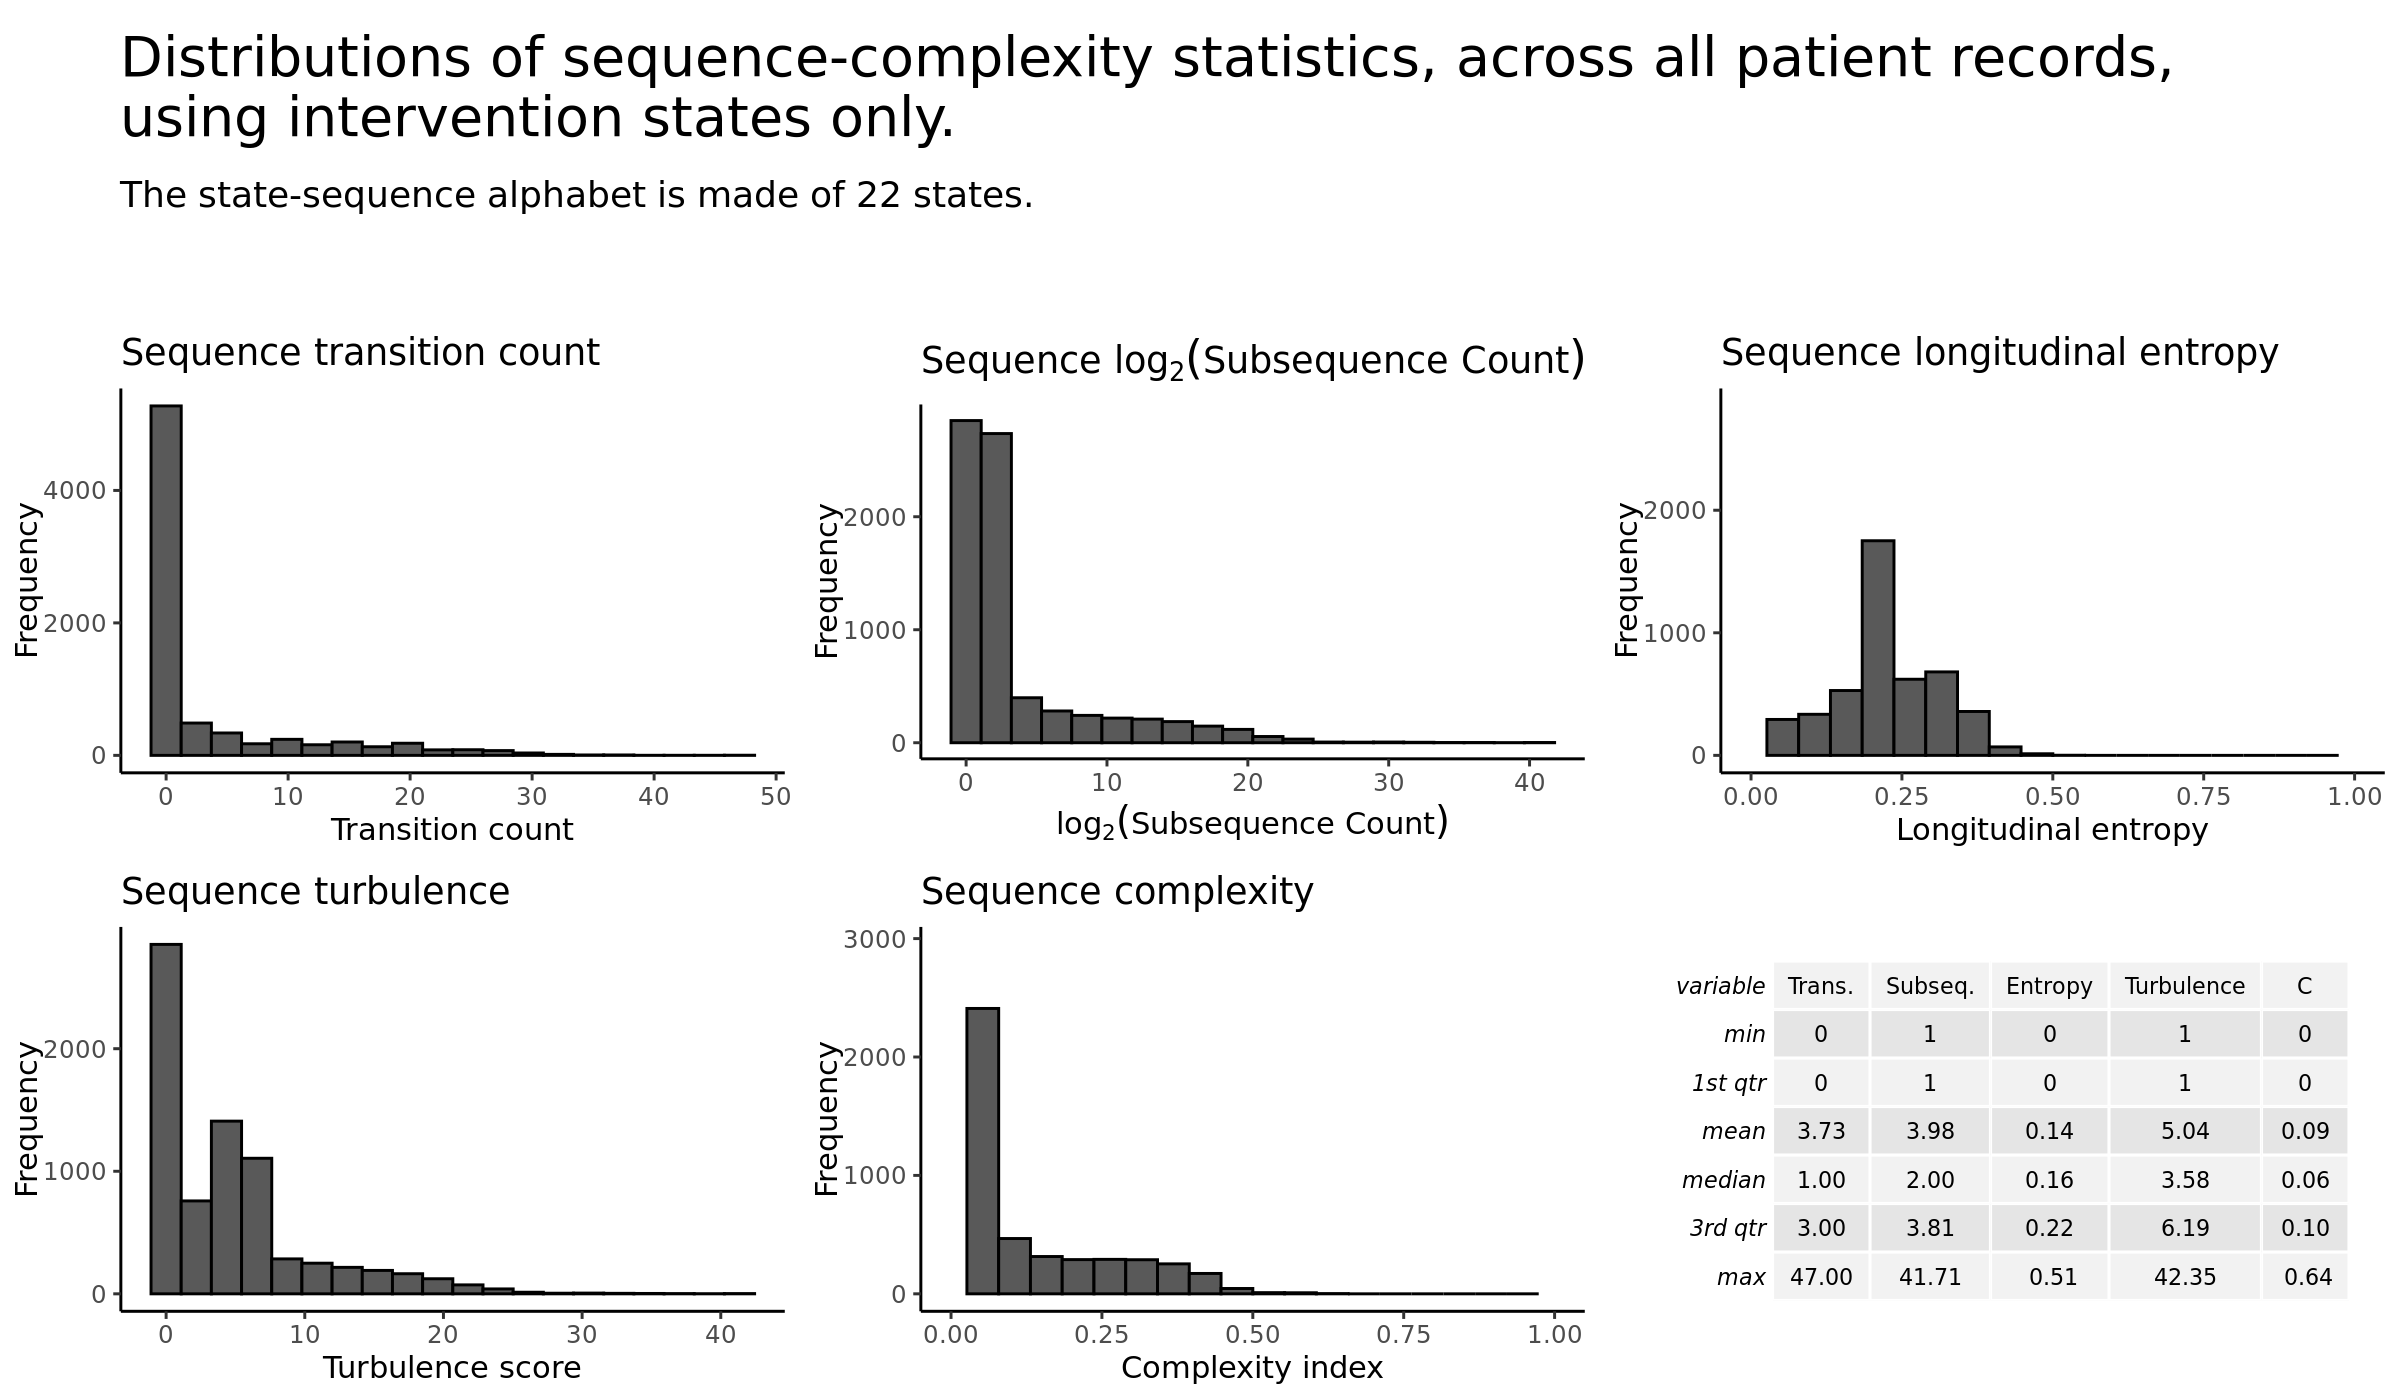

In [77]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_interventionStates <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_intervention_only
                ,geom = "hist"
                ,title = "Distributions of sequence-complexity statistics, across all patient records,\nusing intervention states only."
            )
        plot_sequenceComplexity_interventionStates
    }

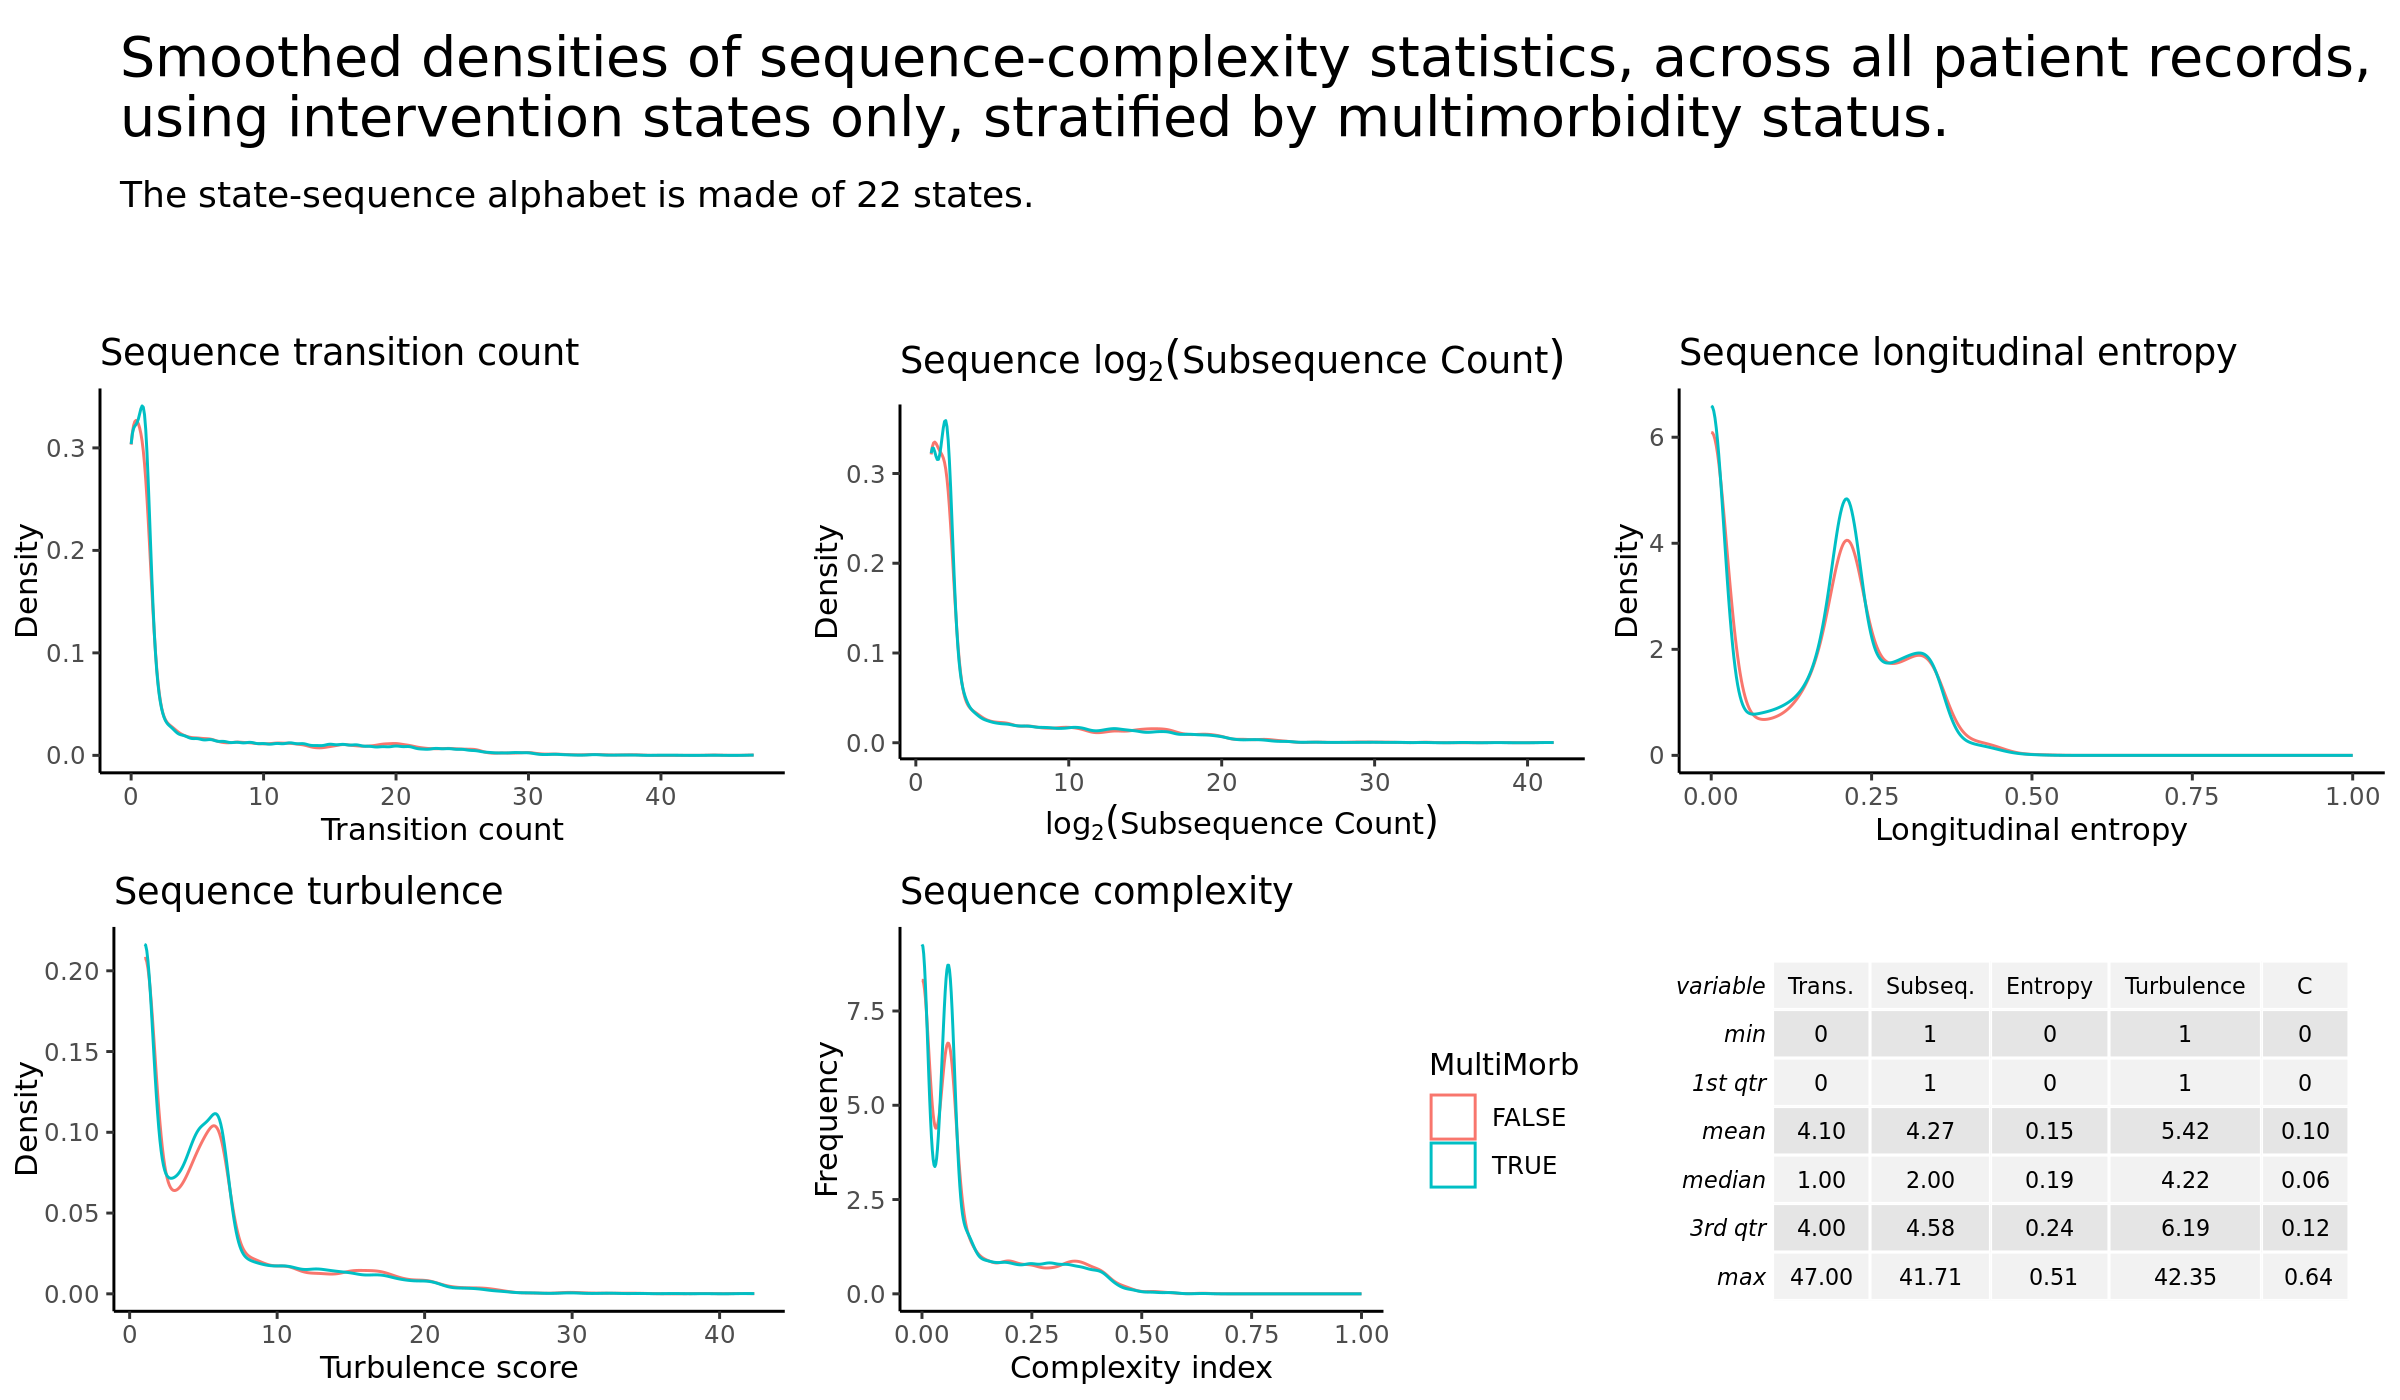

In [78]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_interventionStates_stratifiedByMultiMorb <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_intervention_only
                ,geom = "density"
                ,strata = "MultiMorb"
                ,title = "Smoothed densities of sequence-complexity statistics, across all patient records,\nusing intervention states only, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_interventionStates_stratifiedByMultiMorb
    }

Some initial observations of the distribution plots:
- Compared to the previous iteration where we looked at sequences from diagnosis, these sequences 10 years after diagnosis show less complexity.
    - Evidenced by a left shift in all histograms, for the plots pretaining to all events.
- Compared to the previous iteration where we looked at sequences from diagnosis, the complexity of test-status sequences is spread throughout the range, showing greater complexity, on average.
    - Evidenced by a right shift in all histograms, for the plots pretaining to test-status events.
- Compared to the previous iteration where we looked at sequences from diagnosis, the complexity of intervention sequences is similar.

### Sankey plots

<b>Note: The Sankey plots show data that are in <u>ST</u>ate <u>S</u>equence format. This means that:</b>
1. <b>the number of sequence steps is decided by the maximum number of sequence steps observed across the dataset, _and_</b>
2. <b>a state remains unchanged in the sequence by default, rather than records being lost to follow-up.</b>
<br>
<br>
<br>
<br>



#### Test Statuses
First, I show a basic Sankey plot showing patients' test results at each testing event and visualise the proportion of patient records that switch between test statuses.

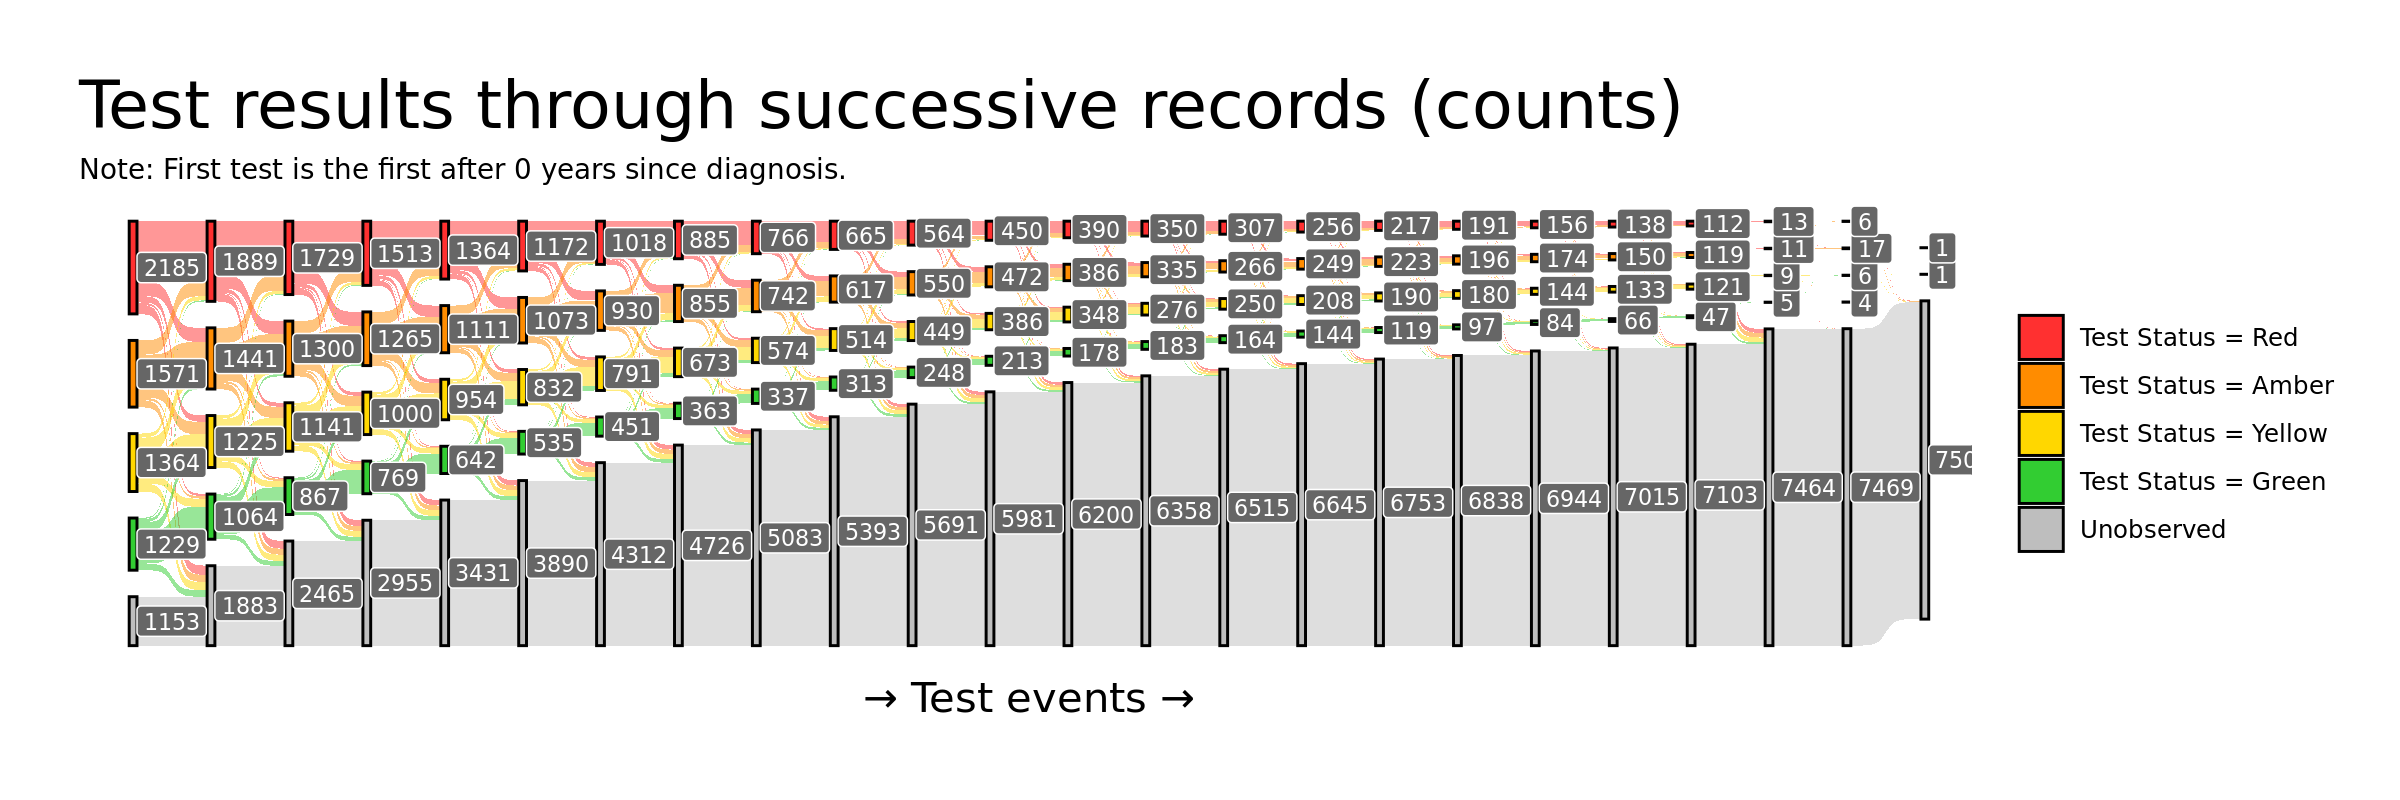

In [79]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_test_only %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # PLot.
        options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

        plot_testStatus_Sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
            ggsankey::geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat( paste0( freq ) )
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
            labs(
                title = "Test results through successive records (counts)"
                ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        plot_testStatus_Sankey
    }

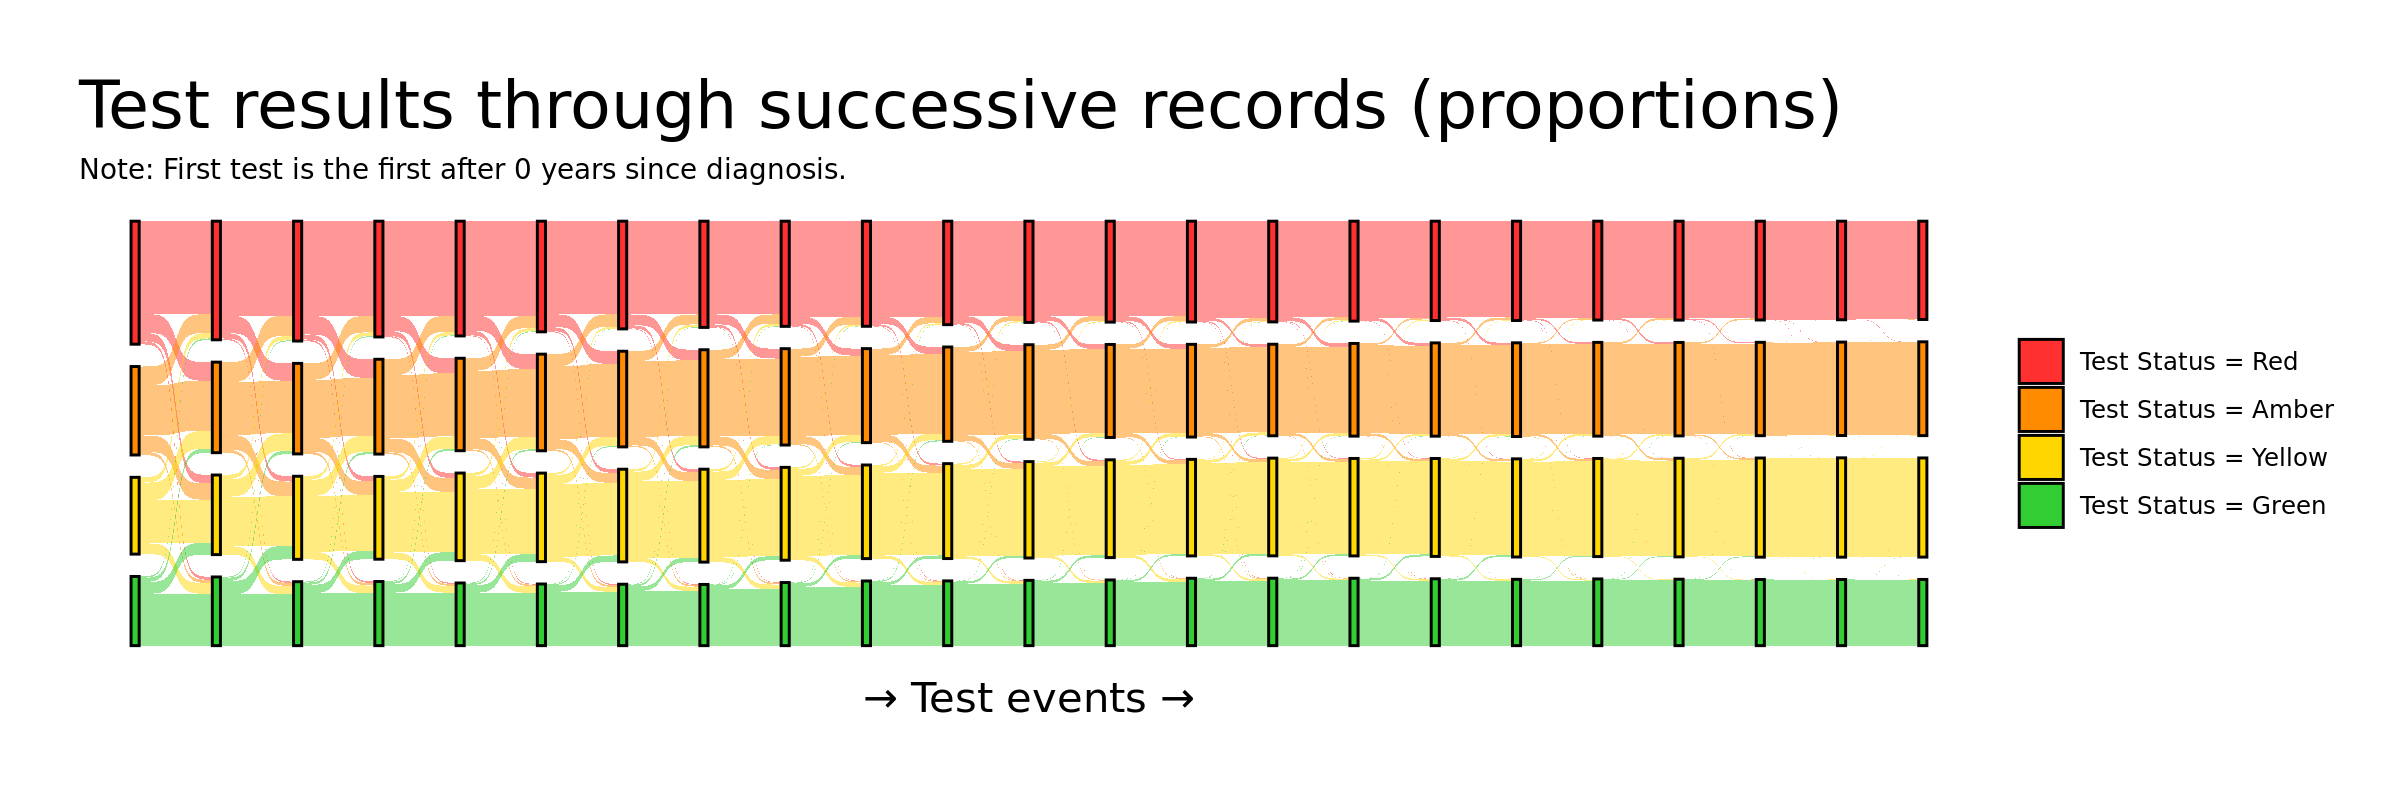

In [80]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_test_only_excludingUnobserved %>%
            dplyr::select( -last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # PLot.
        options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

        plot_testStatus_Sankey_excludingUnobserved <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
            scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
            labs(
                title = "Test results through successive records (proportions)"
                ,subtitle = paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        plot_testStatus_Sankey_excludingUnobserved
    }

Some initial observations from the Test Statuses Sankey diagram:
1. __The overall count of patient records in each level of Test Status is approximately stable.__
    - Evidenced by little variation in the height of the vertical bars, over time.
2. __Patient records indicating a particular Test Status level predominantly stay in that Test Status level.__
    - Evidenced by the largest ribbon joining subsequent vertical bars almost exclusively comes from the the same Test Status level.
3. __The Test Status levels that change between every test event rarely change by more than one level.__
    - Evidenced by many ribbons linking vertically-adjacent bars at subsequent test points.
4. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show an unchanging probability of changing test-status values between tests.__
    - Evidenced by a consistent size of ribbons joining different colours, as we move from left to right in the graphic.

In the meeting of the wider project team at the end of the previous iteration, there was a request to view how individual records progress between the strata of the variable (a.k.a. the lanes) and across the events. The plot below shows the progression of a randomly-selected group of records. The random selection is taken every time the plot is rendered, and the count of records being selected can be set with the `n_records_to_sample` pareameter at the start of the code block. Note that he veritcal 'jitter' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.

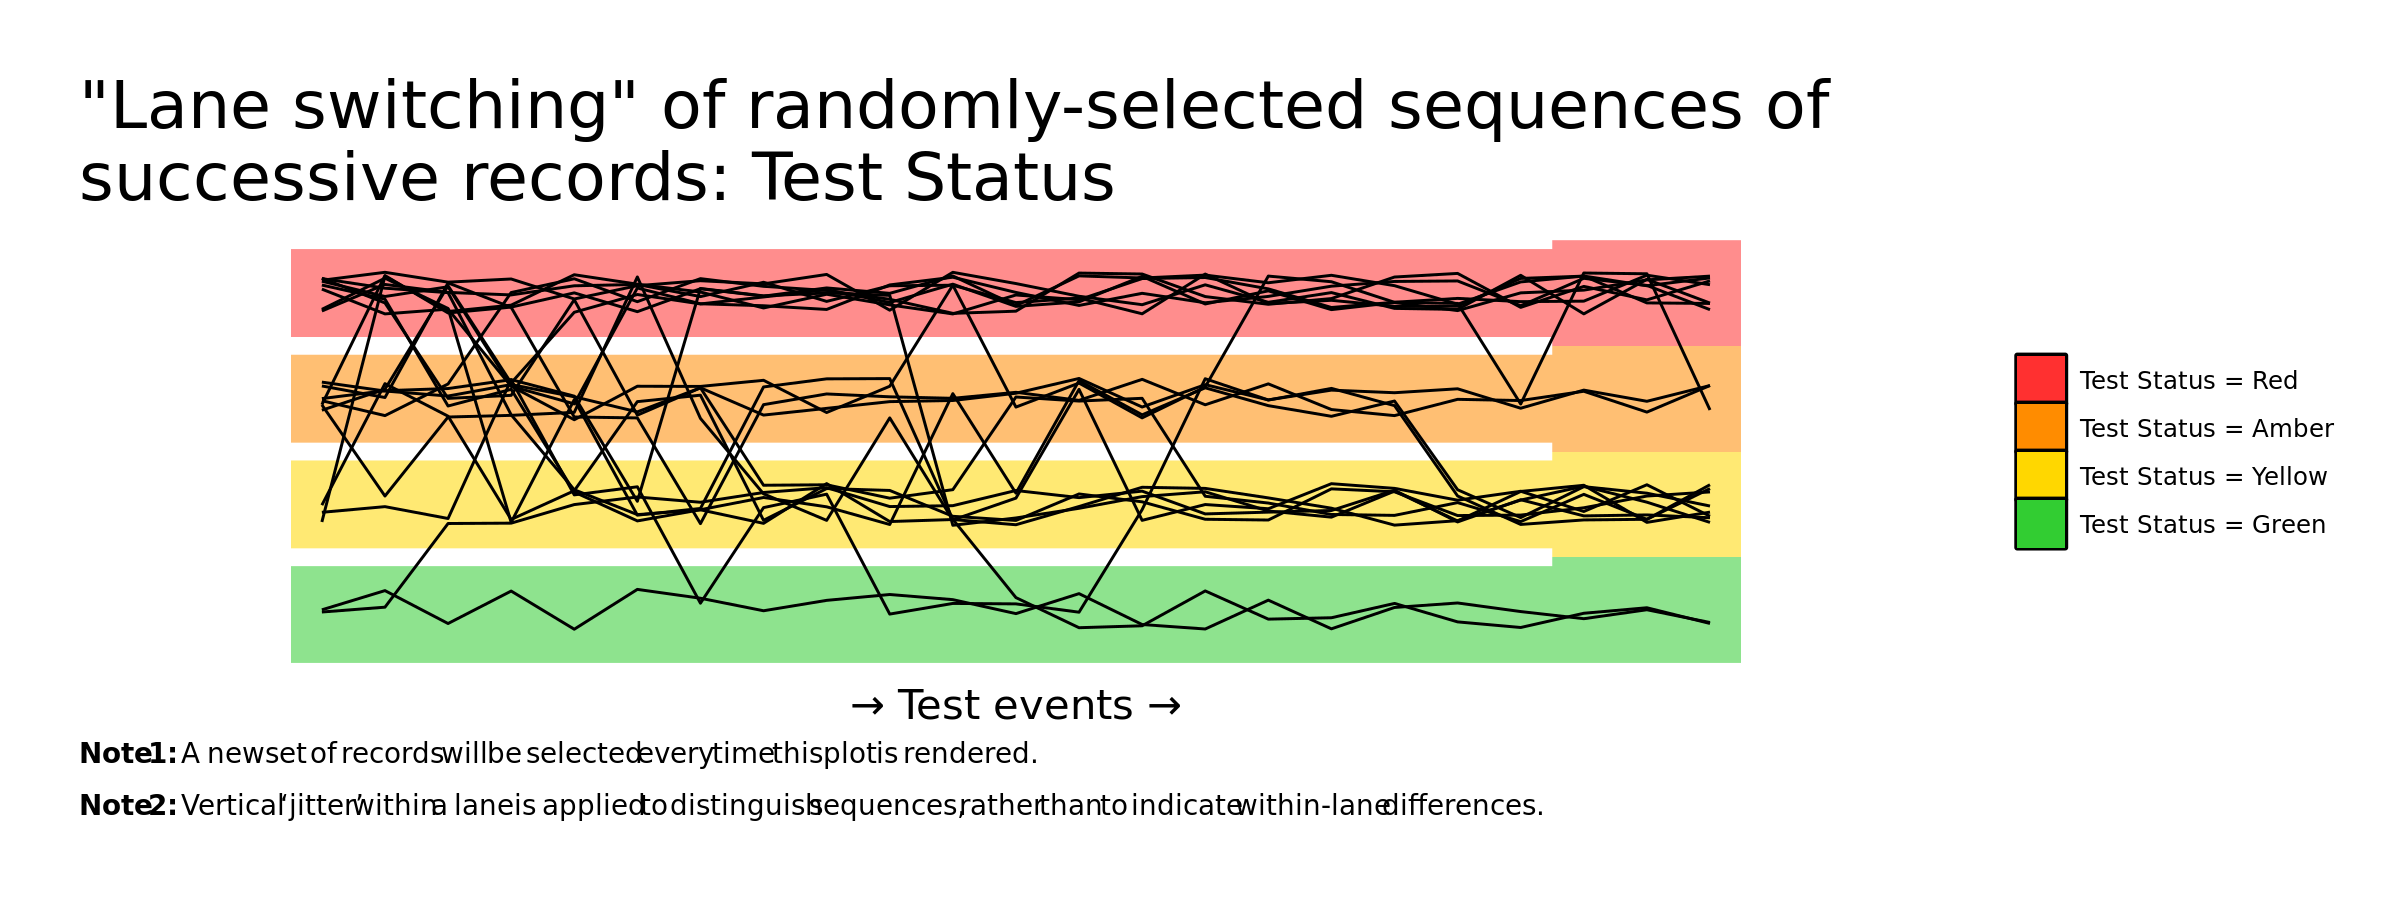

In [81]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 20

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_test_only_excludingUnobserved %>%
            dplyr::select( -last_col() ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            )  %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_event_factor %>%
            dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% #| event_fct_order == "Unobserved" ) %>%
            dplyr::select( event_fct_order ) %>%
            droplevels() %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Plot
        options( repr.plot.width = 12, repr.plot.height = 4.5, repr.plot.res = 200 )

        plot_laneSwitching_Tests <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 2.5, yend = 2.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 3.5, yend = 3.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 4.5, yend = 4.5, linewidth = 3, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences %>% dplyr::mutate( grp =  rep(1:n_records_to_sample, each = nrow( . ) / n_records_to_sample ) )
                ,aes(
                    x = variable
                    ,y = value
                    ,group = grp
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>%# | event_fct_order == "Unobserved" ) %>%
                dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull()
            ) +
            scale_alpha( guide = 'none' ) +
            labs(
                title = stringr::str_wrap( "\"Lane switching\" of randomly-selected sequences of successive records: Test Status", width = 60 )
                ,x = "\u2192 Test events \u2192"
                ,caption = 
                    paste0(
                        "**Note 1:** A new set of records will be selected every time this plot is rendered.\n\n"
                        ,"**Note 2:** Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,legend.box.margin = margin( t = 1, r = 1, l = 2, b = 1, unit =  "cm")
                ,legend.key = element_rect( colour = 'black', size = 1 )
                ,plot.margin = margin( t = 1, r = 0, l = 1, b = 1, unit =  "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_text( colour = 'white', size = 5)
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                ) %>%
            suppressWarnings()

        plot_laneSwitching_Tests
    }

In [82]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_test_only ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

sequence                         Freq Percent    cum_sum_percent
1  END                              1153 15.3692349 15.36923       
2  Test Status = Red for 1 → END     218  2.9058918 18.27513       
3  Test Status = Yellow for 1 → END  189  2.5193282 20.79445       
4  Test Status = Amber for 1 → END   167  2.2260730 23.02053       
5  Test Status = Green for 1 → END   156  2.0794455 25.09997       
6  Test Status = Red for 2 → END     128  1.7062117 26.80619       
7  Test Status = Green for 2 → END    79  1.0530525 27.85924       
8  Test Status = Red for 3 → END      72  0.9597441 28.81898       
9  Test Status = Yellow for 2 → END   62  0.8264463 29.64543       
10 Test Status = Amber for 2 → END    58  0.7731272 30.41856

#### H.M.A. strata

In the next plot, the Sankey plot visualises the proportions of patient records moving between strata of the H.M.A. stratification.

H.M.A. stratification is something CB proposed. It has four strata infomed by two components: the testing interval since the previous test {'Expected', 'Shorter-than-expected'}, and the change in prescriptions compared with the previous testing interval {'No observed change', 'Observed change'}. The stratification gets its name from the four strata: (0,0)-Run; (1,0)-Monitor; (0 or 1,1)-Adjust.

The first task is to create a new state-sequence object that tracks H.M.A. strata.

In [4]:

##########################
# Check for reequisites. #
##########################
if( !exists( "df_log_PandT_longFormat" ) )
    {
    run_cohort_generator <- readline("It looks like `RESHAPE_cohort_generator.R has not been run\nDo you want to run `RESHAPE_cohort_generator.R`? [Y, N]")
    if( run_cohort_generator == "Y"){ source( 'RESHAPE_cohort_generator.r' ) }
}


####################
# Format the data. #
####################
# I create the simplified dataframe object from the first iteration.
df_log_PandT_longFormat_simplified <-
    df_log_PandT_longFormat %>%
    # Remove the numbers in the event name.
    dplyr::mutate_at(
        .vars = vars( event_name )
        ,.funs = ~ gsub( "_*[0-9]", "", . )
    )

# Convert to factor. # This becomes too unwieldy if I don't substantially amalgamate the drugs.
if( ( df_log_PandT_longFormat_simplified %>% dplyr::select( event_value ) %>% unique() %>% nrow() ) < 36 )
    {
    df_log_PandT_longFormat_simplified <-
        df_log_PandT_longFormat_simplified %>%
        dplyr::mutate(
            event_value = 
                    factor(
                        event_value
                        ,levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull()
                    )
            )
    } else { 
    message("\nNOTE: Prescriptions were not converted to factor type because there are too many.\n         Consider amalgamating them.")
    }

# Before I can begin analysing the data, I need to define the strata proposed by the Clinical Review Board.
# The stratifications were:
# - H.M.A.: Four strata defined by combinations of {'Expected', 'Shorter-than-expected'} testing intervals
#   and {'No observed change', 'Observed change'} in prescriptions. The H.M.A. acronym derives from the three
#   strata: (0,0)-Hold; (1,0)-Monitor; (0 or 1, 1)-Adjust.
# - Tests-and-Interventions: Twelve strata defined by combinations of the test statuses and whether the patient
#   is on one, two or three medications simulatneously.
# - Multimorbidity: Two strata defined by whether or not there is a record for at least one of the
#   multimorbidity diagnositic codes.
#
# The first thing I do is to add a variable that indicates the patient-specific test interval. This will be
# handy for bounding the variables I need to create.
                      
# Create a variable that indicates patient-specific test interval.
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified %>%
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm ) %>%
    dplyr::mutate(
        idx_test_interval = 0 + cumsum( stringr::str_detect( event_value, pattern = "Test" ) )
    ) %>% 
    dplyr::ungroup() %>%
    # Remove any calculated `idx_test_interval` for which the `event_value` is "Unobserved".
    dplyr::mutate(
        idx_test_interval =
            dplyr::if_else( event_value == "Unobserved", NA_integer_, idx_test_interval )
    ) %>%
    # Tidy up.
    dplyr::distinct() %>%
    dplyr::arrange( person_id, start_dttm )


# Append an age column.
df_age <-
    r_tbl_srpatient %>%
    # Select only those patients in whom we are interested.
    dplyr::inner_join( qry_records_with_T2DM_diagnoses, by = join_by( person_id ) ) %>%
    dplyr::distinct( person_id, datebirth ) %>% 
    dplyr::collect() %>%
    tidyr::separate(
        col = datebirth
        ,sep = 4
        ,into = c( "birth_year", "birth_month" )
    ) %>%
    dplyr::mutate(
        DOB = 
            dplyr::if_else(
                is.na( birth_year )
                ,NA
                ,ISOdate( year = birth_year, month = birth_month, day = 1, hour = 0 )
            )
    ) %>%
    # If there are multiple dates of death, chose the earliest one.
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( DOB = min( DOB, na.rm = TRUE ) ) %>%
    dplyr::ungroup() %>% 
    tidyr::drop_na() %>%
    # Tidy up.
    dplyr::distinct( person_id, DOB ) %>%
    dplyr::arrange( person_id ) %>%
    suppressWarnings() 

df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::left_join(
        df_age
        ,by = join_by( person_id )
        ,relationship = 'many-to-one'
    ) %>%
    dplyr::mutate(
        Age = lubridate::interval( DOB, start_dttm ) / lubridate::years( 1 )
    )


# Include the date of diagnosis.
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::group_by( person_id ) %>%
    dplyr::group_modify( ~ tibble::add_row( .x ), .by = person_id ) %>% 
    dplyr::left_join( qry_records_with_T2DM_diagnoses %>% collect(), by = join_by( person_id ) ) %>%
    dplyr::mutate( start_dttm = if_else( is.na( start_dttm ), date_diagnosis , start_dttm ) ) %>%
    dplyr::arrange( person_id, start_dttm ) %>%
    dplyr::mutate(
        end_dttm = dplyr::if_else( is.na( end_dttm ), lead( start_dttm ), end_dttm )
        ,event_name = dplyr::if_else( is.na( event_value ), "diagnosis", event_name )
    ) %>%
    dplyr::ungroup() 


#########################
# H.M.A. stratification #
#########################
#
# The two components of this stratification are the testing interval and the change in prescription. The testing
# interval requries me to create a variable indicating that the inter-test duration was between
# `val_testing_interval_LB` and `val_testing_interval_UB`. The change-in-prescription criterion refers to 
# whether a new medication-dose set was prescribed, where "new" means not seen in the previous three months.
#
# The first thing is to calculate the inter-test duration. In this iteration, I will have to ignore the interval
# between the diagnostic test and the subsequent test because I am deliberately looking at records ten years
# after the diagnostic test.
                      
df_inter_test_duration <-
    qry_log_test_longFormat %>%
    dplyr::collect() %>%
    # Include the date of diagnosis.
    dplyr::group_by( person_id ) %>%
    dplyr::group_modify( ~ tibble::add_row( .x ), .by = person_id ) %>% 
    dplyr::left_join( qry_records_with_T2DM_diagnoses %>% collect(), by = join_by( person_id ) ) %>%
    dplyr::mutate( start_dttm = if_else( is.na( start_dttm ), date_diagnosis , start_dttm ) ) %>%
    dplyr::arrange( person_id, start_dttm ) %>%
    dplyr::mutate(
        end_dttm = dplyr::if_else( is.na( end_dttm ), lead( start_dttm ), end_dttm )
        ,event_name = dplyr::if_else( is.na( event_value ), "diagnosis", event_name )
    ) %>%
    dplyr::ungroup() %>%
    # Calculate the duration between each test and the next.
    dplyr::mutate( inter_test_duration_cont = lubridate::interval( start_dttm, end_dttm ) %>% `/`( months(1) ) ) %>% 
    # Create a discretised version of the inter-test duration variable.
    dplyr::mutate(
        inter_test_duration_discr =
            dplyr::if_else(
                ( inter_test_duration_cont > val_testing_interval_LB ) & ( inter_test_duration_cont < val_testing_interval_UB )
                ,"Shorter than expected"
                ,"As expected"
            )
    ) %>% 
    # Make any same-day tests or anomalies = NA.
    dplyr::mutate(
        inter_test_duration_discr =
             dplyr::if_else(
                 is.na( inter_test_duration_cont )
                 ,"Not applicable"
                 ,inter_test_duration_discr
             )
    ) %>%
    # Tidy up.
    arrange( person_id, start_dttm ) %>%
    dplyr::select( c( person_id, start_dttm, inter_test_duration_cont, inter_test_duration_discr ) ) %>% 
    dplyr::distinct() %>% dplyr::arrange(person_id, start_dttm)

# Add the new variable to the dataframe.
df_log_PandT_longFormat_simplified_StrataLabels <-
    # Join the variable indicating the inter-test duration.
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::left_join(
        df_inter_test_duration 
        ,by = join_by( person_id, start_dttm )
        ,relationship = "many-to-many"
        # The `relationship` argument is needed because a warning is raised for the situations
        # where multiple prescriptions are given on the same day.
    ) %>%
    # Fill in the values of the inter-test variables into subsequent rows until a new value is given.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm ) %>%
    tidyr::fill( inter_test_duration_cont ) %>%
    tidyr::fill( inter_test_duration_discr ) %>%
    dplyr::mutate( inter_test_duration_cont = dplyr::if_else( inter_test_duration_discr == "Not applicable", NA_real_, inter_test_duration_cont ) ) %>%
    dplyr::ungroup()

In [54]:
# The logic behind defining 'Adjust' is as follows.
# 1. note down all the preparations within an inter-test interval.
# 2. compare these preparations with the preparations that were record before the inter-test interval in question. Only look backward by an interval defined by `HMA_adjust_lookBack_window`.
# 3. if the preparation that was noted within the inter-test interval is not seen in the set of preparations that came before, then this inter-test-interval preparation is novel and, thus, labelled as an adjustment.

a<-
df_log_PandT_longFormat_simplified_StrataLabels %>% filter(person_id %in% c(519, 1144)) %>%
    # Create new columns that contain the test events and the prescription events.
    dplyr::select( person_id, start_dttm, event_value, idx_test_interval ) %>%
    dplyr::mutate(
        tempCol_tests = dplyr::if_else( stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
    ) %>%
    dplyr::mutate(
        tempCol_prescrps = dplyr::if_else( !stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
    ) %>%
    # Fill the test column until a new value is given.
    dplyr::arrange( person_id, start_dttm, tempCol_tests, tempCol_prescrps ) %>%
    tidyr::fill( tempCol_tests ) %>%
    # Remove repeated prescriptions within an inter-test period.
    dplyr::distinct() #%>%

b<-
 a %>%
    # Pivot wider so that each row represents an inter-test period. Order within the grouping doesn't matter because
    # I'm just collecting the set of prescriptions rather than the sequence of them.
    dplyr::select( person_id, idx_test_interval, tempCol_prescrps ) %>%
    dplyr::group_by( person_id, idx_test_interval ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    tidyr::pivot_wider(
        names_from = rn
        ,values_from = tempCol_prescrps
        ) %>%
    # List-concatonate the repeated prescriptions into one string.
    tidyr::unite(
        col = "meds_set"
        ,dplyr::select(
            .
            ,- c( 'person_id', 'idx_test_interval' )
        ) %>% colnames()
        ,sep = " , "
        ,na.rm = TRUE
    ) %>% 
    # Collate all the preparations within an inter-test interval.
    dplyr::rowwise() %>%
    dplyr::mutate(
        meds_set = meds_set %>% strsplit( split = " , ", fixed = TRUE ) %>% unlist() %>% unique() %>% sort() %>% paste( collapse = " , " )
    ) %>%
    dplyr::ungroup() %>% 
    # Join the `med_sets` to the main table.
    dplyr::right_join(
        a
        ,by = join_by( person_id, idx_test_interval )
    ) %>%
    # Remove unnecessary columns.
    dplyr::select( -c( event_value, tempCol_prescrps ) ) %>%
    dplyr::distinct() %>% filter(person_id == 1144)



###############################
###############################
###############################
#I need to figure out how to rowwise append the windowed history of `meds_set` to the main table.
################################
###############################
###############################
pid<-1144
#(windows_df_temp <- data.frame(  meds_set_window = character(), rn = integer(), person_id = integer()))
#for( pid in unique( b$person_id ) )
 #   {
       
        b %>%
        dplyr::filter( person_id == pid ) %>% arrange(start_dttm) %>%
        dplyr::mutate(
            meds_set_window = 
        slider::slide_index_dfr( .x = .$meds_set, .i = .$start_dttm, .f = ~.x %>% unlist() %>% unique() %>% list(), .before = HMA_adjust_lookBack_window )
            )#%>%
        purrr::map( .f = unique )
    unlist() %>%
        cbind( 1:length( . ), rep(pid, length( . ) ) ) %>%
        as.data.frame() %>%
        dplyr::mutate( across( c( V2, V3 ), ~unlist(.) %>% as.integer() ) ) %>%
        `colnames<-`( c("meds_set_window", "rn", "person_id") ) 

#    }
#windows_df_temp


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
ERROR while rich displaying an object: Error in data.frame(..., check.names = FALSE): argu

ERROR: Error in purrr::map(.f = unique): argument ".x" is missing, with no default


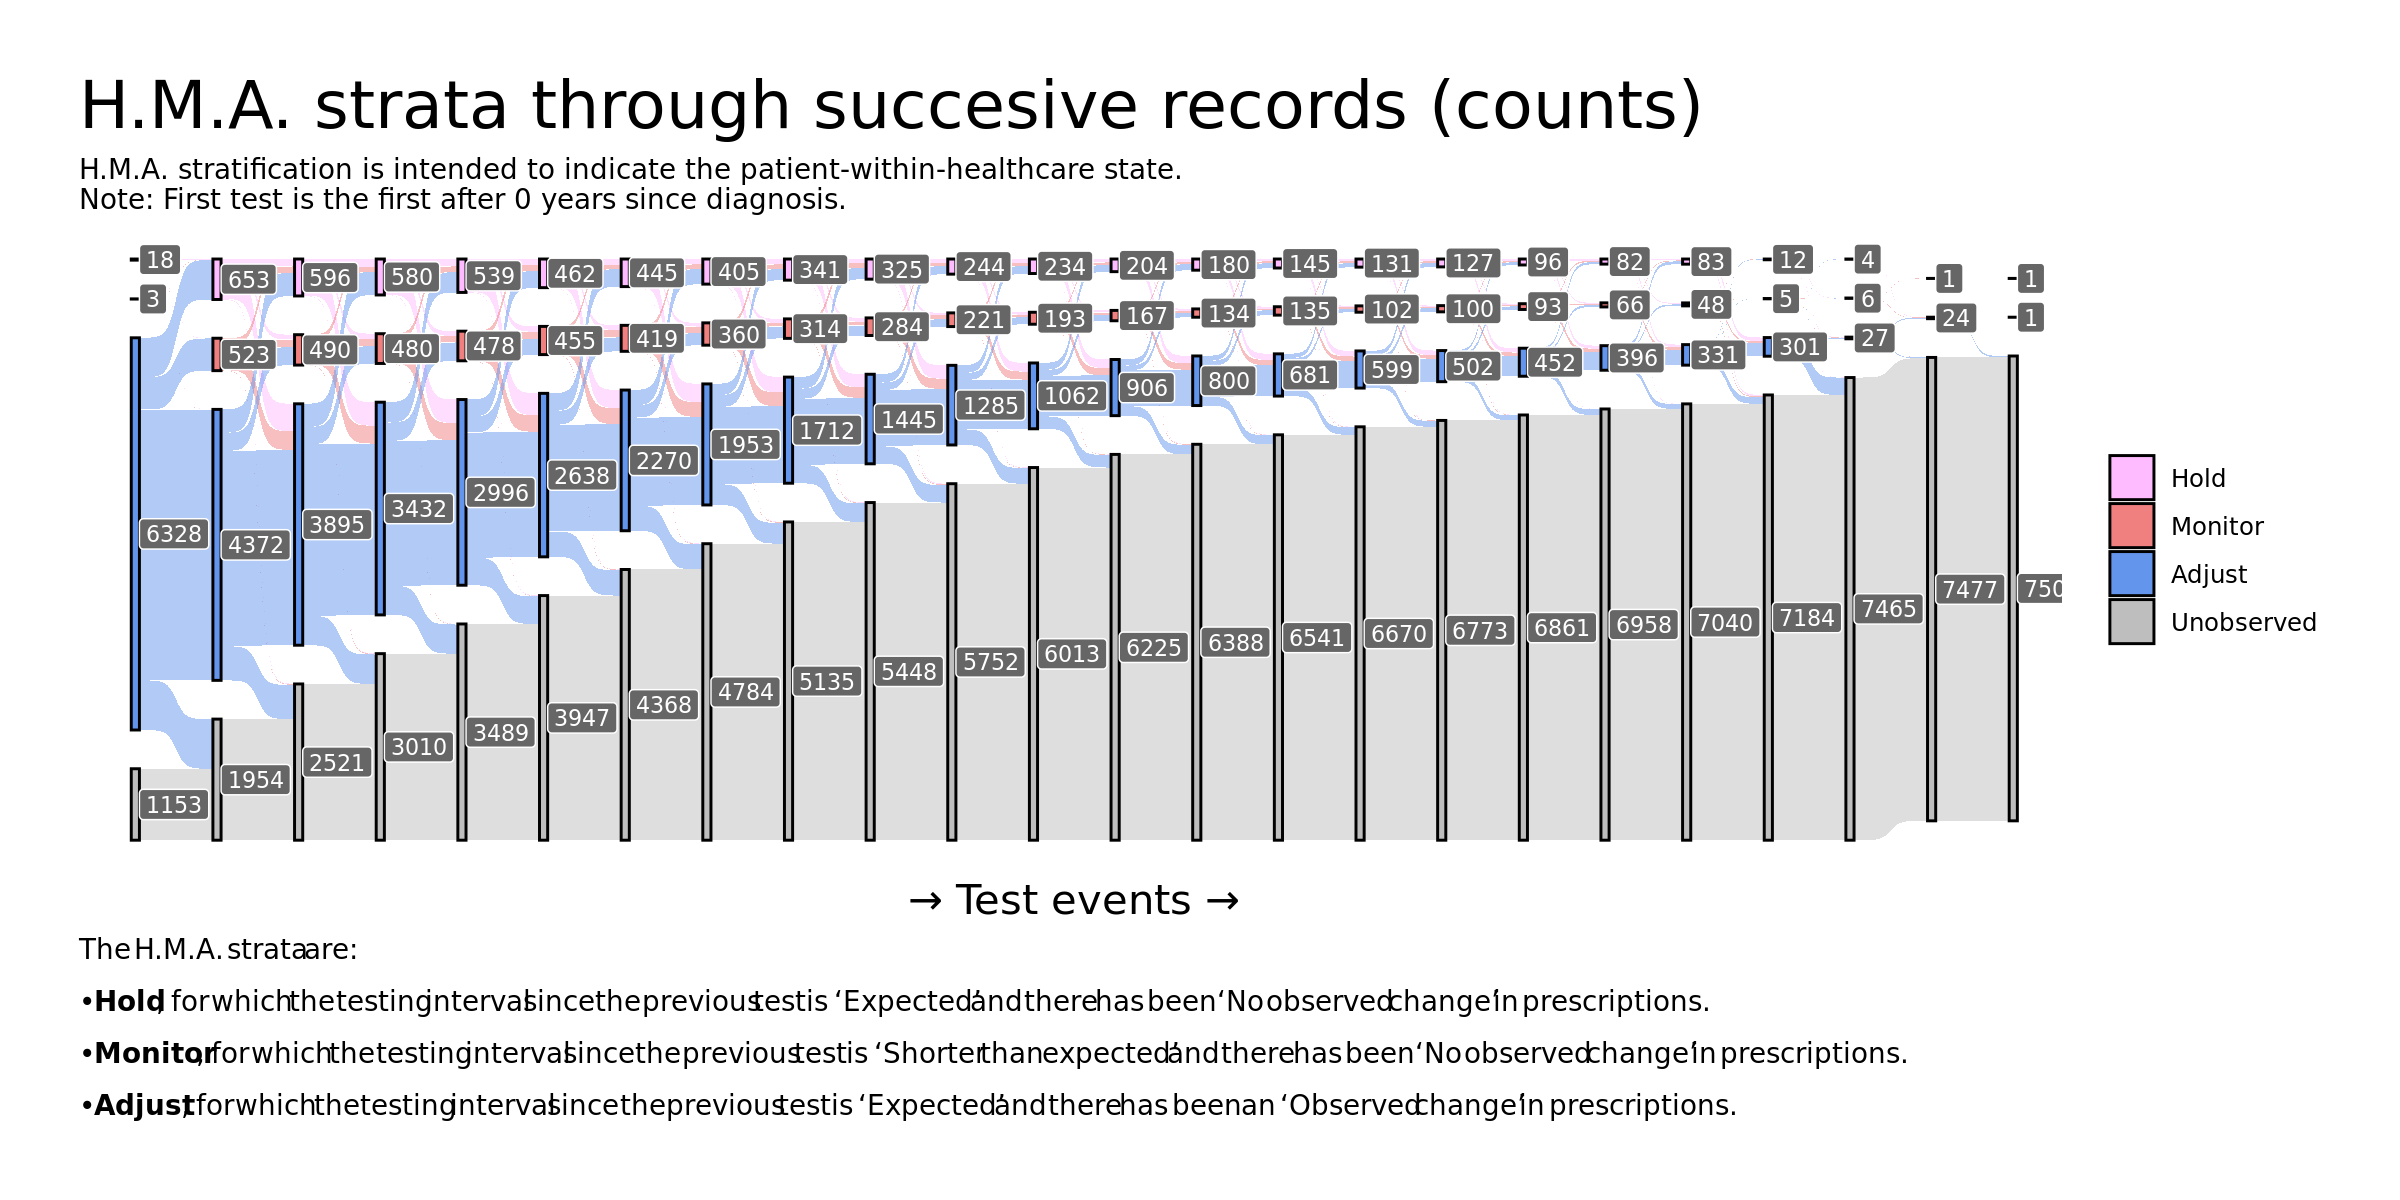

In [83]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMA %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Plot.
        options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

        plot_HMA_Sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
            ggsankey::geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull() ) +
            labs(
                title = "H.M.A. strata through succesive records (counts)"
                ,subtitle = paste0(
                    "H.M.A. stratification is intended to indicate the patient-within-healthcare state."
                    ,paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                )
                ,x = "\u2192 Test events \u2192"
                ,caption = paste0(
                    "The H.M.A. strata are:<br><br>"
                    ,"\u2022 **Hold**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                ,legend.title = element_blank()
                )

        plot_HMA_Sankey
    }

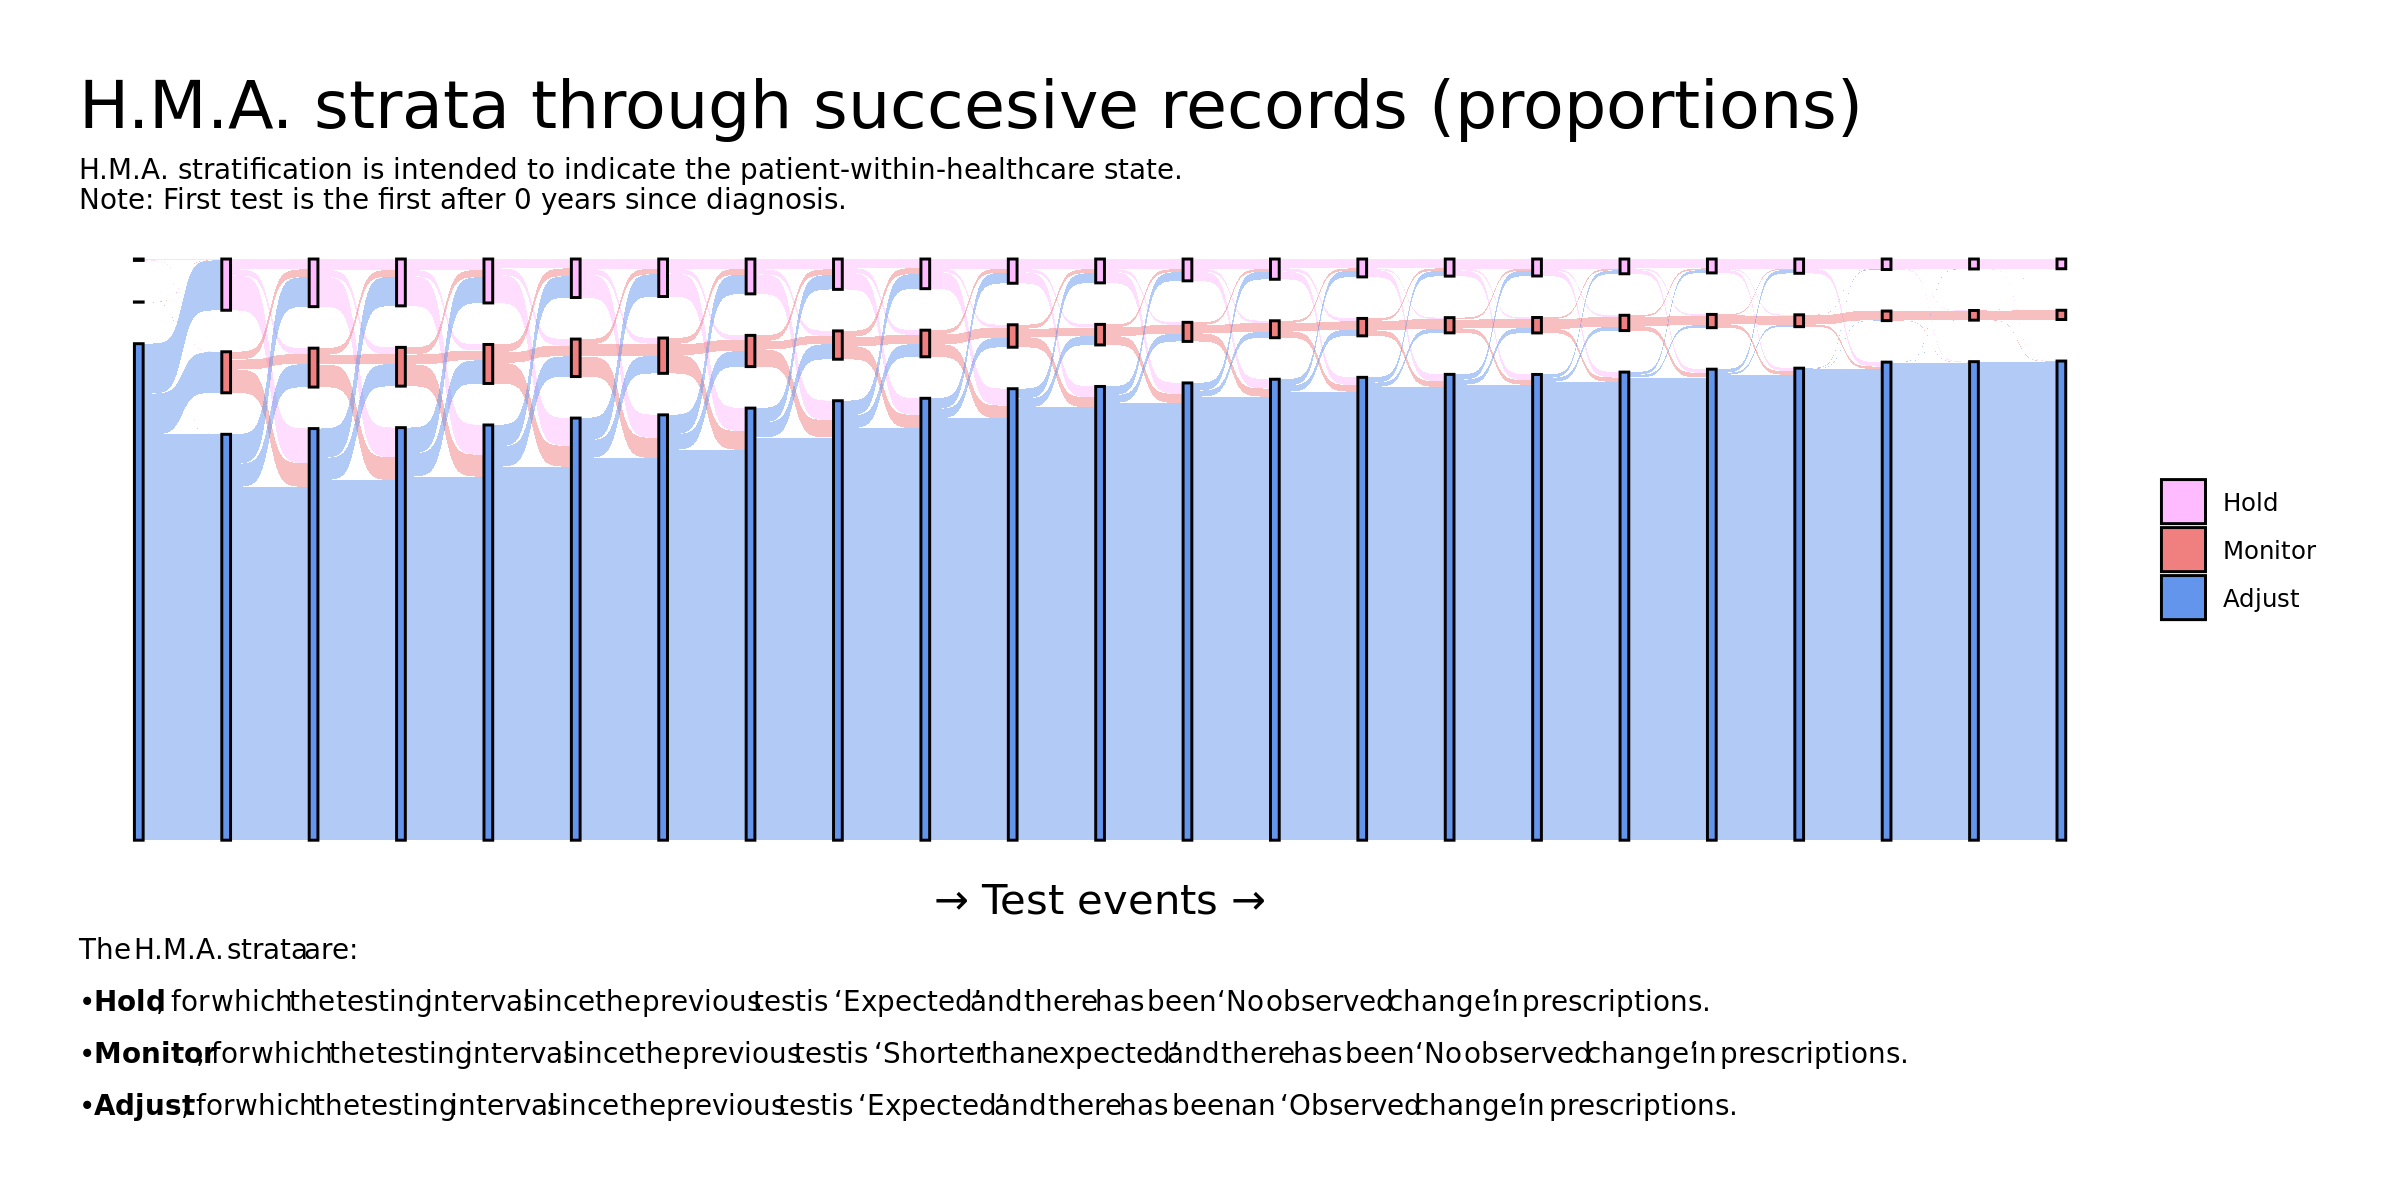

In [84]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMA_excludingUnobserved %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Plot.
        options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

        plot_HMA_Sankey_excludingUnobserved <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            ggsankey::geom_sankey( flow.alpha = 0.5, node.color = 1) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull() ) +
            labs(
                title = "H.M.A. strata through succesive records (proportions)"
                ,subtitle = paste0(
                    "H.M.A. stratification is intended to indicate the patient-within-healthcare state."
                    ,paste0("\nNote: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                )
                ,x = "\u2192 Test events \u2192"
                ,caption = paste0(
                    "The H.M.A. strata are:<br><br>"
                    ,"\u2022 **Hold**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                ,legend.title = element_blank()
                )

        plot_HMA_Sankey_excludingUnobserved
    }

Some initial observations from the H.M.A. Sankey diagram:
1. __Most patient records indicate a 'Hold' strategy at first, but the 'Monitor' strategy prevails for those records that are longer.__
    - Evidenced by the 'Hold' vertical bars being the largest, initially, but the 'Monitor' vertical bars being largest, at the end.
2. __Very few patient records indicate the undesirable category of 'Adjust'.__
    - Evidenced by the barely visible vertical bars that represent the counts of patients in the 'Adjust' state.
3. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show an unchanging probability of changing HMA-status values between tests.__
    - Evidenced by a consistent size of ribbons joining different colours, as we move from left to right in the graphic.

In the meeting of the wider project team at the end of the previous iteration, there was a request to view how individual records progress between the strata of the variable (a.k.a. the lanes) and across the events. The plot below shows the progression of a randomly-selected group of records. The random selection is taken every time the plot is rendered, and the count of records being selected can be set with the `n_records_to_sample` pareameter at the start of the code block. Note that he veritcal 'jitter' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.

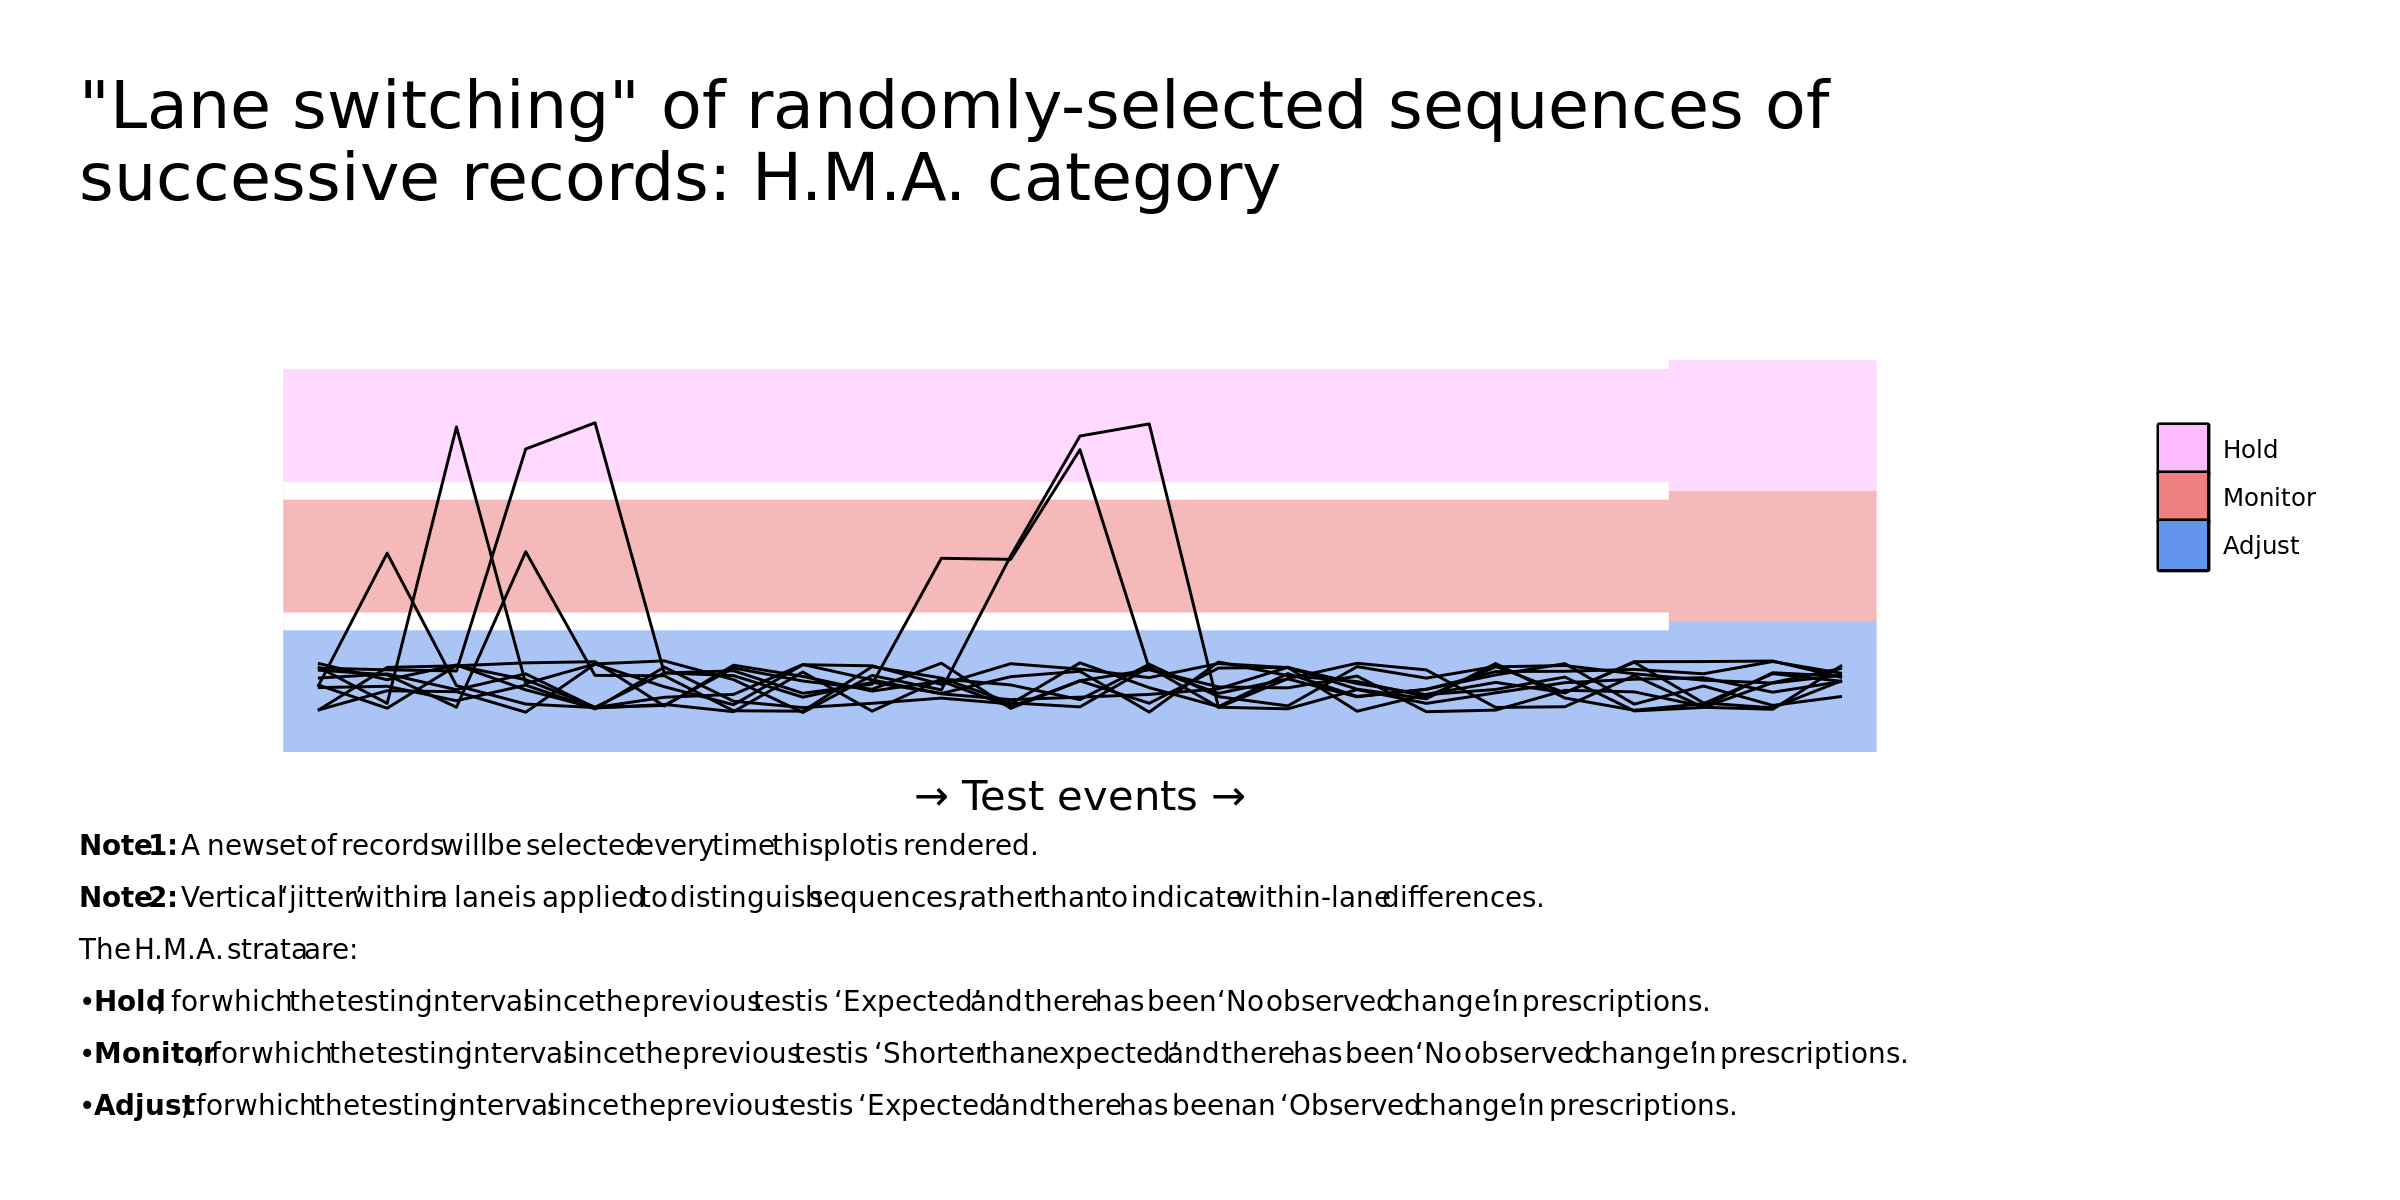

In [85]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 10

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_HMA_excludingUnobserved %>%
            dplyr::select( - last_col() ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite( col = "seqs", sep = "-", remove = FALSE ) %>%
            dplyr::mutate( seqs = as.factor(seqs) ) %>%
            tidyr::pivot_longer( cols = !seqs, names_to = "variable" )  %>%
            dplyr::mutate( variable = stringr::str_replace( variable, "a", "" ) %>% as.integer() )

        data_strata_lanes <-
            df_HMA_factor %>%
            dplyr::select( HMA_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer( cols = everything(), names_to = "variable" ) %>%
            dplyr::mutate( variable = stringr::str_replace( variable, "a", "" ) %>% as.integer() ) %>%
            dplyr::filter( value != "Unobserved" )

        # Plot
        options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

        plot_laneSwitching_HMA <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 2.5, yend = 2.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 3.5, yend = 3.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 4.5, yend = 4.5, linewidth = 3, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences %>% dplyr::mutate( grp =  rep(1:n_records_to_sample, each = nrow( . ) / n_records_to_sample ) )
                ,aes(
                    x = variable
                    ,y = value
                    ,group = grp
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = stringr::str_wrap( "\"Lane switching\" of randomly-selected sequences of successive records: H.M.A. category", width = 60 )
                ,x = "\u2192 Test events \u2192"
                ,caption = 
                    paste0(
                        "**Note 1:** A new set of records will be selected every time this plot is rendered.<br><br>"
                        ,"**Note 2:** Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.<br><br>"
                        ,"The H.M.A. strata are:<br><br>"
                        ,"\u2022 **Hold**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
                        ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
                        ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,legend.box.margin = margin( t = 1, r = 1, l = 2, b = 1, unit =  "cm")
                ,legend.key = element_rect( colour = 'black', linewidth = 1 )
                ,plot.margin = margin( t = 1, r = 0, l = 1, b = 1, unit =  "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_text( colour = 'white', size = 12)
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()

                )

        plot_laneSwitching_HMA
}

In [86]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_HMA ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

sequence           Freq Percent   cum_sum_percent
1  END                1153 15.369235 15.36923       
2  Adjust for 1 → END  801 10.677153 26.04639       
3  Adjust for 2 → END  550  7.331378 33.37777       
4  Adjust for 3 → END  435  5.798454 39.17622       
5  Adjust for 4 → END  372  4.958678 44.13490       
6  Adjust for 5 → END  295  3.932285 48.06718       
7  Adjust for 6 → END  244  3.252466 51.31965       
8  Adjust for 7 → END  191  2.545988 53.86564       
9  Adjust for 8 → END  108  1.439616 55.30525       
10 Adjust for 9 → END   79  1.053053 56.35830

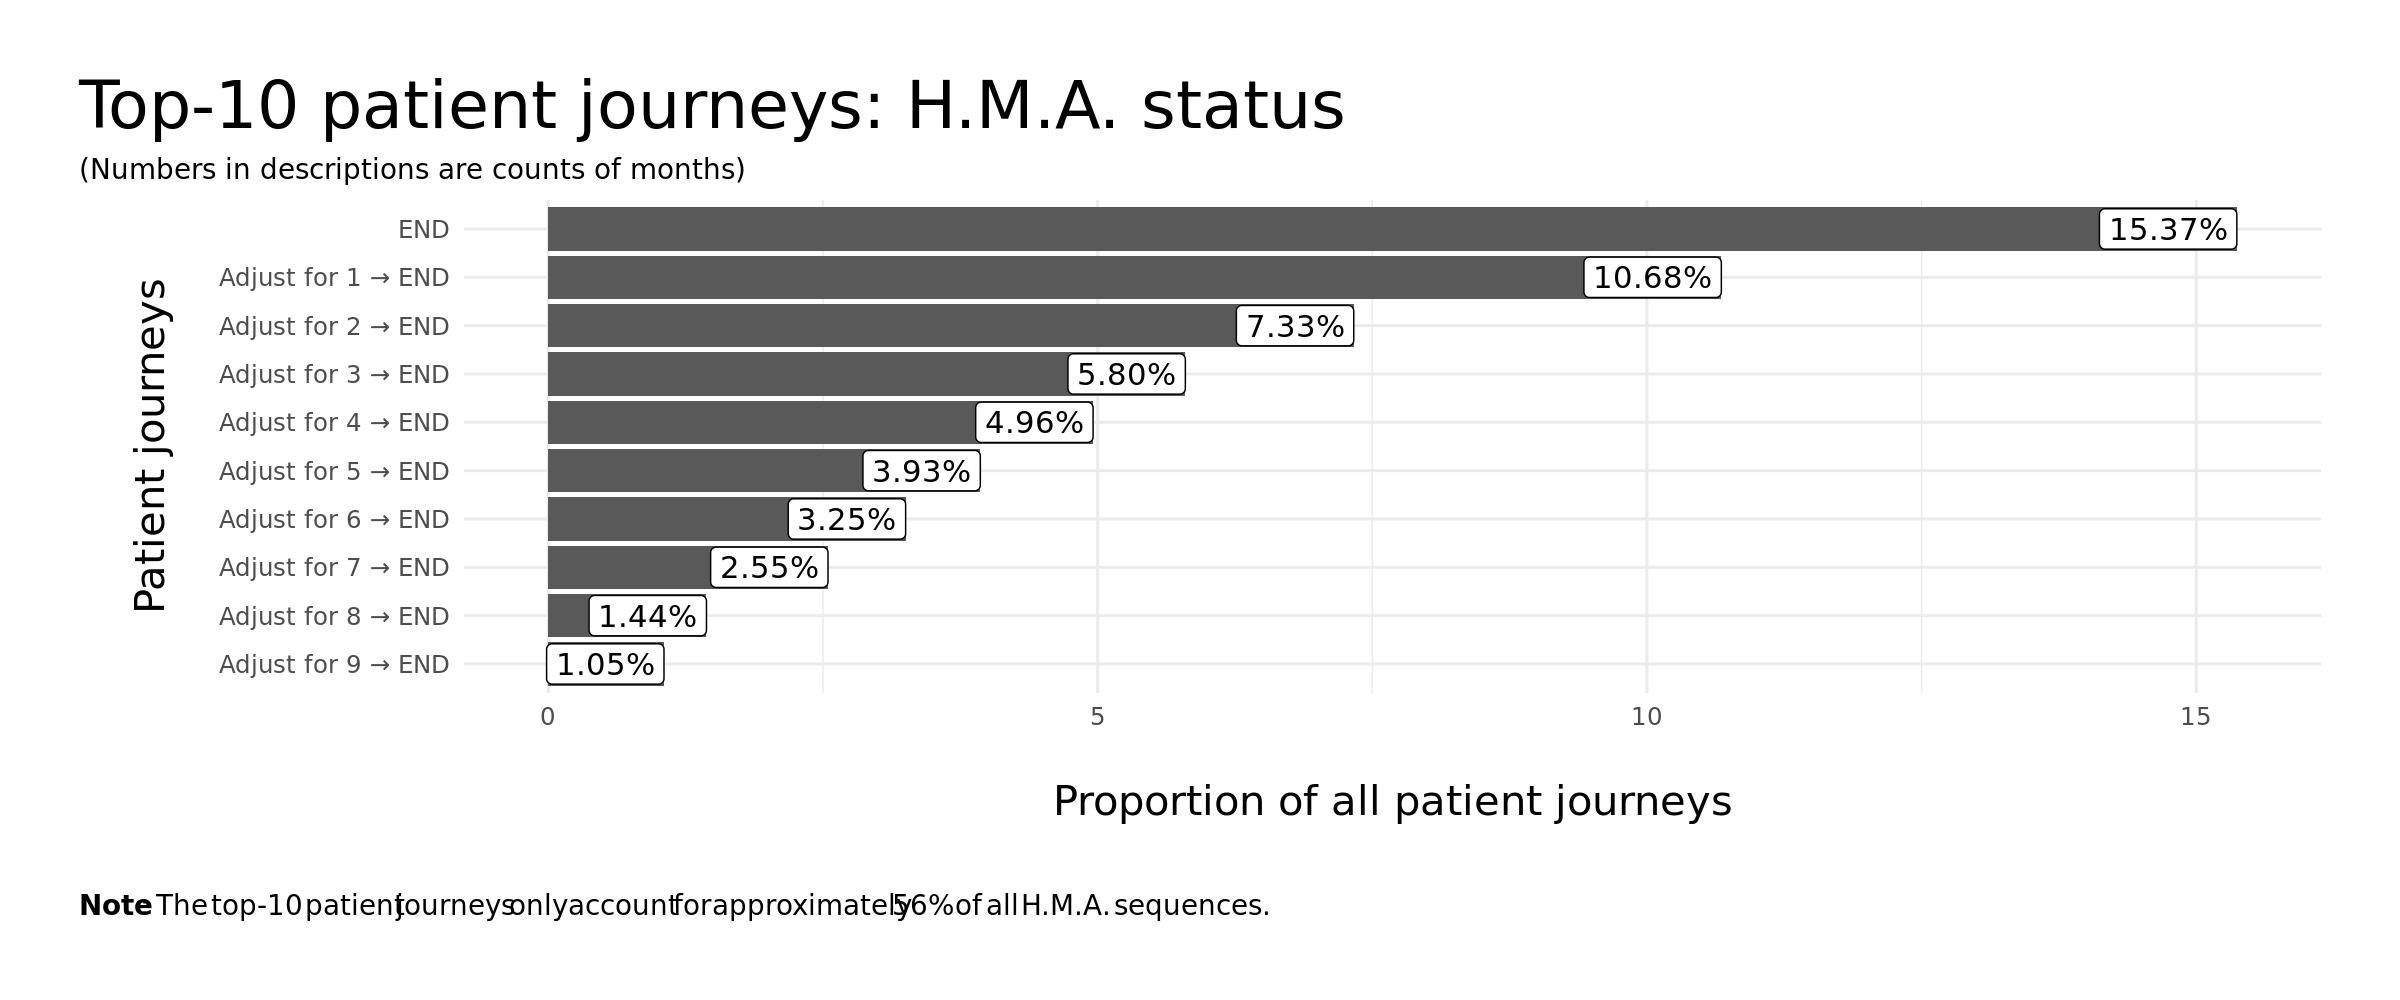

In [87]:
if ( run_process_mining_summary )
    {
        options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

        # Make plot data.
        plot_data <-
            TraMineR::seqtab( sts_seqmine_HMA ) %>%
            attributes() %>%
            purrr::pluck( "freq" ) %>%
            tibble::rownames_to_column( "sequence" ) %>%
            dplyr::arrange( desc( Freq ) ) %>%
            dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
            # Remove the leading "None/[0-9]"
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
                ) %>%
            # Replace the "-" that joins the events with an arrow.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
                ) %>%
            # Use words instead of symbols for the number of timesteps.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
                ) %>%
            # Repalce "Unobserved for [0-9]*" with "End".
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
                ) %>%
            suppressWarnings()


        # Plot plot data.
        plot_data %>%
            ggplot(
                aes(
                    x = reorder( sequence, Freq )
                    ,y = Percent )
                , stat = "identity"
            ) +
            geom_col() +
            geom_label(
                    aes(
                        label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
                    )
                    ,hjust = 1 ) +
            coord_flip() +
            labs(
                x = "Patient journeys"
                ,y = "Proportion of all patient journeys"
                ,title = "Top-10 patient journeys: H.M.A. status"
                ,subtitle = "(Numbers in descriptions are counts of months)"
                ,caption = paste0(
                    "**Note**: The top-10 patient journeys only account for approximately "
                    ,round( max( plot_data$cum_sum_percent ))
                           ,"% of all H.M.A. sequences."
                          )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = "none"
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
                ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
                )
    }

#### H.M.A. and Test Status strata

In the next plot, the Sankey plot visualises the proportions of patient records moving through test statues and H.M.A. category.

The first task is to create a new state-sequence object that tracks `HMAandTestStatus` strata.

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”


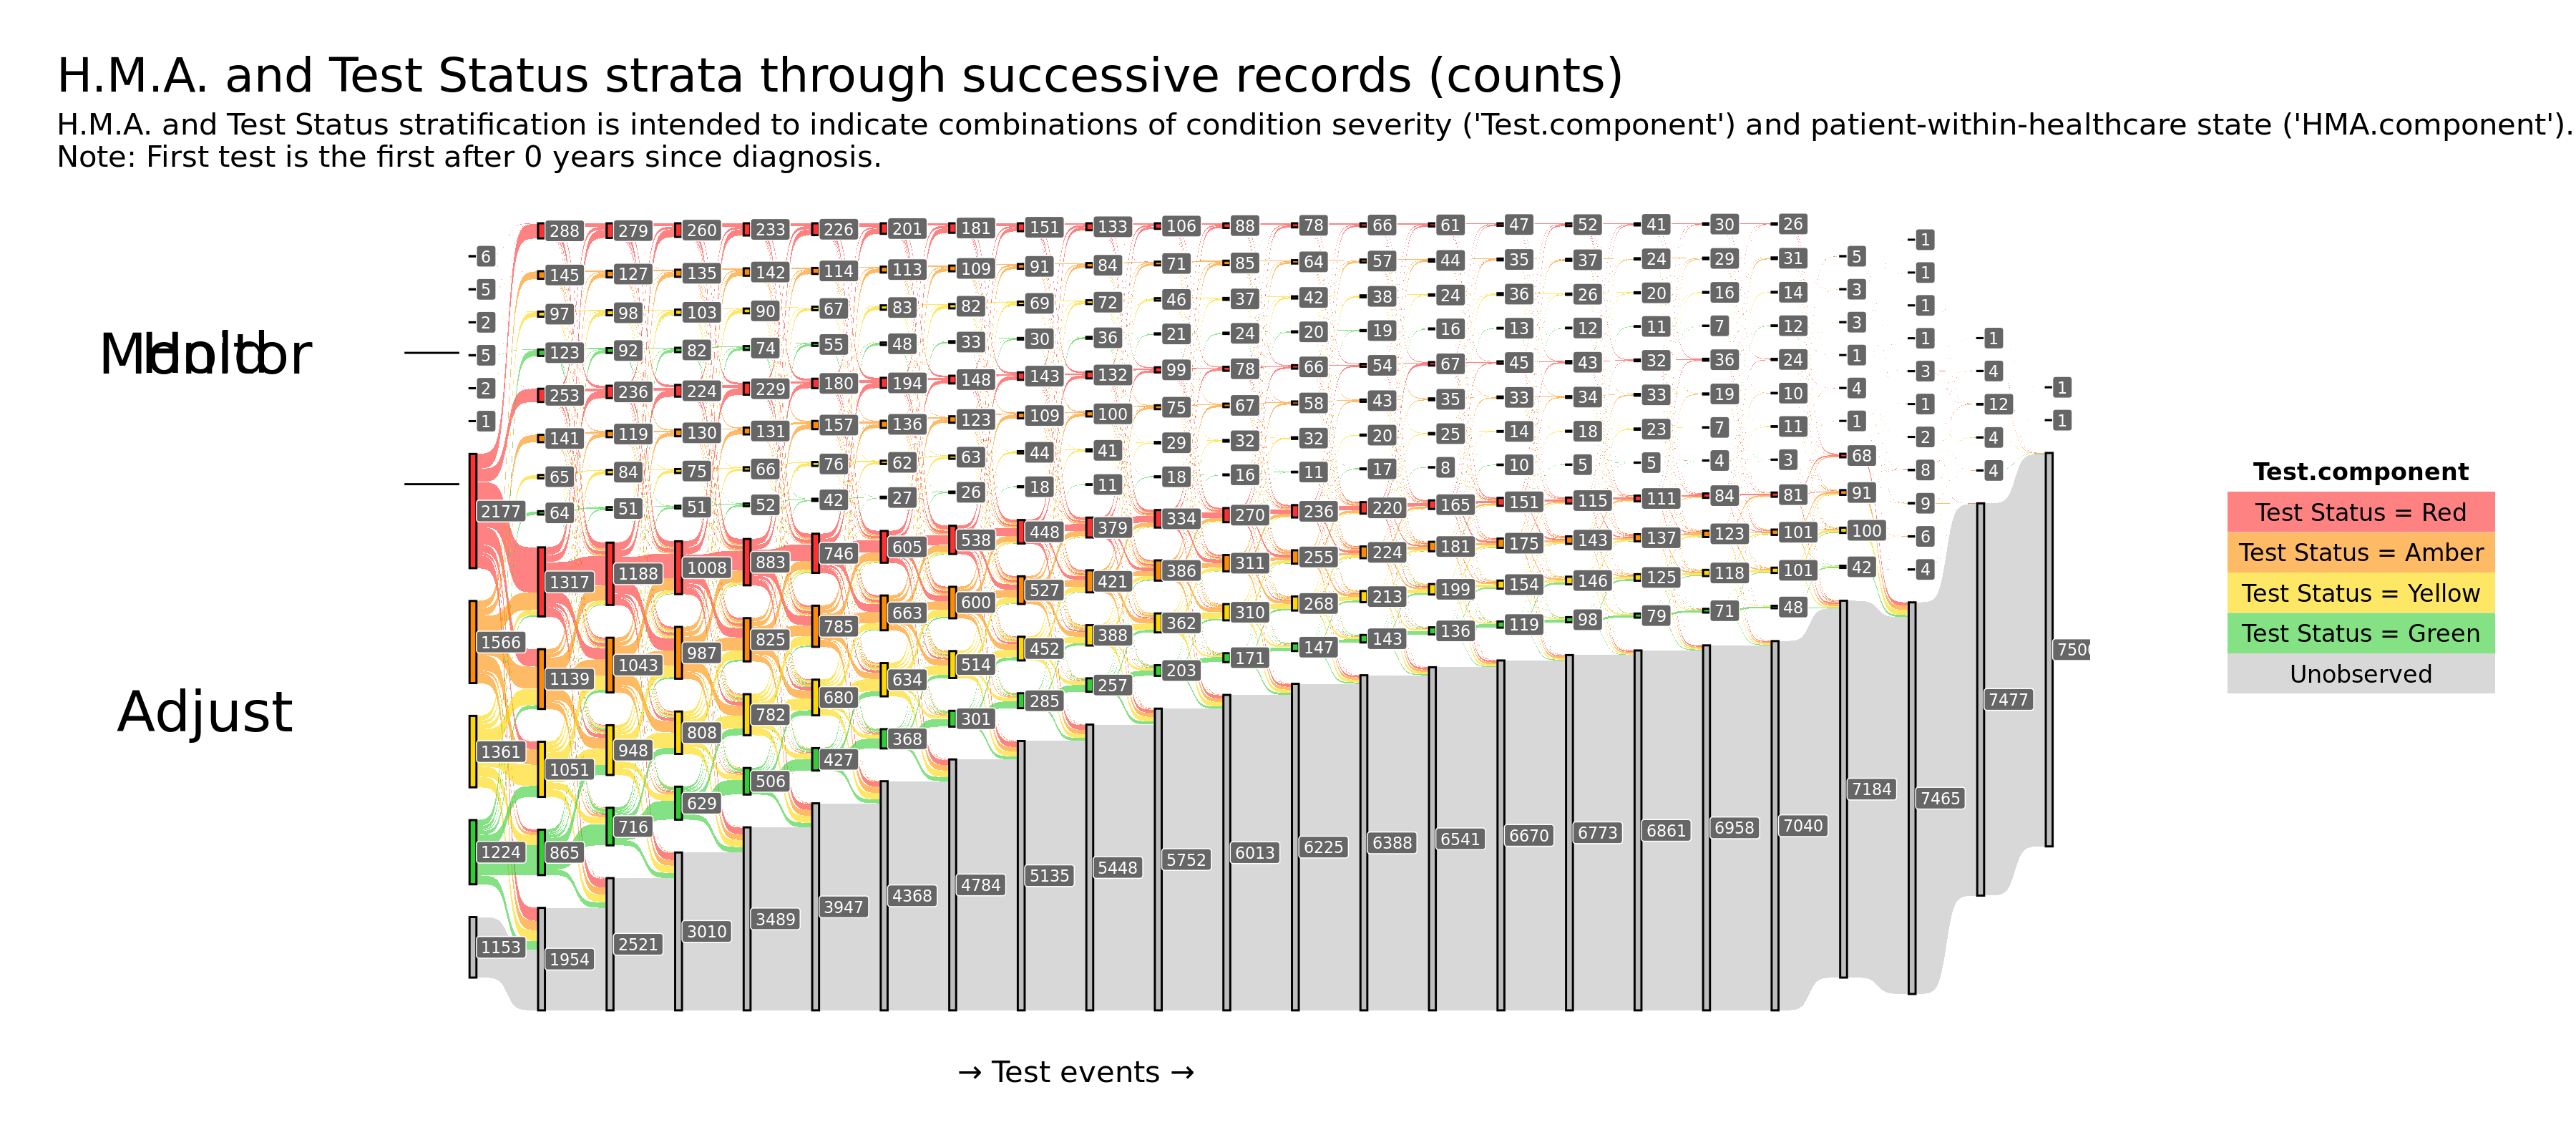

In [88]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMAandTestStatus %>%
            # Remove the default start node.
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the H.M.A. categories.
        default_space <-
            plotData %>%
            dplyr::mutate( group = 1 ) %>%
            dplyr::select( - next_x, - next_node, - next_x) %>%
            dplyr::group_by_all() %>%
            dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
            dplyr::ungroup() %>%
            # The follow is adapted from ggsankey:::find_default_space().
            dplyr::group_by(x) %>%
            dplyr::summarise(n_groups = dplyr::n_distinct(node),
                      freq = sum(freq, na.rm = TRUE)) %>%
            dplyr::mutate(v = freq / n_groups / 4) %>%
            dplyr::pull(v) %>%
            max()
        n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a2, pattern = "Hold" ) ) %>% nrow()
        n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a2, pattern = "Monitor" ) ) %>% nrow()
        n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a2, pattern = "Adjust" ) ) %>% nrow()
        n_patients_Unobserved_at_start <- sts_seqmine_HMAandTestStatus %>% dplyr::filter( stringr::str_detect( a2, pattern = "Unobserved" ) ) %>% nrow()
        n_patients_half <- sum( n_patients_Hold_at_start, n_patients_Monitor_at_start, n_patients_Adjust_at_start ) / 2
        segment_Adjust <- n_patients_Adjust_at_start - n_patients_half - default_space
        segment_Monitor <- segment_Adjust + n_patients_Monitor_at_start + ( 4 * default_space )

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            ggsankey::geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_Monitor, yend = segment_Monitor ) +
            annotate("segment", x = 0, xend = 0.8, y = segment_Adjust, yend = segment_Adjust ) +
            annotate("text", x = -5, y = segment_Monitor + ( n_patients_Hold_at_start / 2 ), label = "\t\tHold", size = 10 ) +
            annotate("text", x = -5, y = segment_Monitor - ( n_patients_Monitor_at_start / 2 ), label = "\t\tMonitor", size = 10 ) +
            annotate("text", x = -5, y = segment_Adjust - ( n_patients_Adjust_at_start / 2 ) - n_patients_Unobserved_at_start, label = "\t\tAdjust", size = 10 ) +
            # Overlay count labels.
            ggsankey::geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "H.M.A. and Test Status strata through successive records (counts)"
                ,subtitle =
                    paste0(
                        "H.M.A. and Test Status stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and patient-within-healthcare state (\'HMA.component\').\n"
                        ,paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            HMAandTestStatus_display_table %>%
            dplyr::select( Test.component ) %>%
            dplyr::slice_tail( n = 5 ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            )           

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_HMAandTestStatus_Sankey <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 5/6, 1/6 )
            )

        plot_HMAandTestStatus_Sankey
    }

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”


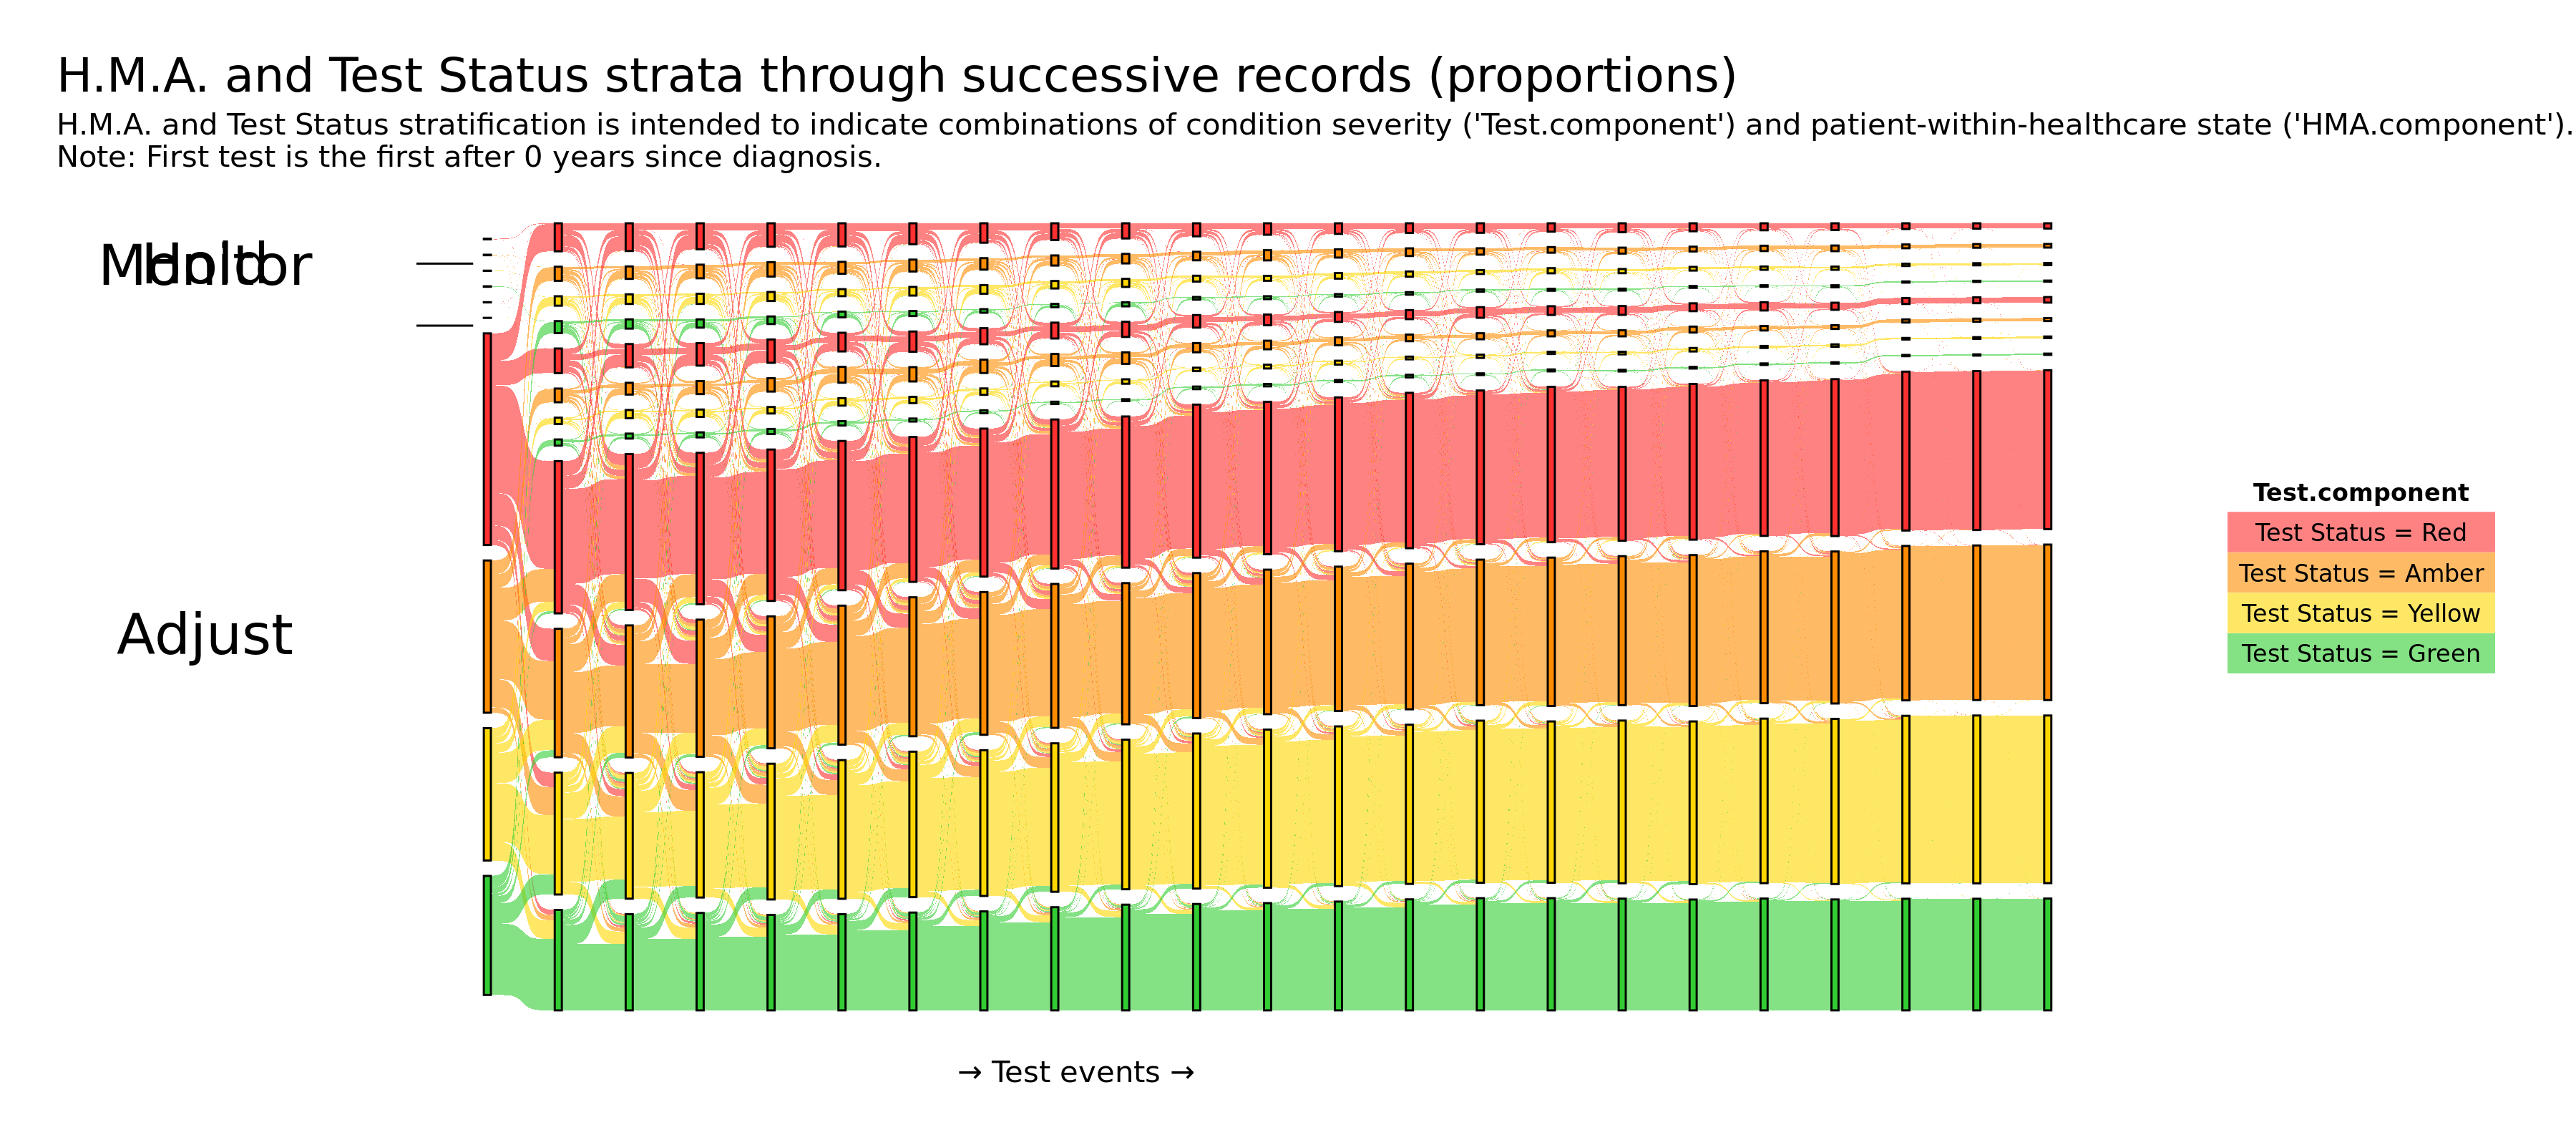

In [89]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMAandTestStatus_excludingUnobserved %>%
            # Remove the default start node.
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the H.M.A. categories.
        default_space <-
            plotData %>%
            dplyr::mutate(group = 1) %>%
            dplyr::select(-next_x, -next_node, -next_x) %>%
            dplyr::group_by_all() %>%
            dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
            dplyr::ungroup() %>%
            # The follow is adapted from ggsankey:::find_default_space().
            dplyr::group_by(x) %>%
            dplyr::summarise(n_groups = dplyr::n_distinct(node),
                      freq = sum(freq, na.rm = TRUE)) %>%
            dplyr::mutate(v = freq / n_groups / 4) %>%
            dplyr::pull(v) %>%
            max()
        n_patients_Hold_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a2, pattern = "Hold" ) ) %>% nrow()
        n_patients_Monitor_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a2, pattern = "Monitor" ) ) %>% nrow()
        n_patients_Adjust_at_start <- sts_seqmine_HMAandTestStatus_excludingUnobserved %>% dplyr::filter( stringr::str_detect( a2, pattern = "Adjust" ) ) %>% nrow()
        n_patients_half <- sum( n_patients_Hold_at_start, n_patients_Monitor_at_start, n_patients_Adjust_at_start ) / 2
        segment_Adjust <- n_patients_Adjust_at_start - n_patients_half - default_space
        segment_Monitor <- segment_Adjust + n_patients_Monitor_at_start + ( 4 * default_space )

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            ggsankey::geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_Monitor, yend = segment_Monitor ) +
            annotate("segment", x = 0, xend = 0.8, y = segment_Adjust, yend = segment_Adjust ) +
            annotate("text", x = -5, y = segment_Monitor + ( n_patients_Hold_at_start / 2 ), label = "\t\tHold", size = 10 ) +
            annotate("text", x = -5, y = segment_Monitor - ( n_patients_Monitor_at_start / 2 ), label = "\t\tMonitor", size = 10 ) +
            annotate("text", x = -5, y = segment_Adjust - ( n_patients_Adjust_at_start / 2 ), label = "\t\tAdjust", size = 10 ) +
            labs(
                title = "H.M.A. and Test Status strata through successive records (proportions)"
                ,subtitle =
                    paste0(
                        "H.M.A. and Test Status stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and patient-within-healthcare state (\'HMA.component\').\n"
                       ,paste0("Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table_excludingUnobserved <-
            HMAandTestStatus_display_table %>%
            dplyr::filter( Test.component != "Unobserved" ) %>%
            dplyr::select( Test.component ) %>%
            dplyr::slice_head( n = 4 ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_head( n = 4 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            )           

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_HMAandTestStatus_Sankey_excludingUnobserved <-
            cowplot::plot_grid(
                plot_sankey, plot_table_excludingUnobserved
                ,nrow = 1
                ,rel_widths = c( 5/6, 1/6 )
            )

        plot_HMAandTestStatus_Sankey_excludingUnobserved
    }

Some initial observations from the H.M.A. and Test Status Sankey diagram:
1. __Most patient records indicating 'Hold' or 'Monitor' have a Yellow test status.__
    - Evidenced by the largest bars in the 'Hold' and 'Monitor' states being yelloe, throughout.
2. __Very few patient records indicate the undesirable category of 'Adjust'.__
    - Evidenced by the barely visible vertical bars that represent the counts of patients in the 'Adjust' state.
3. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show an unchanging probability of changing test-status values between tests.__
    - Evidenced by a consistent size of ribbons joining different colours, as we move from left to right in the graphic.

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x09 in encoding latin1”


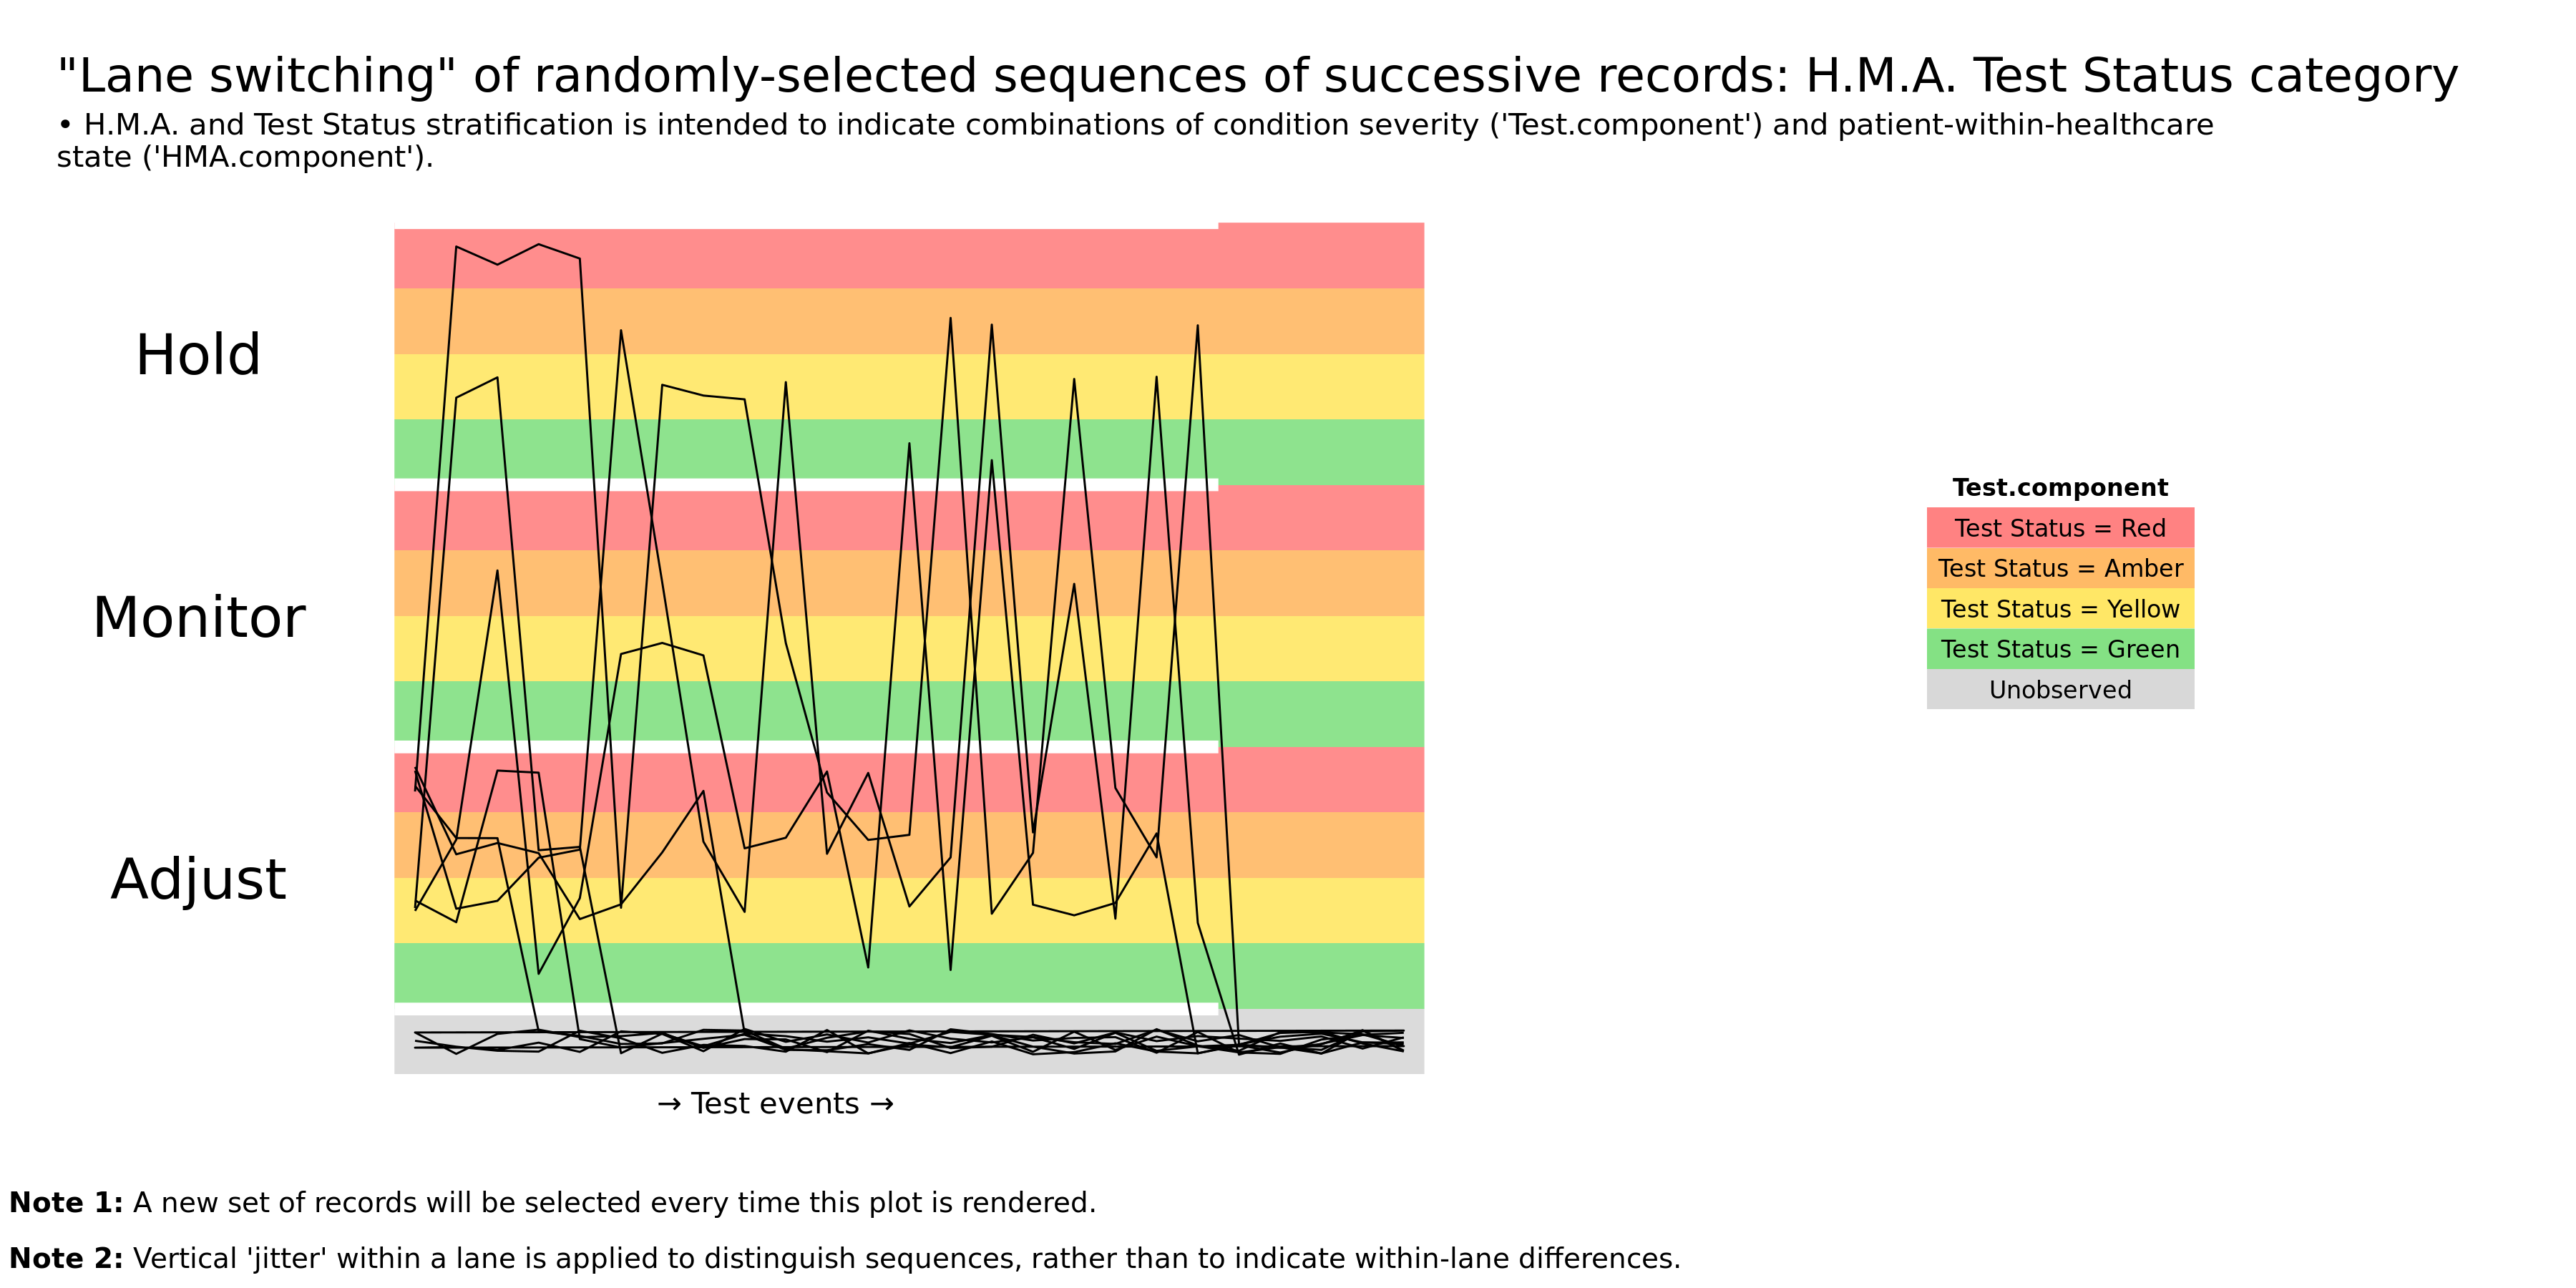

In [90]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 10

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_HMAandTestStatus %>%
            #dplyr::select( - c( a2, last_col() ) ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_HMAandTestStatus_factor %>%
            dplyr::select( HMAandTestStatus_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_laneSwitching <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 5.5, yend = 5.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 9.5, yend = 9.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 13.5, yend = 13.5, linewidth = 3, colour = "white" ) +
            # Annotate the left side of the plot with labels.
            annotate("text", x = -5, y = 11.5, label = "\tHold", size = 10, hjust = "center") +
            annotate("text", x = -5, y = 7.5, label = "\tMonitor", size = 10, hjust = "center") +
            annotate("text", x = -5, y = 3.5, label = "\tAdjust", size = 10, hjust = "center") +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences
                ,aes(
                    x = variable
                    ,y = value
                    ,group = seqs
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = "\"Lane switching\" of randomly-selected sequences of successive records: H.M.A. Test Status category"
                ,subtitle =
                    paste0(
                        "\u2022 H.M.A. and Test Status stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and patient-within-healthcare\nstate (\'HMA.component\').\n"                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,legend.position = 'none'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_laneSwitching_HMAandTestStatus <-
            cowplot::plot_grid(
                plot_laneSwitching, plot_table
                ,nrow = 1
                ,rel_widths = c( 3/5, 2/5 )
            ) %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 1:"), " A new set of records will be selected every time this plot is rendered." ) )
                ,x = 0, hjust = 0
            )  %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 2:"), " Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences." ))
                ,x = 0, hjust = 0
            ) 

        plot_laneSwitching_HMAandTestStatus %>% cowplot::ggdraw()
    }

In [91]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_HMAandTestStatus ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

sequence                                    Freq Percent    cum_sum_percent
1  END                                         1153 15.3692349 15.36923       
2  Adjust Red for 1 → END                       249  3.3191149 18.68835       
3  Adjust Yellow for 1 → END                    202  2.6926153 21.38097       
4  Adjust Amber for 1 → END                     182  2.4260197 23.80698       
5  Adjust Green for 1 → END                     168  2.2394028 26.04639       
6  Adjust Red for 2 → END                       105  1.3996268 27.44601       
7  Adjust Green for 2 → END                      71  0.9464143 28.39243       
8  Adjust Yellow for 2 → END                     51  0.6798187 29.07225       
9  Adjust Red for 3 → END                        50  0.6664889 29.73874       
10 Adjust Red for 1 → Adjust Amber for 1 → END   47  0.6264996 30.36524

#### T-and-I strata

In the next plot, the Sankey plot visualises the proportions of patient records moving between strata of the T-and-I stratification.

The T-and-I stratification is something CB proposed. It has 17 strata derived from combining the test status, T, {Test status = Red, Test status = Amber, Test status = Yellow, Test status = Green} with a variable indicating the count of unique medications prescribed in previous inter-test intervals, P, {0, 1, 2, 3}, i.e. poly-pharmacy. One additional strata is designated for where errors arise in the data.

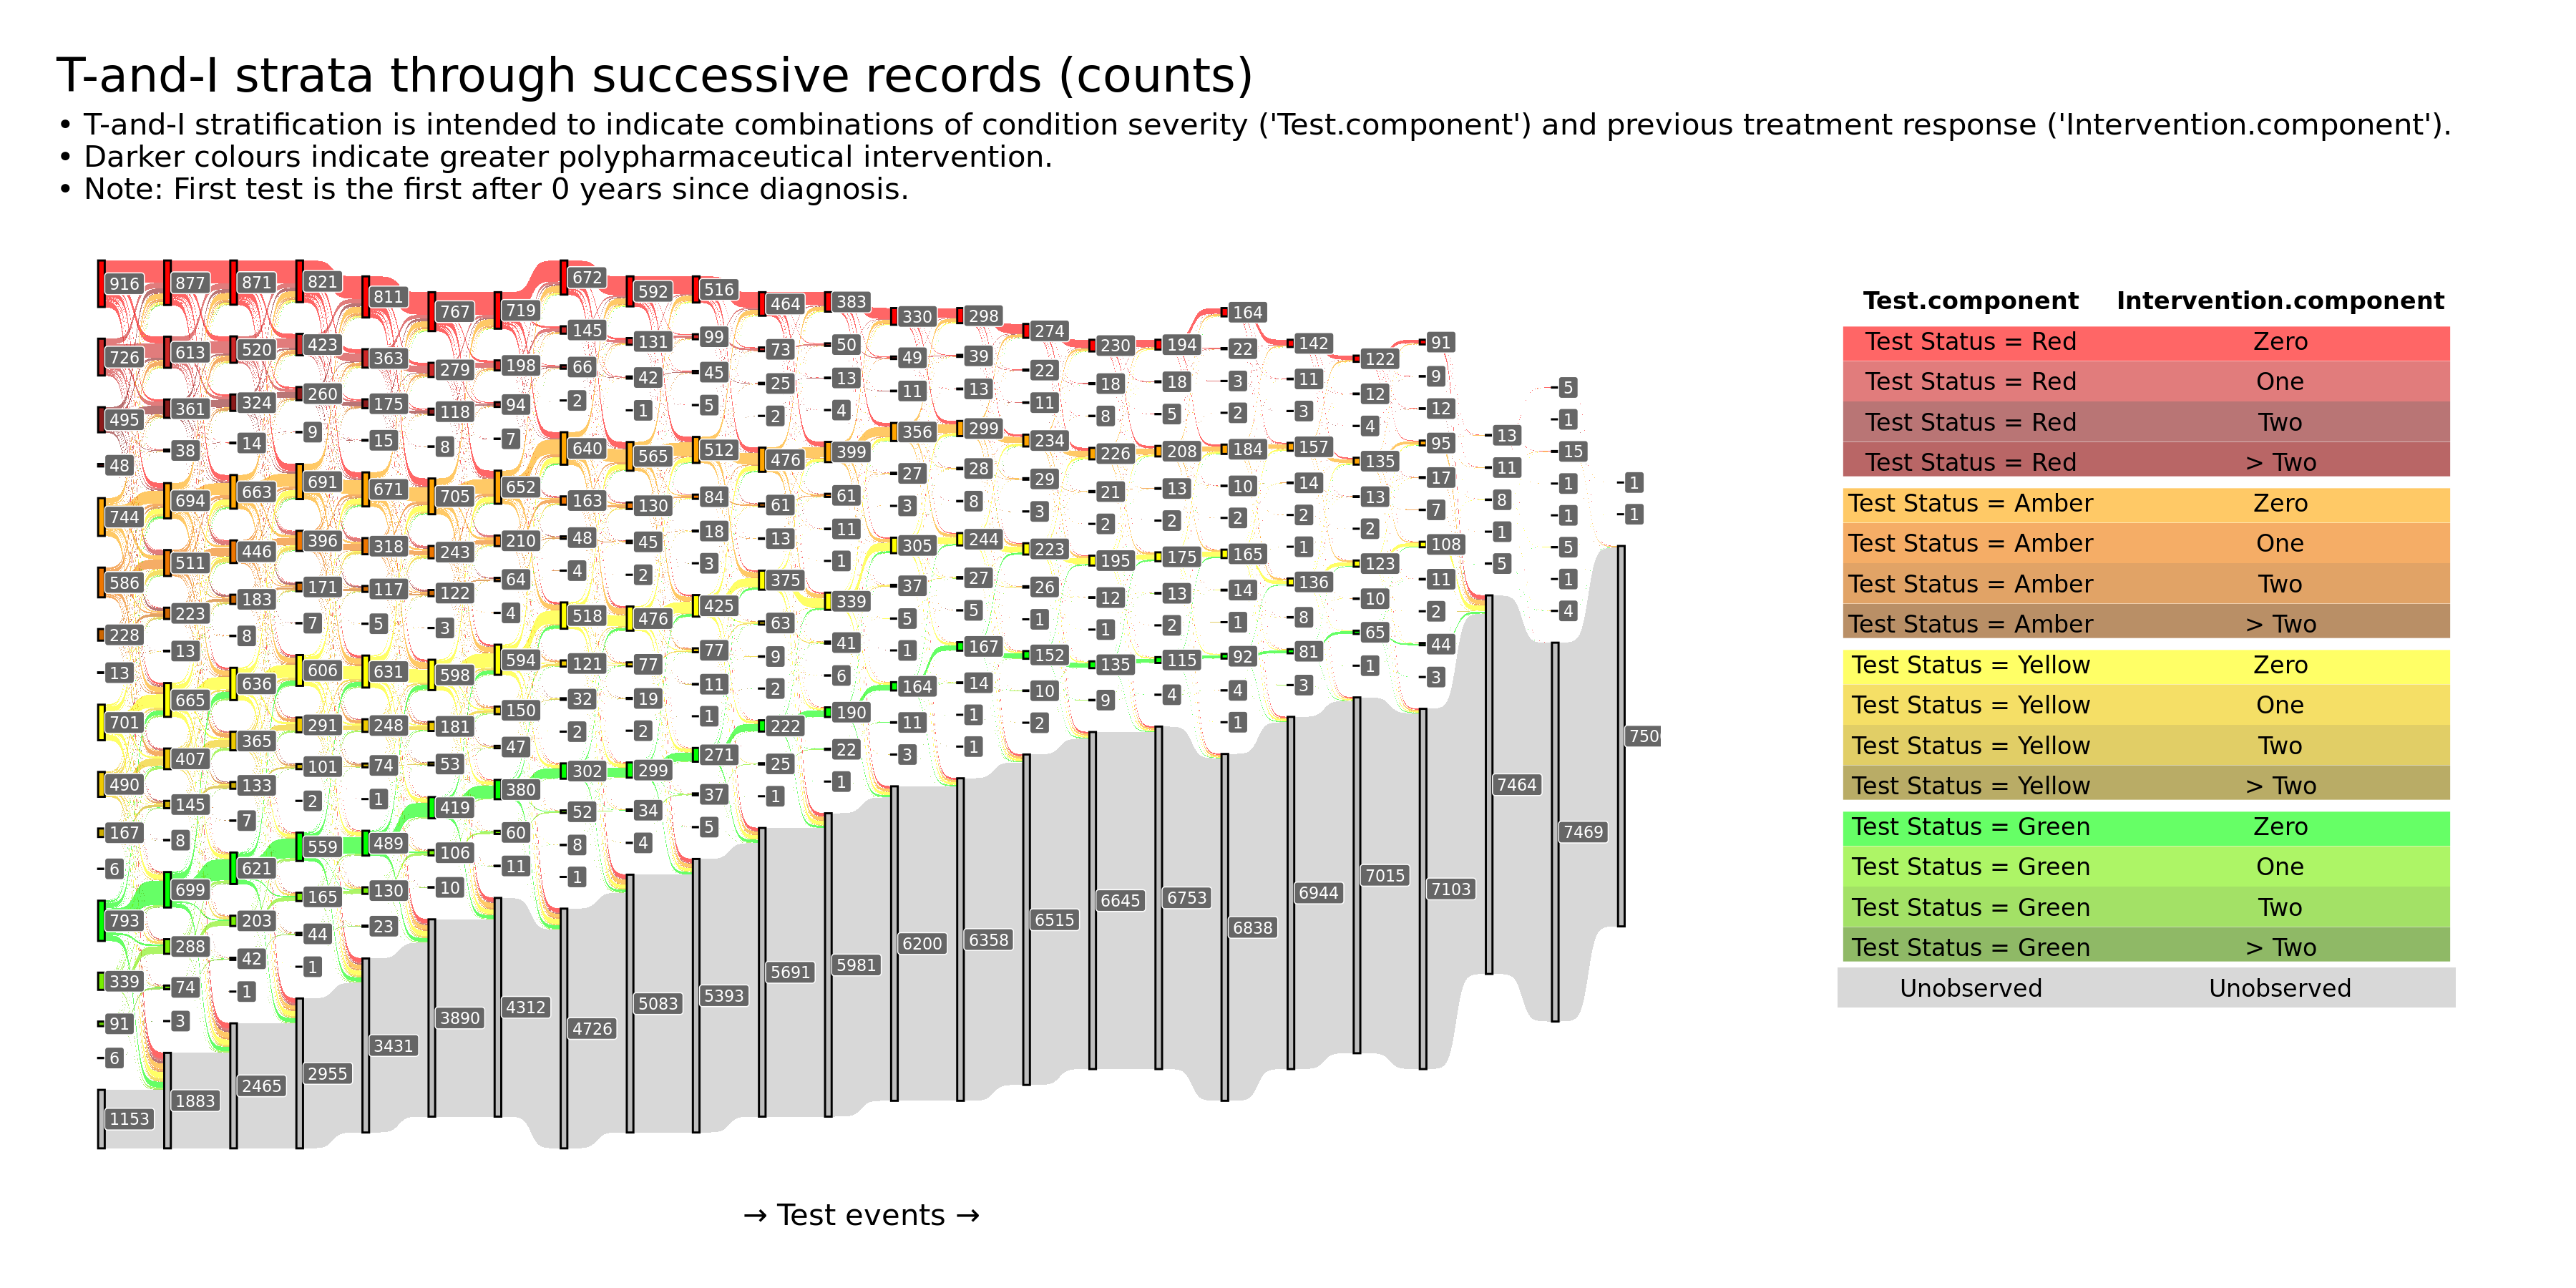

In [92]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandI %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandI_factor %>% dplyr::select( TandI_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            ggsankey::geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
            ) +
            ggsankey::geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-I strata through successive records (counts)"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-I stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and previous treatment response (\'Intervention.component\').\n"
                        ,"\u2022 Darker colours indicate greater polypharmaceutical intervention.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandI_display_table %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 10, b = 13, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 14, b = 17, l = 1, r = 2
            )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_TandI_Sankey <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandI_Sankey
    }

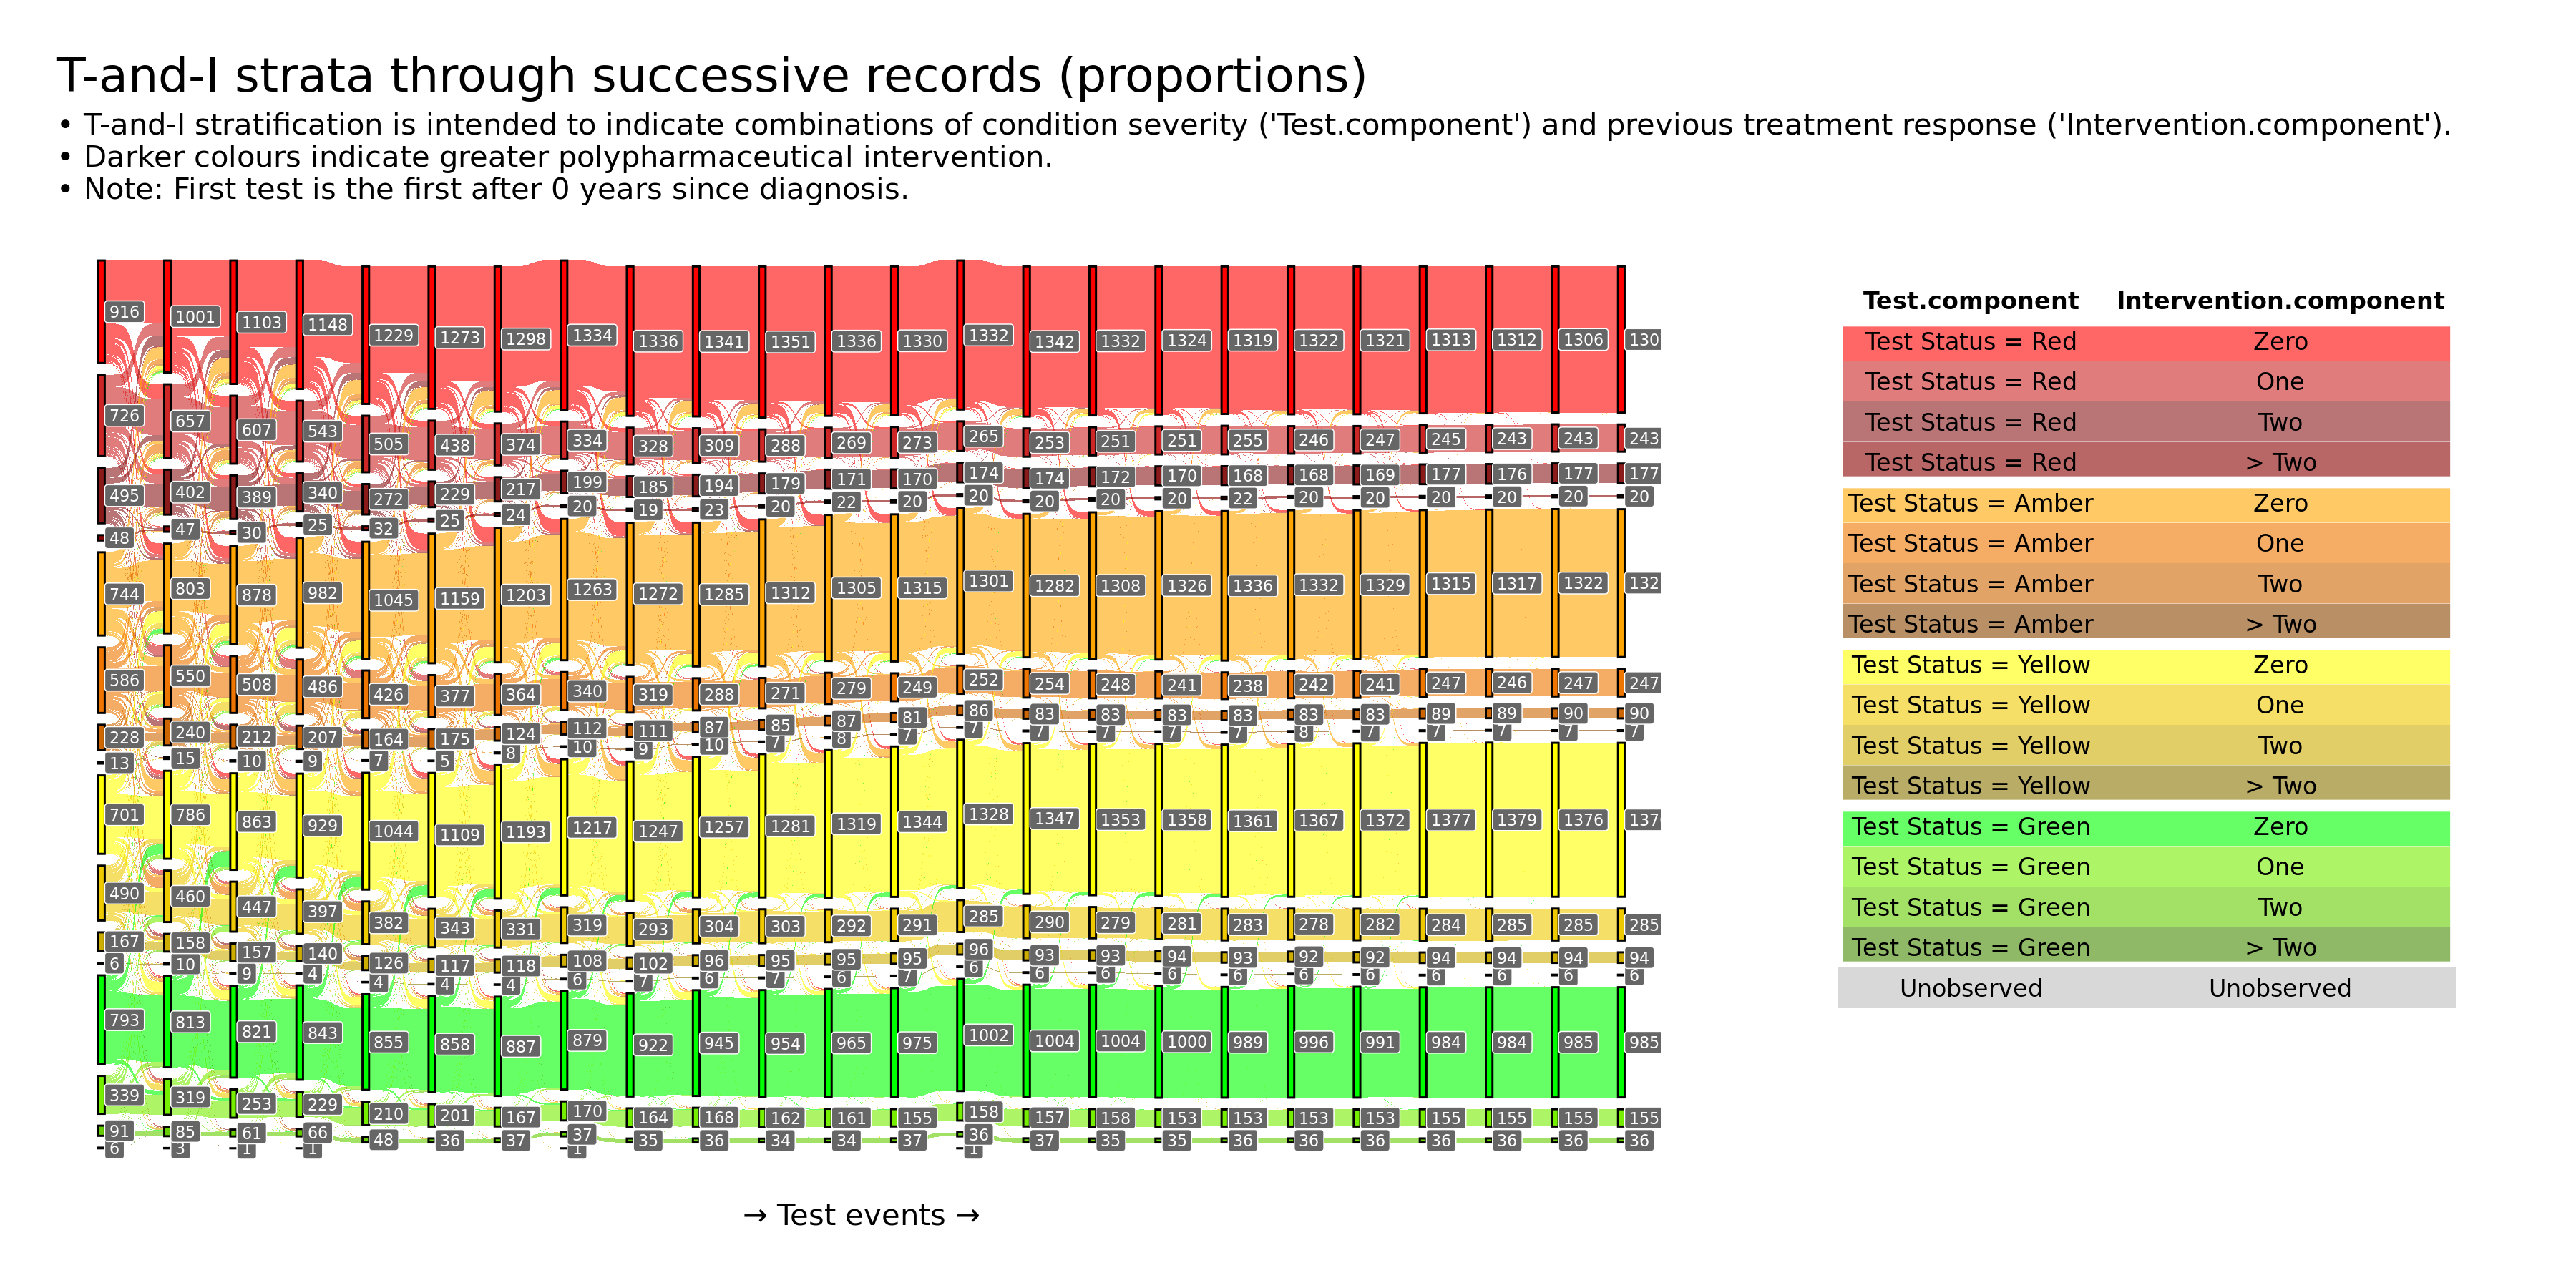

In [93]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandI_excludingUnobserved %>%
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandI_factor %>% dplyr::select( TandI_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            ggsankey::geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
            ) +
            ggsankey::geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-I strata through successive records (proportions)"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-I stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and previous treatment response (\'Intervention.component\').\n"
                        ,"\u2022 Darker colours indicate greater polypharmaceutical intervention.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandI_display_table %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 10, b = 13, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 14, b = 17, l = 1, r = 2
            )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_TandI_Sankey_excludingUnobserved <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandI_Sankey_excludingUnobserved
    }

Some initial observations from the T-and-I Sankey diagram:
1. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show an increase the proportion of records indicating a given test status with no prescription.__
    - Evidenced by a gradual increase in the size of ribbons joining the same colours, as we move from left to right in the graphic.

In the meeting of the wider project team at the end of the previous iteration, there was a request to view how individual records progress between the strata of the variable (a.k.a. the lanes) and across the events. The plot below shows the progression of a randomly-selected group of records. The random selection is taken every time the plot is rendered, and the count of records being selected can be set with the `n_records_to_sample` pareameter at the start of the code block. Note that he veritcal 'jitter' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.

In [94]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 50

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_TandI %>%
            #dplyr::select( - last_col() ) %>%
            dplyr::distinct() %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_TandI_factor %>%
            dplyr::select( TandI_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_laneSwitching <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the two groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 5.5, yend = 5.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 9.5, yend = 9.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 13.5, yend = 13.5, linewidth = 3, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences %>% dplyr::mutate( grp =  rep(1:n_records_to_sample, each = n_iterations) )
                ,aes(
                    x = variable
                    ,y = value
                    ,group = grp
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = "\"Lane switching\" of randomly-selected sequences of successive records: T-and-I category"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-I stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and previous treatment response (\'Intervention.component\').\n"
                        ,"\u2022 Darker colours indicate greater polypharmaceutical intervention.\n"
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,legend.position = 'none'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_laneSwitching_Tand_I <-
            cowplot::plot_grid(
                plot_laneSwitching, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            ) %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 1:"), " A new set of records will be selected every time this plot is rendered." ) )
                ,x = 0, hjust = 0
            )  %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 2:"), " Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences." ))
                ,x = 0, hjust = 0
            ) 

        plot_laneSwitching_Tand_I %>% cowplot::ggdraw()
}

ERROR: [1m[33mError[39m in `dplyr::mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `grp = rep(1:n_records_to_sample, each = n_iterations)`.
[1mCaused by error:[22m
[1m[22m[33m![39m `grp` must be size 1250 or 1, not 1000.


In [ ]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_TandI ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

#### Multimorbidity strata

In the next plot, the Sankey plot visualises the proportions of patient records moving from no multimorbidity to multimorbidity.

In [ ]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandMultiMorb %>%
            # Remove the default start node.
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the multimorb from the not-multimorbid strata.
        n_patients_Multimorb_at_start <- sts_seqmine_TandMultiMorb %>% filter( !stringr::str_detect( a2, pattern = "Not" ) ) %>% nrow()
        n_patients_notMultimorb_at_start <- sts_seqmine_TandMultiMorb %>% filter( stringr::str_detect( a2, pattern = "Not" ) ) %>% nrow()
        segment_offset <-
            ifelse(
                n_patients_notMultimorb_at_start < n_patients_Multimorb_at_start
                ,( ( n_patients_Multimorb_at_start + n_patients_notMultimorb_at_start ) / 2 ) - n_patients_Multimorb_at_start
                ,( ( n_patients_Multimorb_at_start + n_patients_notMultimorb_at_start ) / 2 ) + n_patients_notMultimorb_at_start
            )
            

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            ggsankey::geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_offset, yend = segment_offset ) +
            annotate("text", x = -3, y = segment_offset + ( n_patients_notMultimorb_at_start / 2 ), label = "\n\n\nMultimorbid", angle = 90, size = 5, hjust = "center" ) +
            annotate("text", x = -3, y = segment_offset - ( n_patients_notMultimorb_at_start / 2 ), label = "\n\nNot\nmultimorbid", angle = 90, size = 5, hjust = "center" ) +
            # Overlay count labels.
            ggsankey::geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-MultiMorb strata through successive records (counts)"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-MultiMorb stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and multimorbidity (\'Multimorbidity.component\').\n"
                        ,"\u2022 Darker colours indicate multimorbidity.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandMultiMorb_display_table %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 10, b = 10, l = 1, r = 2
            )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_TandMultiMorb_Sankey <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandMultiMorb_Sankey
    }

In [ ]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandMultiMorb_excludingUnobserved %>%
            # Remove the default start node.
            dplyr::select( - last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the multimorb from the not-multimorbid strata.
        n_patients_Multimorb_at_start <- sts_seqmine_TandMultiMorb_excludingUnobserved %>% filter( !stringr::str_detect( a2, pattern = "Not" ) ) %>% nrow()
        n_patients_notMultimorb_at_start <- sts_seqmine_TandMultiMorb_excludingUnobserved %>% filter( stringr::str_detect( a2, pattern = "Not" ) ) %>% nrow()
        segment_offset <-
            ifelse(
                n_patients_notMultimorb_at_start < n_patients_Multimorb_at_start
                ,( ( n_patients_Multimorb_at_start + n_patients_notMultimorb_at_start ) / 2 ) - n_patients_Multimorb_at_start
                ,( ( n_patients_Multimorb_at_start + n_patients_notMultimorb_at_start ) / 2 ) + n_patients_notMultimorb_at_start
            )
            

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            ggsankey::geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_offset, yend = segment_offset ) +
            annotate("text", x = -3, y = segment_offset + ( n_patients_notMultimorb_at_start / 2 ), label = "\n\n\nMultimorbid", angle = 90, size = 5, hjust = "center" ) +
            annotate("text", x = -3, y = segment_offset - ( n_patients_notMultimorb_at_start / 2 ), label = "\n\nNot\nmultimorbid", angle = 90, size = 5, hjust = "center" ) +
            # Overlay count labels.
            ggsankey::geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-MultiMorb strata through successive records (proportions)"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-MultiMorb stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and multimorbidity (\'Multimorbidity.component\').\n"
                        ,"\u2022 Darker colours indicate multimorbidity.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandMultiMorb_display_table %>%
            dplyr::filter( Value != "Unobserved" ) %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) 

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_TandMultiMorb_Sankey_excludingUnobserved <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandMultiMorb_Sankey_excludingUnobserved
    }

Some initial observations from the T-and-I Sankey diagram:
1. __Unlike the previous iteration where we looked at sequences from diagosis, these sequences from 10 years after diagnosis show the greatest proportion of records have a Red test status while not being multimorbid (as opposed to yellow and multimorbid).__

In [ ]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 50

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_TandMultiMorb %>%
            dplyr::select( - last_col() ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_TandMultiMorb_factor %>%
            dplyr::select( TandMultiMorb_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_laneSwitching <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the two groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 5, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 5.5, yend = 5.5, linewidth = 5, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences
                ,aes(
                    x = variable
                    ,y = value
                    ,group = seqs
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = "\"Lane switching\" of randomly-selected sequences of successive records: T-and-MultiMorb category"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-Multimorbidity stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and multimorbidity (\'Multimorbidity.component\').\n"
                        ,"\u2022 Darker colours indicate multimorbidity.\n"
                        ,paste0("\u2022 Note: First test is the first after ", lubridate::interval( date_diagnosis_threshold, date_followup_start ) / lubridate::years(1), " years since diagnosis.")
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,legend.position = 'none'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_laneSwitching_Tand_MultiMorb <-
            cowplot::plot_grid(
                plot_laneSwitching, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            ) %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 1:"), " A new set of records will be selected every time this plot is rendered." ) )
                ,x = 0, hjust = 0
            )  %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 2:"), " Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences." ))
                ,x = 0, hjust = 0
            ) 

        plot_laneSwitching_Tand_MultiMorb %>% cowplot::ggdraw()
    }

In [ ]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_TandMultiMorb ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

### 8.4.2 Build simulation models, if applicable
Not applicable for this iteration.

### 8.4.3 Design and test model evaluation rig

Not applicable for this iteration.

### 8.4.4 Set up and/or update the evidence template
Not applicable for this iteration.

## Stage 5: Evaluation
This tasks for this stage are:
1. Meet with Clinical Review Board to assess validity.
2. Set requirements for next interation of stages 1-5.

### 8.5.1. Meet with Clinical Review Board to assess validity
Notes from meeting of the Clinical Review Board on <day> <date> <month>:
- T

### 8.5.2 Set requirements for next interation of stages 1-5.
Requirements for the next iteration are:
1. 